In [ ]:
!pip install datasets
!pip install sacrerouge sacrebleu bert-score
!pip install sentencepiece
!pip install transformers

"""
!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers/.
"""

     |████████████████████████████████| 325 kB 9.0 MB/s 
     |████████████████████████████████| 136 kB 65.0 MB/s 
     |████████████████████████████████| 77 kB 9.6 MB/s 
     |████████████████████████████████| 212 kB 64.8 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 127 kB 73.4 MB/s 
     |████████████████████████████████| 144 kB 70.7 MB/s 
     |████████████████████████████████| 271 kB 67.1 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 336 kB 6.6 MB/s 


     |████████████████████████████████| 1.2 MB 9.1 MB/s 


'\n!git clone https://github.com/huggingface/transformers.git\n!pip install ./transformers/.\n'

## Xtreme Abstractive summarization 

[More details on the dataset](https://huggingface.co/datasets/xsum)

In [ ]:
import matplotlib.pyplot as plt
import bert_score
import sacrebleu
import pandas as pd 
import torch.nn.functional as F
import torch
import numpy as np

In [ ]:
from datasets import load_dataset

# loading dataset
train_dataset = load_dataset('xsum', split='train')
valid_dataset = load_dataset('xsum', split='validation')
test_dataset = load_dataset('xsum', split='test')

# in this example we will use only one batch containing 10 examples 
batch_input = test_dataset["document"][0:10]
batch_output = test_dataset["summary"][0:10]

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/954 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499)
Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499)


# Model 

**BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension [Paper](https://arxiv.org/abs/1910.13461) | [usage](https://huggingface.co/transformers/model_doc/bart.html) | [Model card](https://huggingface.co/facebook/bart-large)**

The Bart model was proposed in BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Mike Lewis, Yinhan Liu, Naman Goyal, Marjan Ghazvininejad, Abdelrahman Mohamed, Omer Levy, Ves Stoyanov and Luke Zettlemoyer.

Normally BART would need to be finetuned for XSUM to be able to run on this task for this we will use `distilbart-xsum-6-6` a smaller version of bart that is finetuned already on the Xsum dataset. 


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

# Each model has a name on the hugging face website: you can search through the list of all models here https://huggingface.co/models
model = BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-xsum-6-6")

# usually each model has a special tokenizer these tokenizers contain the vocabulary dictionary of all the tokens you should find the one that works with the model you use
# usually they have the same name but for the model "sshleifer/distilbart-xsum-6-6" which is made by the community we know that it is an adaptation of BART model so 
# it works with the BART tokenizer.
tok = BartTokenizer.from_pretrained("facebook/bart-base")  ## tokenizer

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

In [ ]:
# using our loaded tokenizer: we will encode the input documents into 
# max_length is 1024 as the bart model allows to accept 1024 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=1024, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=1024, truncation=True, return_tensors="pt")

In [ ]:
# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

{'input_ids': tensor([[    0, 35515,   556,  ...,   981, 33385,     2],
        [    0,   113,   133,  ...,     1,     1,     1],
        [    0,   133,   395,  ...,     1,     1,     1],
        ...,
        [    0, 40420, 19508,  ...,     1,     1,     1],
        [    0,   113, 29220,  ...,     1,     1,     1],
        [    0, 40066,  3730,  ...,  2182, 11826,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')}

In [ ]:
# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"])

In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

source:	 Fast forward about 20 years, and it's fair to say he has done just that.
The business he runs, Frasers Hospitality, is one of the world's biggest providers of high-end serviced apartments. Its 148 properties span about 80 capital cities, as well as financial hubs across Europe, Asia, the Middle East and Africa.
But it almost didn't get off the ground.
When Mr Choe was appointed to launch and lead the company, Asia was booming; the tiger economies of Hong Kong, South Korea, Taiwan and Singapore were expanding rapidly.
But as Frasers prepared to open its first two properties in Singapore, the Asian financial crisis hit.
It was 1997. Currencies went into freefall. Suddenly, people were losing their jobs and stopped travelling.
Mr Choe recalls asking staff if they really wanted to continue working with the firm, because when the properties opened they might not get paid.
"It was really that serious," he says. "I remember tearing up because they said 'let's open it, let's open it w

# Evaluations 

In [ ]:
percision,recall,fscore = bert_score.score(cands=model_output_decoded, refs=batch_output, lang="en")
bleu = sacrebleu.corpus_bleu(model_output_decoded, [batch_output]).score


df = pd.DataFrame({
    "BLEU":bleu,
    "BERTSCORE-percision": [float(percision.mean())],
    "BERTSCORE-recall": [float(recall.mean())],
    "BERTSCORE-fscore": [float(fscore.mean())]
    })

df

NameError: ignored

# Attention extraction

In [ ]:

# Make model output attention matrices 
input_sample = "Attention is the ability to actively process specific information in the environment while tuning out other details. Attention is limited in terms of both capacity and duration, so it is important to have ways to effectively manage the attentional resources we have available in order to make sense of the world."
input_sample_tok = tok(input_sample, return_tensors="pt").to('cuda')

# WARNING : this requires a lot of RAM, avoid running it on very large samples
model_output_with_att = model(input_sample_tok['input_ids'], output_attentions=True)
model_output_with_att.keys()


odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

# Exercise 3

Welcome to your last exercise in this learning journey :). 
We provide you with a notebook containing an example on how to load a pretrained model inside the hugging face library and use it for generation tasks, we would like to ask you to do the same using other models and evaluate on other datasets. 

In particular, in this excercise you will be a master in loading Pretrained models (like T5), writing your own decoding algorithms, as well as investigating what is happening under the hood by interpreting their decisions. You will be (almost) an expert on three tasks Machine Translation, Summarization and Question Answering. 

The notebook contains some examples showing some guiding examples based on BART model. This model is a pretrained one that needs finetuning on the target task to perform well. The cool thing about T5 that it is trained jointly on many tasks both supervised and unsupervised such as LM, translation, summarization and question answering by reforming all tasks as "text" to "text". "For example, automatic summarization is done by feeding in a document
followed by the text “Summarize:” and then the summary is predicted via autoregressive decoding." In this excercise you will have to append those tokens yourself in the input to the model to be able to use it as a summarization model. 

-----

# TASK1: 

## 1.1 Use T5 model on new tasks and dataset
 
### T5 

 - Note: For this exercise you would need to get last dev version (`4.4.0.dev0`) of transformers from github
 
 ```
 git clone https://github.com/huggingface/transformers.git
 %cd transformers
 pip install .
```
 - You will use `t5-small` pretrained model from Hugging Face: https://huggingface.co/t5-small

 - The documentation of T5 class can be found here: https://huggingface.co/transformers/model_doc/t5.html
 
 To know more about T5 model: 
  - Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer (https://arxiv.org/pdf/1910.10683.pdf)
  - Stanford guest lecture about T5: http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture14-t5.pdf

### New Tasks & Datasets   
- Translation: `bible_para` (https://huggingface.co/datasets/bible_para), `ted_talks_iwslt` (https://huggingface.co/datasets/ted_talks_iwslt) 
- Summarization : `cnn-dailymail` (https://huggingface.co/datasets/cnn_dailymail) 
- Question answering: BoolQ dataset (https://huggingface.co/datasets/boolq)


**Note:** `t5-small` can not handle sequences longer than 512 max_length; you would need to preprocess your datasets accordingly as done above in the tokenizer.

For each task you should give a certain prefix augemented to the input (e.g. "translate English to German: " to be able to translate an english input to german) to know each task prefix consider looking into the config https://huggingface.co/t5-small/blob/main/config.json . 


### Deliverable 1.1  (2 pt)
**OUTPUT:** print some examples from the test/validation split of each task showing the input/model output/ target reference.

## 1.2 - Implement Extra evaluation Metrics

- Summarizaiton: ROUGE (https://www.aclweb.org/anthology/W04-1013.pdf)
- MT: BLEU (https://www.aclweb.org/anthology/P02-1040/)
- Question Answering : exact match and macro-F1 (https://arxiv.org/pdf/1606.05250.pdf) 
- For those you will need a tokenizer you can use an existing implementation of the [MOSES tokenizer](https://pypi.org/project/mosestokenizer/) 
### Deliverable 1.2 (3 pt)
 - implement evaluation metrics : BLEU, ROUGE
 - Select ~1000 sentences from each of the datasets (use `test` when available, or `validation` split otherwise)
 - **Table1**: Evaluate your model on those Metrics
 - **Table2**: As a sanity check of your implementation use already existing implementation online of those metrics and compare them together with your implementation. 

## 1.3- Implement Decoding methods your own
Now you are not allowed to use the existing implementation of the function `model.generate`. [Read here about different usages of this function including many decoding algorithms beam, sampling, top-k and nucleus sampling](https://huggingface.co/blog/how-to-generate)

- **Implement a beam search** generation function that takes beamsize as a function parameter. 
- **Implement a Nucleus sampling** function that samples from a model using Nucleus sampling taking top-p as a function parameter. 
- **Implement Softmax with Temperature** function that samples from a model using Sampling with Temperature taking temperature(t) as a function parameter. 

### Deliverable 1.3 (8pt)

- **Table1:** Check Correctness of your implementation, in a table show a comparison between results obtained from model.generate function and your implementation for different beam-sizes for beamsearch and top-p 

- **Table2:** Compare between different decoding methods. for summarization and machine translation and question answering try different decoding methods for example try changing the top-p value in the nucleus sampling algorithm the temperature of the softmax and with the beamsize in the beam search (for this only you are allowed to use model.generate and existing implementation of evaluation metrics
- **Short Report 300 words max:** Given the results you obtained above. Write a short report containing your conclusions on which are the best decoding algorithm / parameter for each task. Why do you think they are the best? Does increasing the beam size usually give better scores? Why or Why not?

---------------

# Task 2 Attention Visualization 

The goal of this exercise is to understand whether (and how) the attention can be used to interpret model's behaviour. 

## 2.1 Implement cross-attention matrix vizualization
Select several examples for each task and manually examine the attention patterns for each of those tasks. What are your observations? Is there any difference in attention patterns; is there any common patterns? 

### Deliverable 2.1 (3 pt)
**Plots:** You are expected to output plots similar to those in [this blogpost](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
(section attention visualization). 

We expect you to visualize at least three plots showing any of the following
- Vizualize attention matrices per each head and each layer
- Try to aggregate the attention values across heads/layers.
- Consider examples from different categories that would take into account: model performance (hard vs easy examples), input length, different task.

**Short report max 300 words:** Add below each of the attention values above. Your comments Highlighting those patterns and what do you observe: eg. common or different patterns across tasks, how those patterns change across layers, individual attention heads versus aggregated attention patterns, any other observations. 

## 2.2 Implement Attention Matrix Aggregation
Manual examination allows to get an intuition of what attention patterns are. Aggregation metrics allow to make corpus-wide conclusions about the roles of different attention heads. Check (this paper)[https://www.aclweb.org/anthology/P19-1580/]  for more details. Implement one of the "aggregation" metrics proposed in that paper : confidence score or LRP. Compare the attention patterns across the tasks.  

### Deliverable 2.2  (4 pt) 
- **Plots and short report:** Implement one of these methods for Attention aggregation (Condifence score or LRP) and plot 3 plots showing some of the aspects above  



----------------------------------


# Bonus 1 (experiment with finetuning)
 - Take any available model on Hugging face which was trained/fine-tuned specifically for the above mentioned tasks (translation, summarization, question answering)
 - Perform task 1 and task 2 with those task-adapted models; Compare it to T5 performance/behaviour.  


## Deliverable Bonus 1 (3pt)
- **Table:** On a single task compare task 1 and 2 using several evaluation metrics and interpretability measures from the above (you can use existing implementation for those metrics). 
- **Short report 300 words max** : comment on What is common and different between these models in terms of interpretability and evaluation metrics? Does the finetuned model perform better than T5 model who was trained on all tasks together? Why would you use one instead of the other? 


# Bonus 2 (implement Minimum Bayes Risk Decoding)
Neural Language Generation models are silly what they believe the highest likely sequence is usually an empty sequence (`<s></s>`) This problem is demonstrated in the following paper: [On NMT Search Errors and Model Errors: Cat Got Your Tongue?](https://www.aclweb.org/anthology/D19-1331/).

This problem is puzzling many scientists at the moment. A method to overcome is to sample many output of the model and rank them according to their pairwise utility. This is a tracktable approximation of a method called Minimum bayes risk decoding. That has been recently proposed in this recent work [Is MAP Decoding All You Need? The Inadequacy of the Mode in Neural Machine Translation](https://arxiv.org/pdf/2005.10283.pdf).
<img src=https://i.imgur.com/J0ePay7.png width=500>

In this bonus task we ask you to implement this decoding method as the two one above (you can use any utility function of your choice in the paper they use METEOR python implementation is available online e.g. here https://pypi.org/project/textmetrics/).

## Deliverable Bonus 2 (5pt):
- **Table:** Compare MBR decoding vs Beam search with beam size=5, beam size=10, beam size=15 other on machine translation task above.  
- **Short Report 300 words max:** Given the results you obtained above. Write a short report containing your conclusions. What on which are the best decoding algorithm / parameter for each task. Why is that? what are your conclusions?  

------------------

# Summary of All Deliverables
Overall you have Two tasks with 8 deliverables with 3 optional ones: 
- Deliverable 1.1  (2 pt) 
- Deliverable 1.2 (3 pt)
- Deliverable 1.3 (8 pt)
- Deliverable 2.1 (3 pt)
- Deliverable 2.2  (4 pt) 
- Deliverable Bonus 1 (3pt)
- Deliverable Bonus 2 (5pt)

# Submit your Exercise

- All deliverables are expected to be submitted in a single colab notebook. 
- In your notebook please highlight each deliverable by its title (e.g. # Deliverable 1.2)..etc
- Please stick to the format of each deliverable being a table short report or a plot as identified above 
- Please name your notebook  on the following format  DSBA_EXCERCISE3_FIRSTNAME_LASTNAME
(where firstname and lastname are those of the one who will submit the exercise on behalf of the team)
- Please make sure that your notebook is publicly accessible through the provided URL.


Submit your excercise by filling the following form (one submission per team): https://forms.gle/8439iGzRF8fZ9GgT6 


# Deliverable 1

###Deliverable 1.1

####Translation: from English to French

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('bible_para', 'en-fr')

#task to be done.
task_prefix = 'translate English to French: '

#function to separate the dataset.
def isolate(list_, language):
  
  container = []

  for dic in list_:
    if language == 'en':
      container.append(task_prefix + dic[language])
    if language == 'fr': 
      container.append(dic[language])
  return container

# in this example we will use only one batch containing 5 examples 
batched_dataset = dataset['train']['translation'][0:5]

batch_input = isolate(batched_dataset, 'en')
batch_output = isolate(batched_dataset, 'fr')

Downloading:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset bible_para downloaded and prepared to /root/.cache/huggingface/datasets/bible_para/en-fr/1.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1. Subsequent calls will reuse this data.


In [ ]:
batch_input

['translate English to French: In the beginning God created the heavens and the earth.',
 "translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.",
 'translate English to French: God said, "Let there be light," and there was light.',
 'translate English to French: God saw the light, and saw that it was good. God divided the light from the darkness.',
 'translate English to French: God called the light "day," and the darkness he called "night." There was evening and there was morning, one day.']

In [ ]:
batch_output

['Au commencement, Dieu créa les cieux et la terre.',
 'La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.',
 'Dieu dit: Que la lumière soit! Et la lumière fut.',
 'Dieu vit que la lumière était bonne; et Dieu sépara la lumière d`avec les ténèbres.',
 'Dieu appela la lumière jour, et il appela les ténèbres nuit. Ainsi, il y eut un soir, et il y eut un matin: ce fut le premier jour.']

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

# Each model has a name on the hugging face website: you can search through the list of all models here https://huggingface.co/models
model = AutoModelWithLMHead.from_pretrained("t5-small")

# usually each model has a special tokenizer these tokenizers contain the vocabulary dictionary of all the tokens you should find the one that works with the model you use
# usually they have the same name but for the model.
tok = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:698: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

In [ ]:
# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

{'input_ids': tensor([[13959,  1566,    12,  2379,    10,    86,     8,  1849,   601,   990,
             8,  9922,     7,    11,     8,  3596,     5,     1,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [13959,  1566,    12,  2379,    10,   852,     8,  3596,    47,   607,
           924,    11,  6364,     5,  7597,   655,    47,    30,     8,  1774,
            13,     8,  1659,     5,   601,    31,     7,  5876,    47, 21994,
            53,   147,     8,  1774,    13,     8, 13818,     5,     1],
        [13959,  1566,    12,  2379,    10,   601,   243,     6,    96,  2796,
            17,   132,    36,   659,   976,    11,   132,    47,   659,     5,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [13959,  1566,    12,  2379,    10,   601,  1509

In [ ]:
# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)

In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un aperçu de la surface des eaux.
------

source:	 translate English to French: God said, "Let there be light," and there was light.
target:	Dieu dit: Que la lumière soit! Et la lumière fut.
generated	Dieu a dit : « La lumière ne s'en trouve pas », et il y a de la lumière.
------

source:	 translate English to French: God saw the light, and 

####Summarization

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')


#splitting the dataset.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


#task to be done.
task_prefix = 'summarize: '

# in this example we will use only one batch containing 5 examples.
batch_input = [task_prefix + sequence for sequence in test_dataset['article'][:5]]
batch_output = test_dataset['highlights'][:5]

Downloading:   0%|          | 0.00/9.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/661k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f. Subsequent calls will reuse this data.


In [ ]:
batch_input

['summarize: (CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV\'s "The Dukes of Hazzard," died Monday after a brief illness. He was 88. Best died in hospice in Hickory, North Carolina, of complications from pneumonia, said Steve Latshaw, a longtime friend and Hollywood colleague. Although he\'d been a busy actor for decades in theater and in Hollywood, Best didn\'t become famous until 1979, when "The Dukes of Hazzard\'s" cornpone charms began beaming into millions of American homes almost every Friday night. For seven seasons, Best\'s Rosco P. Coltrane chased the moonshine-running Duke boys back and forth across the back roads of fictitious Hazzard County, Georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although Rosco was slow-witted and corrupt, Best gave him a childlike enthusiasm that got laughs and made him endearing. His character became known for his distinctive "kew-kew-kew" chuckle and for goofy catchph

In [ ]:
batch_output

['James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88 .\n"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV .',
 'A lawyer for Dr. Anthony Moschetto says the charges against him are baseless .\nMoschetto, 54, was arrested for selling drugs and weapons, prosecutors say .\nAuthorities allege Moschetto hired accomplices to burn down the practice of former associate .',
 '"No challenge poses more of a public threat than climate change," the President says .\nHe credits the Clean Air Act with making Americans "a lot" healthier .',
 "Presidential hopeful's video, featuring gay couple, gets mature rating in Russia .\nRussian TV channel feared airing it would break the country's anti-gay propaganda law .\nClinton announced her support for same-sex marriage in 2013 .",
 "Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations .\nHe says on health care, climate change and other i

In [ ]:
# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

In [ ]:
# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")
target_encodings.to("cuda")
print("Sent to GPU!")

Sent to GPU!


In [ ]:
# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)

In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

source:	 summarize: (CNN)James Best, best known for his portrayal of bumbling sheriff Rosco P. Coltrane on TV's "The Dukes of Hazzard," died Monday after a brief illness. He was 88. Best died in hospice in Hickory, North Carolina, of complications from pneumonia, said Steve Latshaw, a longtime friend and Hollywood colleague. Although he'd been a busy actor for decades in theater and in Hollywood, Best didn't become famous until 1979, when "The Dukes of Hazzard's" cornpone charms began beaming into millions of American homes almost every Friday night. For seven seasons, Best's Rosco P. Coltrane chased the moonshine-running Duke boys back and forth across the back roads of fictitious Hazzard County, Georgia, although his "hot pursuit" usually ended with him crashing his patrol car. Although Rosco was slow-witted and corrupt, Best gave him a childlike enthusiasm that got laughs and made him endearing. His character became known for his distinctive "kew-kew-kew" chuckle and for goofy catch

####Question Answering

In [ ]:
from datasets import load_dataset

# loading dataset
train_dataset = load_dataset('boolq', split='train')
valid_dataset = load_dataset('boolq', split='validation')

# #task to be done.
task_prefix = 'summarize: '

# # in this example we will use only one batch containing 5 examples.
batch_input_question = valid_dataset['question'][0:5]
batch_input_passage = valid_dataset['passage'][:5]
batch_output = [str(sequence) for sequence in valid_dataset['answer'][0:5]]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


In [ ]:
batch_input_question

['does ethanol take more energy make that produces',
 'is house tax and property tax are same',
 'is pain experienced in a missing body part or paralyzed area',
 'is harry potter and the escape from gringotts a roller coaster ride',
 'is there a difference between hydroxyzine hcl and hydroxyzine pam']

In [ ]:
batch_input_passage

["All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey reports that production of ethanol from sugarcane, which requires a tropical clim

In [ ]:
batch_output

['False', 'True', 'True', 'True', 'True']

In [ ]:
from transformers import T5ForConditionalGeneration

#model fine tuned by someone else for True/False question answering
model = T5ForConditionalGeneration.from_pretrained('ramsrigouthamg/t5_boolean_questions')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok(batch_input_question, batch_input_passage, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

In [ ]:
input_encodings[0]

Encoding(num_tokens=298, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
tokens = tok.convert_ids_to_tokens(input_encodings[0].ids)
print(tokens)

['▁does', '▁', 'ethanol', '▁take', '▁more', '▁energy', '▁make', '▁that', '▁produces', '</s>', '▁All', '▁biomass', '▁goes', '▁through', '▁at', '▁least', '▁some', '▁of', '▁these', '▁steps', ':', '▁it', '▁needs', '▁to', '▁be', '▁grown', ',', '▁collected', ',', '▁dried', ',', '▁ferment', 'e', 'd', ',', '▁', 'distilled', ',', '▁and', '▁burned', '.', '▁All', '▁of', '▁these', '▁steps', '▁require', '▁resources', '▁and', '▁an', '▁infrastructure', '.', '▁The', '▁total', '▁amount', '▁of', '▁energy', '▁input', '▁into', '▁the', '▁process', '▁', 'compared', '▁to', '▁the', '▁energy', '▁released', '▁by', '▁burning', '▁the', '▁', 'resulting', '▁', 'ethanol', '▁fuel', '▁is', '▁known', '▁as', '▁the', '▁energy', '▁balance', '▁(', 'or', '▁', '<unk>', 'energy', '▁returned', '▁on', '▁energy', '▁invested', "'", "'", ').', '▁Figure', 's', '▁', 'compiled', '▁in', '▁', 'a', '▁2007', '▁report', '▁by', '▁National', '▁Geographic', '▁Magazine', '▁point', '▁to', '▁modest', '▁results', '▁for', '▁corn', '▁', 'ethanol',

In [ ]:
# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

{'input_ids': tensor([[  405,     3, 23243,  ...,     0,     0,     0],
        [   19,   629,  1104,  ...,     7,     5,     1],
        [   19,  1406,  1906,  ...,     0,     0,     0],
        [   19,     3,  3272,  ...,     0,     0,     0],
        [   19,   132,     3,  ...,     0,     0,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [ ]:
# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"])

In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for q,s,t,g in zip(batch_input_question, batch_input_passage, batch_output, model_output_decoded):
  print("question:\t{}\nsource:\t{}\ntarget:\t{}\ngenerated\t{}\n------\n".format(q,s[0:1000],t,g))

question:	does ethanol take more energy make that produces
source:	All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey reports that pro

Our results are pretty good for the three tasks knowing that we did not fine-tune our model on the dataset that we are using!

###Deliverable 1.2

####Summarization: ROUGE

There are 4 types of ROUGE measures: ROUGE-N, ROUGE-L, ROUGE-W, and ROUGE-S. Today we will implement the first one: ROUGE-N. Rouge-N consists of n-gram co-occurence statistics. It is like BLEUE but behaving as a recall metric.

In [ ]:
#Sentence to test
model_output_s = 'the cat was found under the bed'
reference_output_s = 'the cat was under the bed'

In [ ]:
#Implementation of ROUGE-N:
#get n-gram with NLTK
from nltk.util import ngrams

def ROUGE_N(model_output, reference_output, n):

  #create the n-grams for the model output and the reference output
  n_grams_model_output = ngrams(model_output.split(), n)
  n_grams_reference_output = ngrams(reference_output.split(), n)

  #create empty list to stock the n-grams
  n_gram_m, n_gram_r = [], []

  #append to the empty list the n-grams
  for item in n_grams_model_output:
    n_gram_m.append(item)

  for item in n_grams_reference_output:
    n_gram_r.append(item)

  #denominator is the number of n-gram in the reference output
  denominator_r = len(n_gram_r)

  #nominator is the number of common n-gram between the model output and the reference output
  nominator = 0
  for i in range(len(n_gram_m)):
    for j in n_gram_r:
      if n_gram_m[i] == j:
        nominator +=1

  #create the recall
  recall = round(nominator / denominator_r, 3)

  #now the precision, the new denominator is the length of the model output n-grams list
  denominator_p = len(n_gram_m)
  precision = round(nominator / denominator_p, 3)

  #now the f1_score:
  if nominator == 0:
    f1 = 0
  else:
    f1 = round(2 * ((recall * precision) / (recall + precision)), 3)

  return 'ROUGE-{} results: Precision = {}, Recall = {}, F1-score = {}'.format(n, precision, recall, f1), recall, precision, f1

In [ ]:
ROUGE_N(model_output_s, reference_output_s, 3)

('ROUGE-3 results: Precision = 0.4, Recall = 0.5, F1-score = 0.444',
 0.5,
 0.4,
 0.444)

In [ ]:
#Now import summarization model
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')

#splitting the dataset.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

#task to be done.
task_prefix = 'summarize: '

# in this example we will use only one batch containing 200 examples.
batch_input = [task_prefix + sequence for sequence in test_dataset['article'][:200]]
batch_output = test_dataset['highlights'][:200]

# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)


Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f)


In [ ]:
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

recall_tot, precision_tot, f1_tot = [], [], []

for i in range(len(model_output_decoded)):
  Rouge_2, recall_r, prec_r, f1_r = ROUGE_N(model_output_decoded[i], batch_output[i], 2)
  recall_tot.append(recall_r)
  precision_tot.append(prec_r)
  f1_tot.append(f1_r)
  print(Rouge_2)

ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.2, Recall = 0.038, F1-score = 0.064
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 results: Precision = 0.222, Recall = 0.065, F1-score = 0.101
ROUGE-2 results: Precision = 0.0, Recall = 0.0, F1-score = 0
ROUGE-2 re

In [ ]:
#Print the total scores:
Rouge_recall = sum(recall_tot) / len(recall_tot)
Rouge_precision = sum(precision_tot) / len(precision_tot)
Rouge_f1 = sum(f1_tot) / len(f1_tot)
print('The ROUGE recall is: ' + str(Rouge_recall) +'.' ' The ROUGE Precision is: ' + str(Rouge_precision) + '.' + ' The ROUGE f1 is: ' + str(Rouge_f1))

0.006910000000000002 0.02857999999999999 0.01084


####Machine Translation: BLEUE



Here we are implementing the naïve BLEUE score. Many issues with it that make it not really accurate. Biased toward very short translation, order is not taken in account... Several penalties are implemented with the true BLEUE score.

In [ ]:
#Naive BLEUE
#get n-gram with NLTK
from nltk.util import ngrams
from collections import Counter

def BLEUE(model_output, reference_output, n = 1):

  #create the n-grams for the model output and the reference output
  n_grams_model_output = ngrams(model_output.split(), n)
  n_grams_reference_output = ngrams(reference_output.split(), n)

  #create empty list to stock the n-grams
  n_gram_m, n_gram_r = [], []

  #append to the empty list the n-grams
  for item in n_grams_model_output:
    n_gram_m.append(item)

  for item in n_grams_reference_output:
    n_gram_r.append(item)

#denominator is the number of n-gram in the model output
  denominator = len(n_gram_m)

  #nominator is the number of common 1-gram (= words) between the model output and the reference output
  reference_count = Counter(n_gram_r)
  model_count = Counter(n_gram_m)

  nominator = 0

  #we take the minimum of count between the model output and the reference output for each word
  for word, count in model_count.items():
    nominator += min(count, reference_count[word])

  #precision
  precision = round(nominator / denominator, 3)

  return 'BLEUE result: Precision = {}'.format(precision), precision

In [ ]:
r = 'but love your neighbors as you love yourself'
o = 'but love other love friend for love yourself'

In [ ]:
BLEUE(o, r)

('BLEUE result: Precision = 0.5', 0.5)

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('bible_para', 'en-fr')

#task to be done.
task_prefix = 'translate English to French: '

#function to separate the dataset.
def isolate(list_, language):
  
  container = []

  for dic in list_:
    if language == 'en':
      container.append(task_prefix + dic[language])
    if language == 'fr': 
      container.append(dic[language])
  return container

# in this example we will use only one batch containing 5 examples 
batched_dataset = dataset['train']['translation'][0:5]

batch_input = isolate(batched_dataset, 'en')
batch_output = isolate(batched_dataset, 'fr')

# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

# move our model and batch to the gpu
# comment the line below if you don't need a gpu (will be slower though)
model.to("cuda")
input_encodings.to("cuda")

# Given the batch Decode the answer from your model note that model.generate function takes many params, it will operate as greedy decoding if none is given. 
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)

## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)

Bleue_tot = []

for i in range(len(model_output_decoded)):
  Bleue, score = BLEUE(model_output_decoded[i], batch_output[i])
  Bleue_tot.append(score)
  print(Bleue)

Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr/1.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


BLEUE result: Precision = 0.7
BLEUE result: Precision = 0.588
BLEUE result: Precision = 0.182
BLEUE result: Precision = 0.455
BLEUE result: Precision = 0.308


In [ ]:
#Total Bleue score
Bleue_score = sum(Bleue_tot) / len(Bleue_tot)

print('The BLEUE naive score is: ' + str(Bleue_score))

0.44659999999999994


###Deliverable 1.3

####Generate function

In [ ]:
import torch.nn.functional as F
import torch

def nucleus_sampling_topf_filter(proba, top_p, filter_value = 0):
  sorted_proba, sorted_indices = torch.sort(proba, descending = True)
  cum_proba = torch.cumsum(F.softmax(sorted_proba, dim = -1), dim = -1)

  #beyond a given treshold remove proba
  indices_to_remove = cum_proba > top_p

  #shift values to the right to keep the first token above treshold
  indices_to_remove[..., 1:] = indices_to_remove[..., :-1].clone()
  indices_to_remove[..., 0] = 0
  indices_to_remove = sorted_indices[indices_to_remove]
  proba[indices_to_remove] = filter_value
  
  return proba

In [ ]:
def generation_from_scratch(model, tokenizer, encoded_inputs, n_beams = 0, temperature = 1, top_p = 0.0, sampling = False, max_length = None):

  #raise error when trying to perform search and sampling, by default performing a greedy search
  if n_beams > 0 and sampling == True:
    raise Exception('You can not run a search and a sampling at the same time!')

  sequences = []
  for i in encoded_inputs:

    next_token = torch.tensor([[0]]).to('cuda')
    sequence_out = next_token
    sequence_proba = [(next_token, 1)]

    with torch.no_grad(): #we are generating, no need to do backpropagation
      
      while '</s>' not in tokenizer.batch_decode(next_token):
        
        if n_beams == 0:
          out = model(i.to('cuda'), decoder_input_ids = sequence_out.to('cuda'))

          if sampling == False:

            next_token = torch.Argmax(out.logits[0, -1, :]).view(-1, 1)
            sequence_out = torch.cat([sequence_out, next_token], dim = -1)

          else:
            proba_temperature = out.logits[0, -1, :] / temperature
            filtered_proba = nucleus_sampling_topf_filter(proba_temperature, top_p = top_p)
            probas = filtered_proba.softmax(dim = -1)
            next_token = torch.multinomial(probas, num_samples = 1).view(-1, 1)
            sequence_out = torch.cat([sequence_out, next_token], dim = -1)

        elif n_beams > 0:

          new_sequence = []
          
          for sequence, proba in sequence_proba:
            out = model(i.to('cuda'), decoder_input_ids = sequence.to('cuda'))
            next_token_proba = out.logits[0, -1, :].softmax(dim = -1)
            next_proba_l, next_token_l = next_token_proba.topk(n_beams) 
            next_token_l = next_token_l.view(-1, 1)

            for potential_next_tokens, next_proba in zip(next_token_l, next_proba_l):
              new_sequence.append((torch.cat([sequence, potential_next_tokens.view(1,1)], dim = 1), proba *next_proba))
            next_tok = torch.cat([next_token, next_token_l], dim = 0)
          sorted_ = sorted(new_sequence, key = lambda tup: -tup[1])
          sequence_proba = sorted_[:n_beams]
          sequence_out = sequence_proba[0][0]


    sequence.append(tokenizer.batch_decode(sequence_out, skip_special_tokens = True))

  return sequence


####Try on the Bible dataset (translation)

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('bible_para', 'en-fr')

#task to be done.
task_prefix = 'translate English to French: '

#function to separate the dataset.
def isolate(list_, language):
  
  container = []

  for dic in list_:
    if language == 'en':
      container.append(task_prefix + dic[language])
    if language == 'fr': 
      container.append(dic[language])
  return container

# in this example we will use only one batch containing 5 examples 
batched_dataset = dataset['train']['translation'][0:5]

batch_input = isolate(batched_dataset, 'en')
batch_output = isolate(batched_dataset, 'fr')

from transformers import AutoTokenizer, AutoModelWithLMHead

# Each model has a name on the hugging face website: you can search through the list of all models here https://huggingface.co/models
model = AutoModelWithLMHead.from_pretrained("t5-small")

# usually each model has a special tokenizer these tokenizers contain the vocabulary dictionary of all the tokens you should find the one that works with the model you use
# usually they have the same name but for the model.
tok = AutoTokenizer.from_pretrained("t5-small")

# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

input_encodings_bible = [tok.encode(batch_input[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to('cuda') for i in range(len(batch_input))]
model.to("cuda")
input_encodings.to("cuda")

In [ ]:
#2 beams
generation_from_scratch(model, tok, input_encodings_bible, n_beams = 2)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, num_beams = 2)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#top p75
generation_from_scratch(model, tok, input_encodings_bible, sampling = True, top_p = 0.75)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, do_sample = True, top_p = 0.75)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#temp 80
generation_from_scratch(model, tok, input_encodings_bible, sampling = True, temperature = 0.8)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, do_sample = True, temperature = 0.8)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#greedy
generation_from_scratch(model, tok, input_encodings_bible)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

####Try on the CNN dataset (summarization)

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')


#splitting the dataset.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


#task to be done.
task_prefix = 'summarize: '

# in this example we will use only one batch containing 5 examples.
batch_input = [task_prefix + sequence for sequence in test_dataset['article'][:5]]
batch_output = test_dataset['highlights'][:5]

# using our loaded tokenizer: we will encode the input documents into 
# max_length is 512 as the T5 model allows to accept 512 tokens max as an input 
input_encodings = tok.batch_encode_plus(batch_input, padding=True, max_length=512, truncation=True, return_tensors="pt")
target_encodings = tok.batch_encode_plus(batch_output, padding=True, max_length=512, truncation=True, return_tensors="pt")

input_encodings_cnn = [tok.encode(batch_input[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to('cuda') for i in range(len(batch_input))]
model.to("cuda")
input_encodings.to('cuda')

In [ ]:
#2 beams
generation_from_scratch(model, tok, input_encodings_cnn, n_beams = 2)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, num_beams = 2)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#top p75
generation_from_scratch(model, tok, input_encodings_cnn, sampling = True, top_p = 0.75)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, do_sample = True, top_p = 0.75)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#temp 80
generation_from_scratch(model, tok, input_encodings_cnn, sampling = True, temperature = 0.8)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000, do_sample = True, temperature = 0.8)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

In [ ]:
#greedy
generation_from_scratch(model, tok, input_encodings_cnn)

In [ ]:
#compare with the real function
model_output = model.generate(input_encodings["input_ids"], max_length = 1000)
## converting model output into text (this is called tokenizer "decoding") (not to confuse with decoding algorithms like sampling and beam search these have the function model.generate)
model_output_decoded = tok.batch_decode(model_output, skip_special_tokens=True)
for s,t,g in zip(batch_input, batch_output, model_output_decoded):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(s[0:1000],t,g))

####Impossible to try on the Boolq dataset, not available to download the 15/04/2022 @ 5:35pm.

Here we have explored the various results from our generate function. Both functions: the real one and the one we created are working nicely and we get comparable results. Nevertheless, a major issue is the time that our function take to generate. It is definitly not optimal. Let's focus on the Bible dataset for more explanation.

The greedy approach of our function is consistent but lies in the pitfall of n-grams repetitions. 

The beam search approach of our function provide understandable translation but there are some grammar issues. Certainly, it seems that our function generates words that are present in the orginial text more times than necessary. It is probably due to the formal vocabulary of the Bible. The output is still decent as it is understandable.

Regarding the top probability approach, the output changes drastically depending on the top_p value given. Repetitions are common after a certain treshold that depend on the batch.

It was still interesting to create our own generate function, even though it was a pretty rough task. There are still work to do as there are issues in the generation. Yet, we are still happy of it.

# Deliverable 2

## Deliverable 2.1

In this section, we will visualize Encoder, Cross and Decoder Attentions of the T5 Transformer model similarly to [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html). We will attempt to understand the implication of Attention Mechanisms on different tasks: Translation, Summarization and Question Answering. We will start by visualizing each attention head, before aggregating heads within layers and across layers.

In [ ]:
import seaborn as sns

In [ ]:
# Plot attention as a seaborn heatmap
def draw(data, x, y, ax):
    sns.heatmap(data, 
                xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                cbar=False, ax=ax)

### Translation Task



In [ ]:
# loading dataset.
dataset = load_dataset('bible_para', 'en-fr')

#task to be done.
task_prefix = 'translate English to French: '

#function to separate the dataset.
def isolate(list_, language):
  
  container = []

  for dic in list_:
    if language == 'en':
      container.append(task_prefix + dic[language])
    if language == 'fr': 
      container.append(dic[language])
  return container

# in this example we will use only one batch containing 5 examples 
batched_dataset = dataset['train']['translation'][0:5]

batch_input = isolate(batched_dataset, 'en')
batch_output = isolate(batched_dataset, 'fr')

Reusing dataset bible_para (/root/.cache/huggingface/datasets/bible_para/en-fr/1.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

In [ ]:
# Select simple sample
i = 0

# Tokenize input sample and compute tokens from ids
input_s = tokenizer(batch_input[i], return_tensors="pt").to(device)
label_s = tokenizer(batch_output[i], return_tensors="pt").to(device)
input_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(input_s['input_ids']))
output_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(label_s['input_ids']))

# Pass through model and return attention heads
output_s = model(input_ids=input_s['input_ids'], labels=label_s['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_s = output_s['encoder_attentions']
cross_att_s = output_s['cross_attentions']
decoder_att_s = output_s['decoder_attentions']

In [ ]:
# Select difficult sample
i = 1

# Tokenize input sample and compute tokens from ids
input_d = tokenizer(batch_input[i], return_tensors="pt").to(device)
label_d = tokenizer(batch_output[i], return_tensors="pt").to(device)
input_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(input_d['input_ids']))
output_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(label_d['input_ids']))

# Pass through model and return attention heads
output_d = model(input_ids=input_d['input_ids'], labels=label_d['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_d = output_d['encoder_attentions']
cross_att_d = output_d['cross_attentions']
decoder_att_d = output_d['decoder_attentions']

We first plot all attention heads.

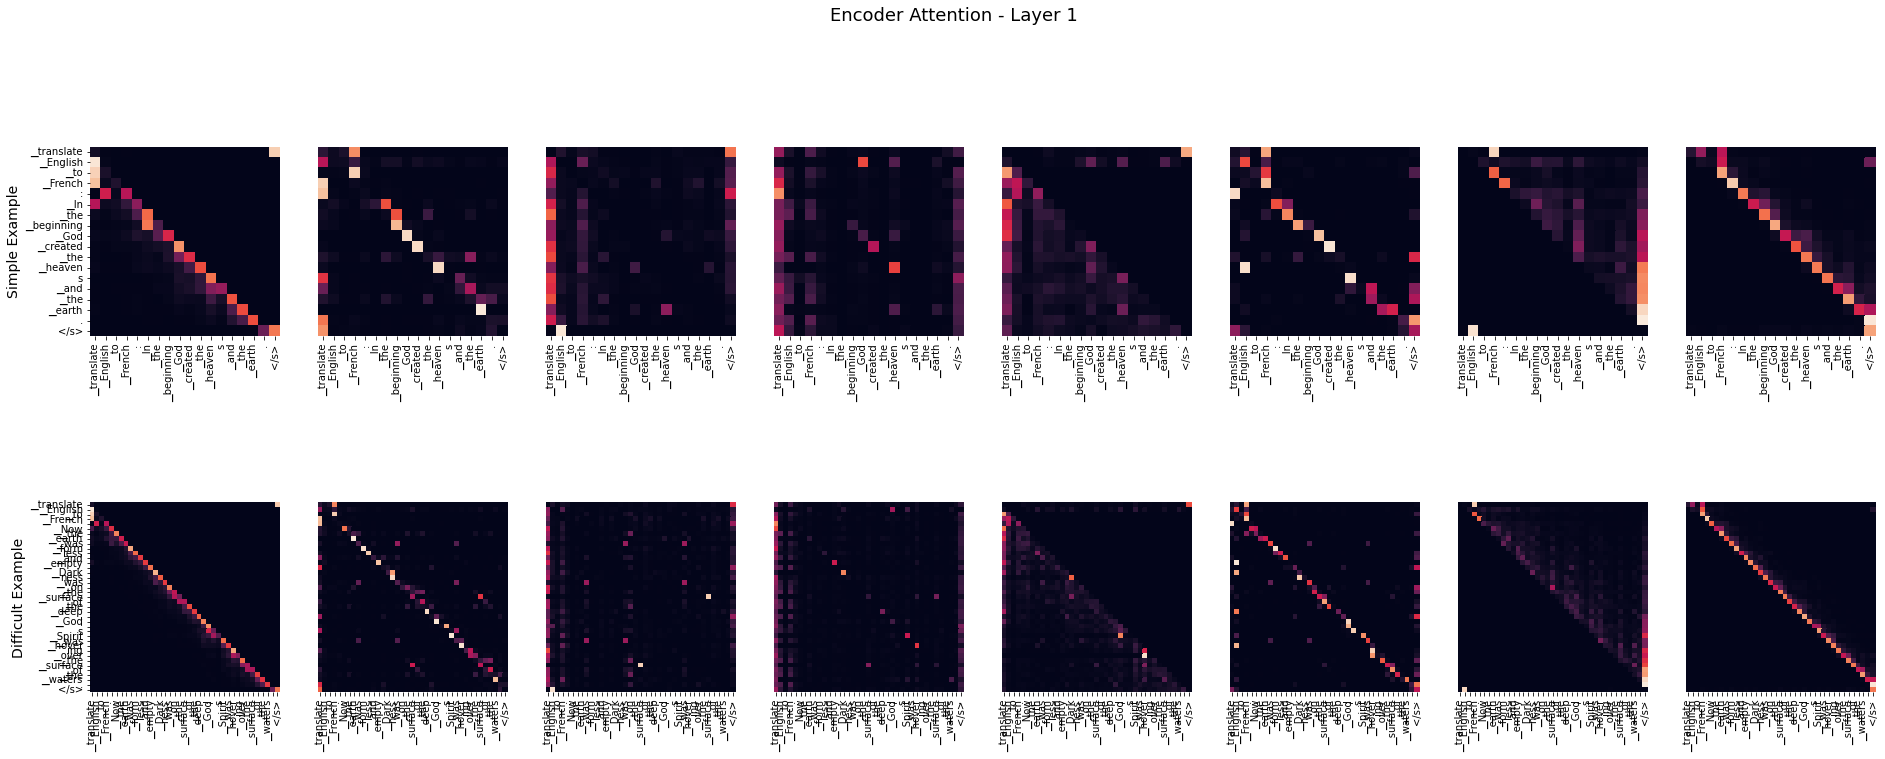

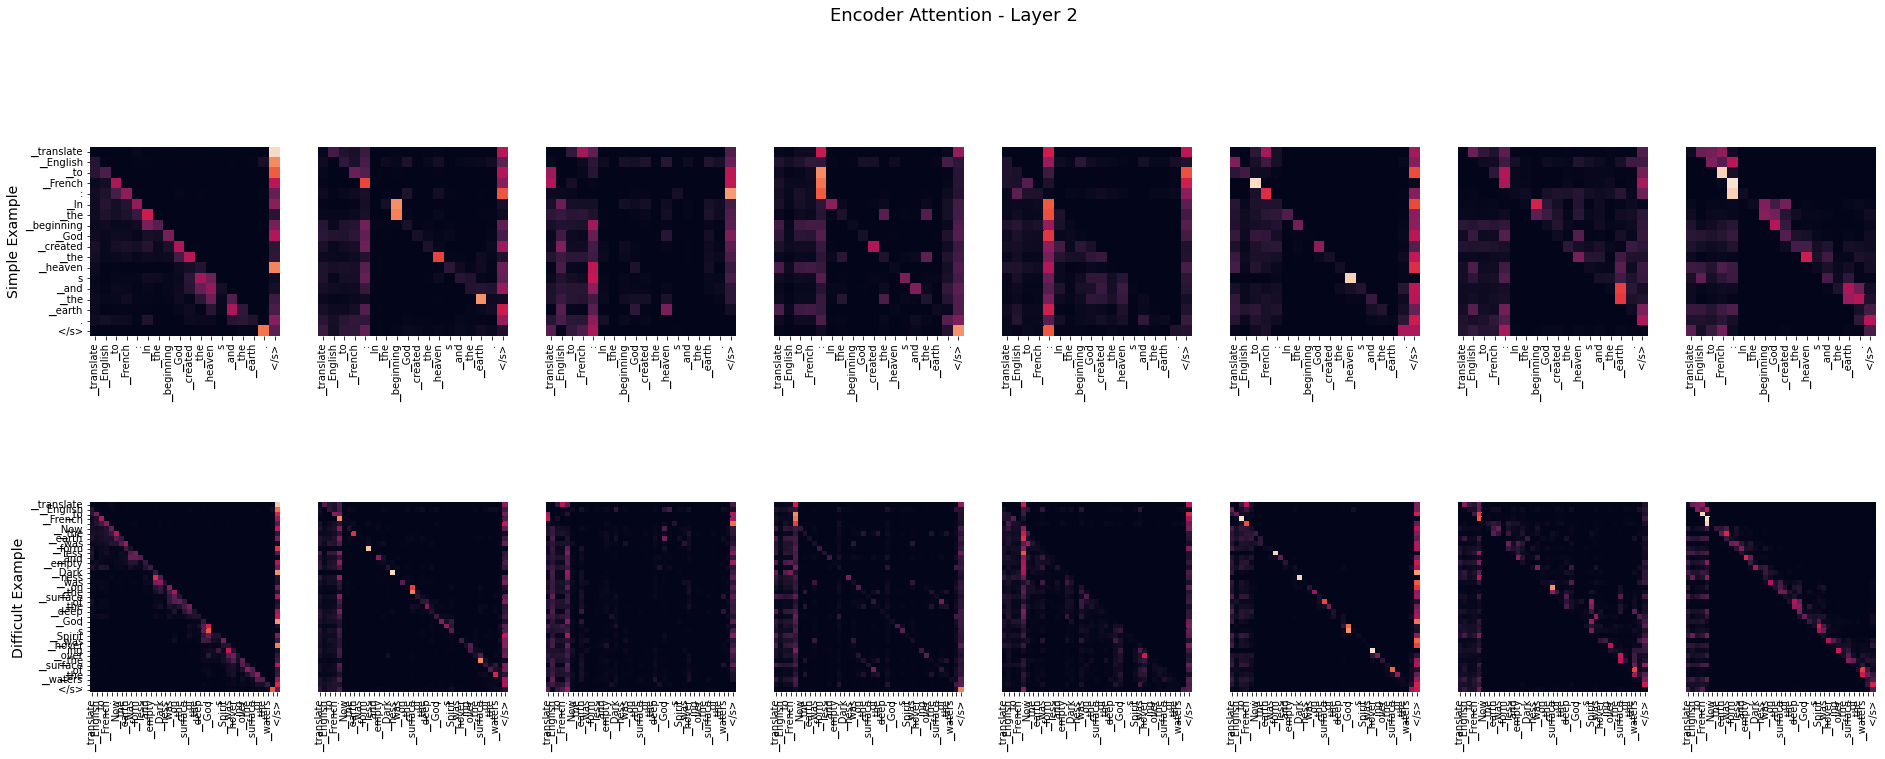

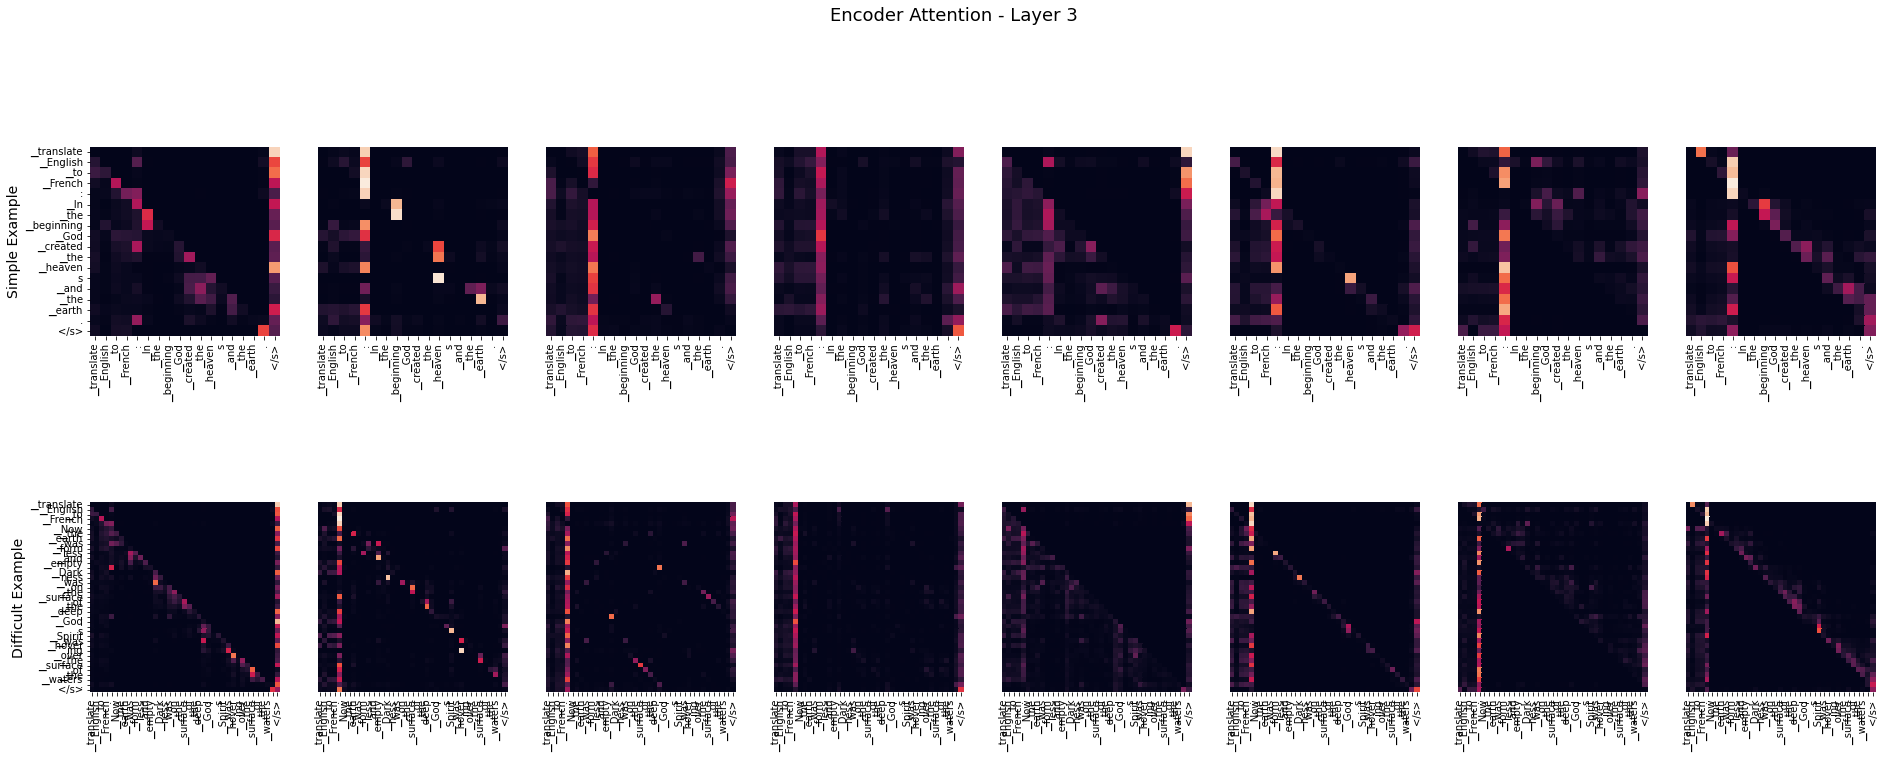

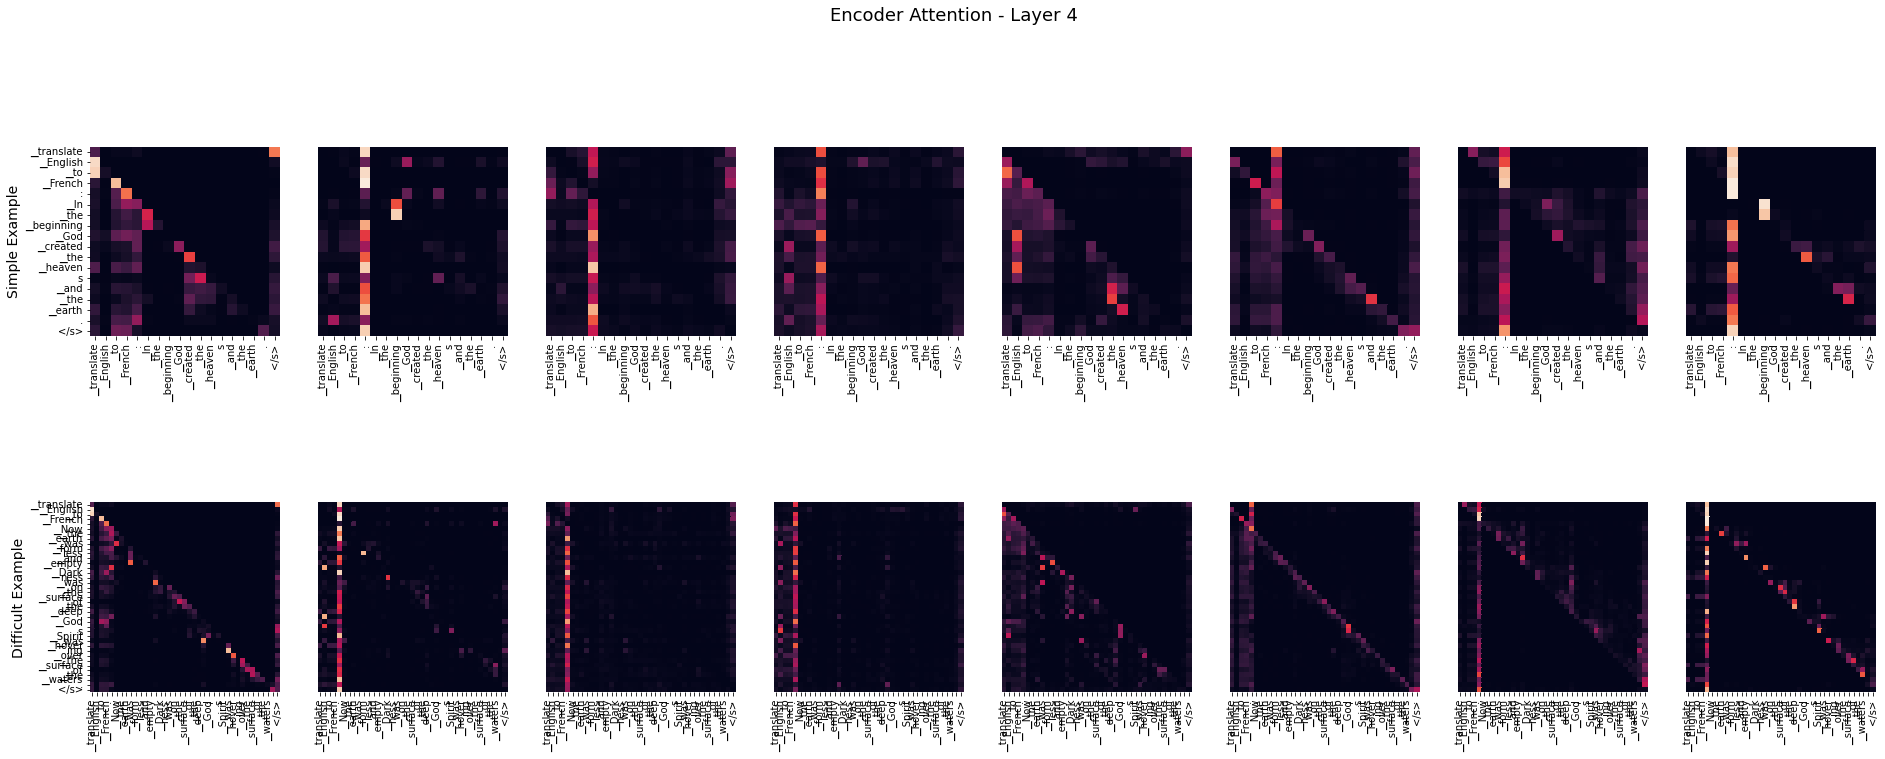

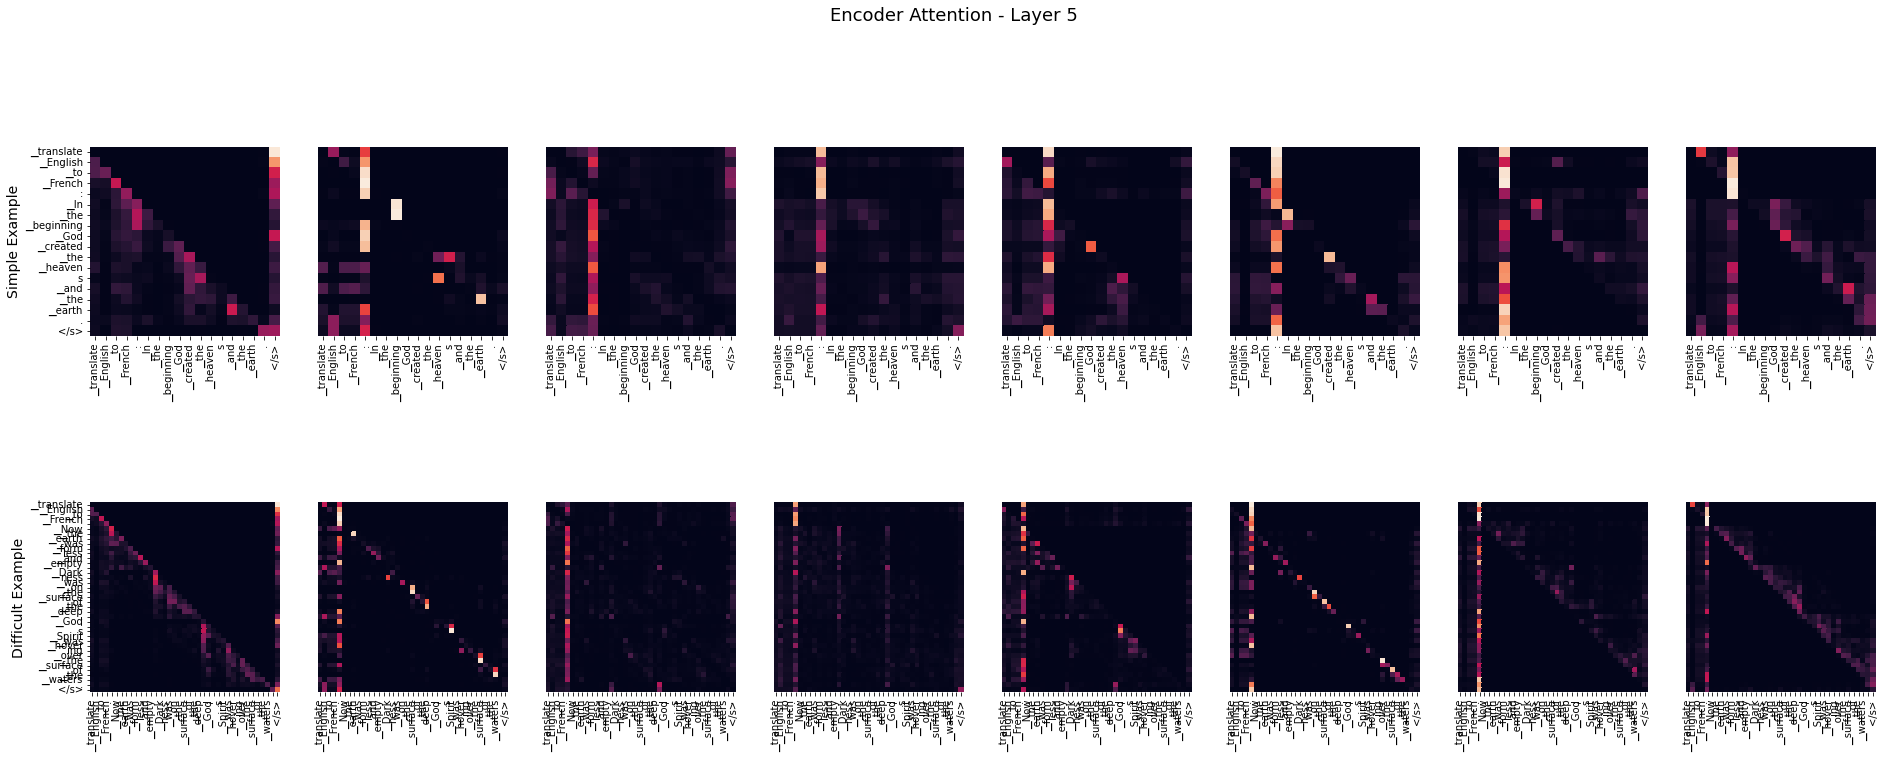

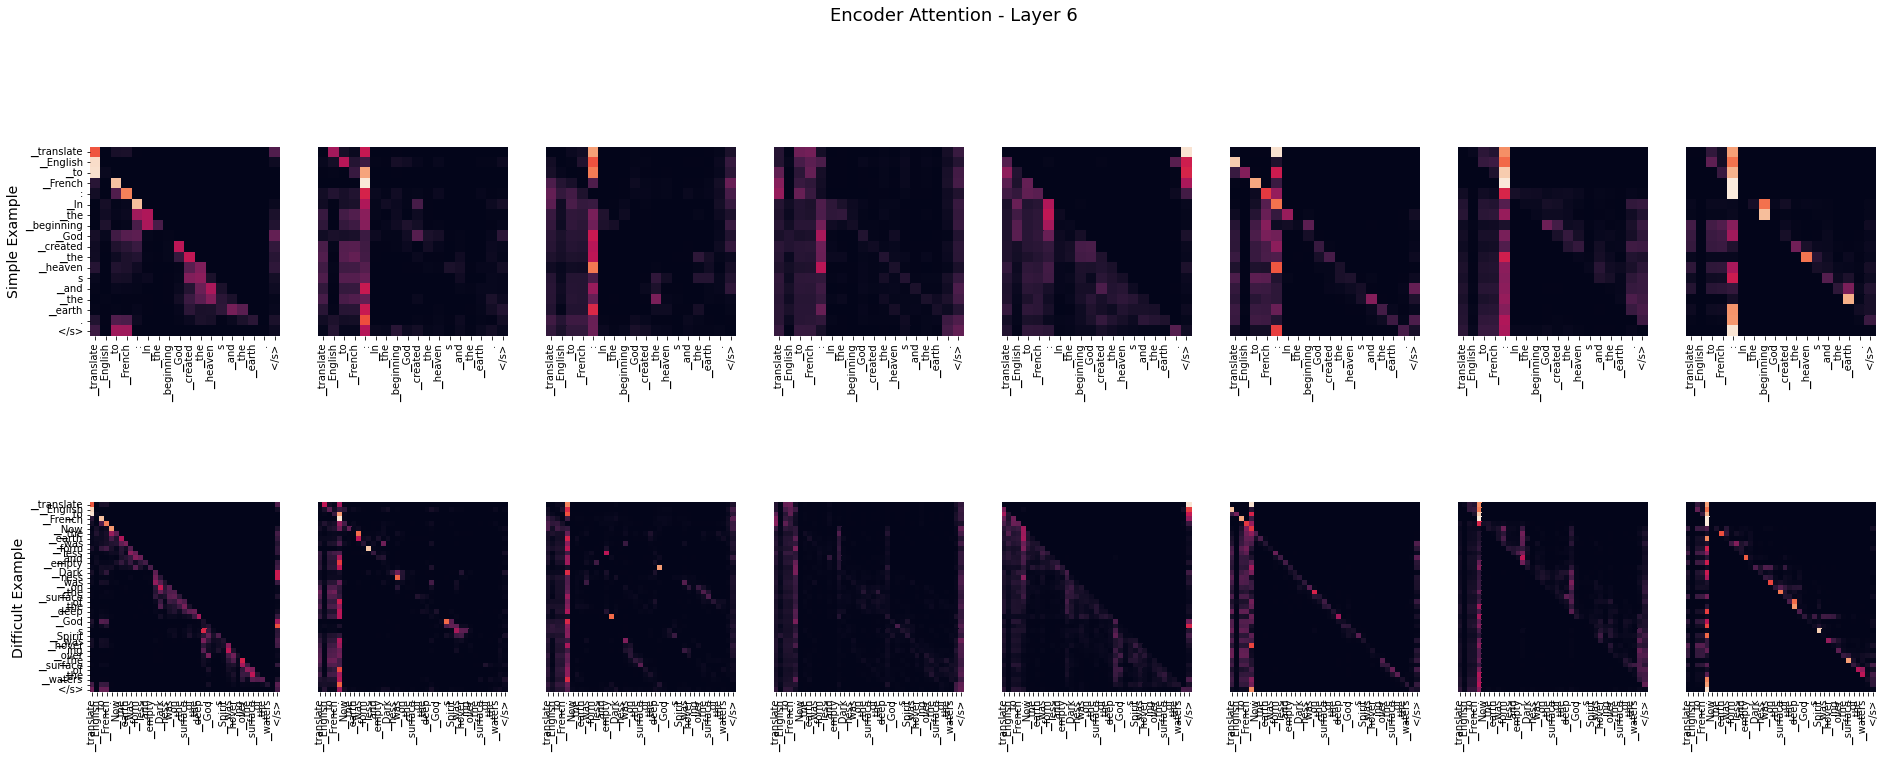

In [ ]:
# Plot encoder attention heads
for i in range(len(encoder_att_s)):
    layer_s = encoder_att_s[i]
    layer_d = encoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Encoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), input_tokens_s, input_tokens_s if j==0 else [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), input_tokens_d, input_tokens_d if j==0 else [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

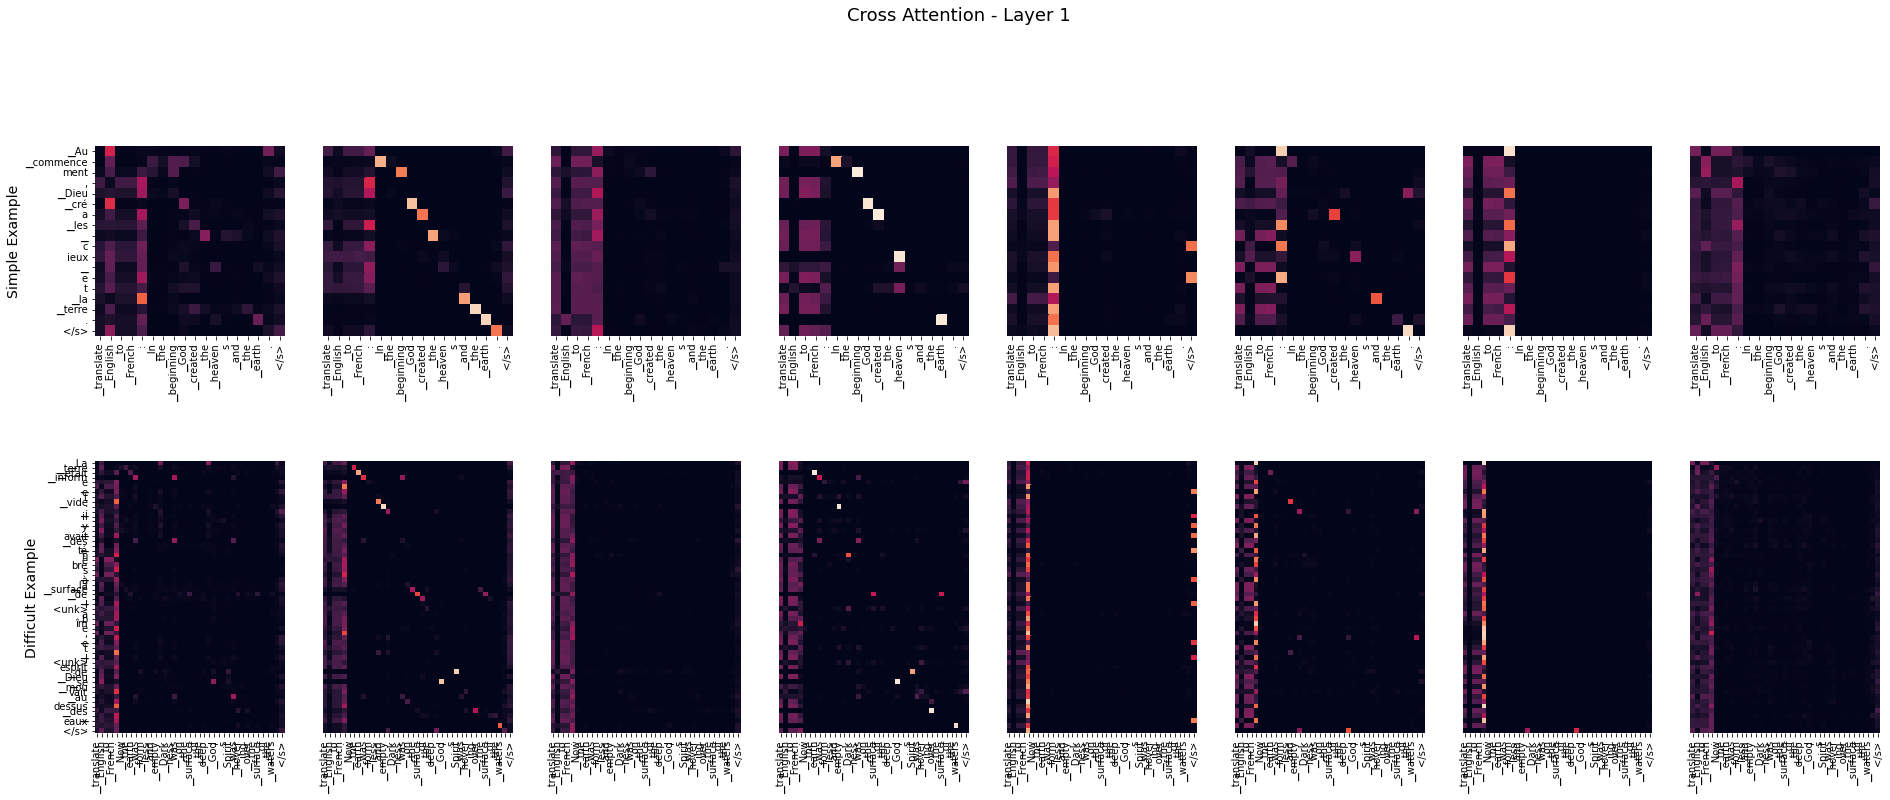

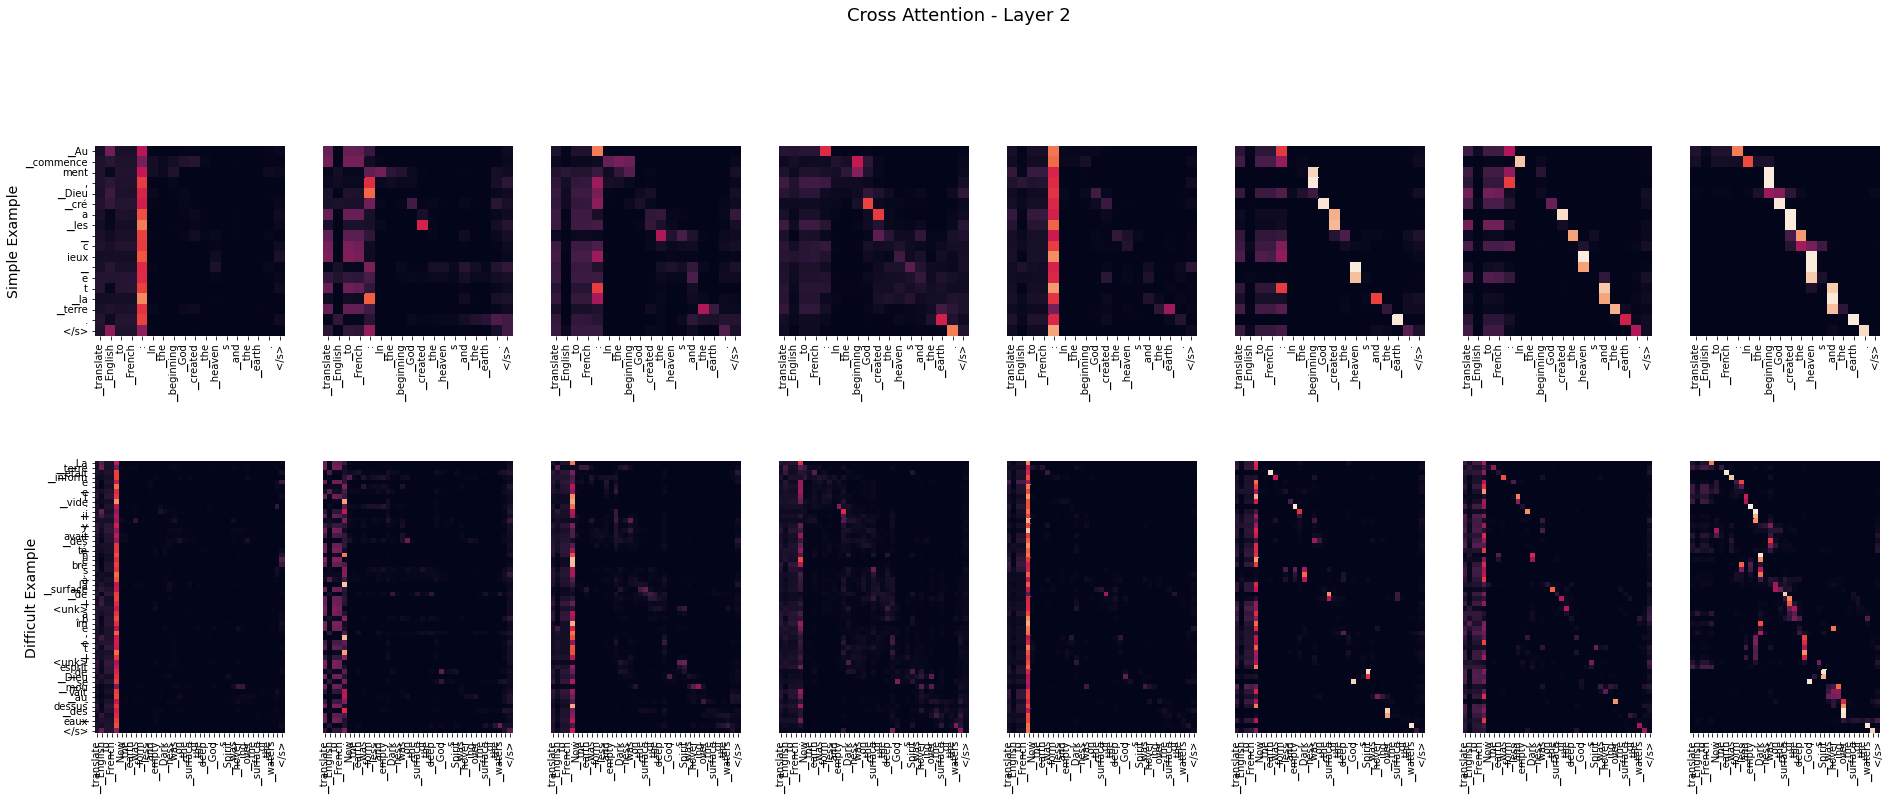

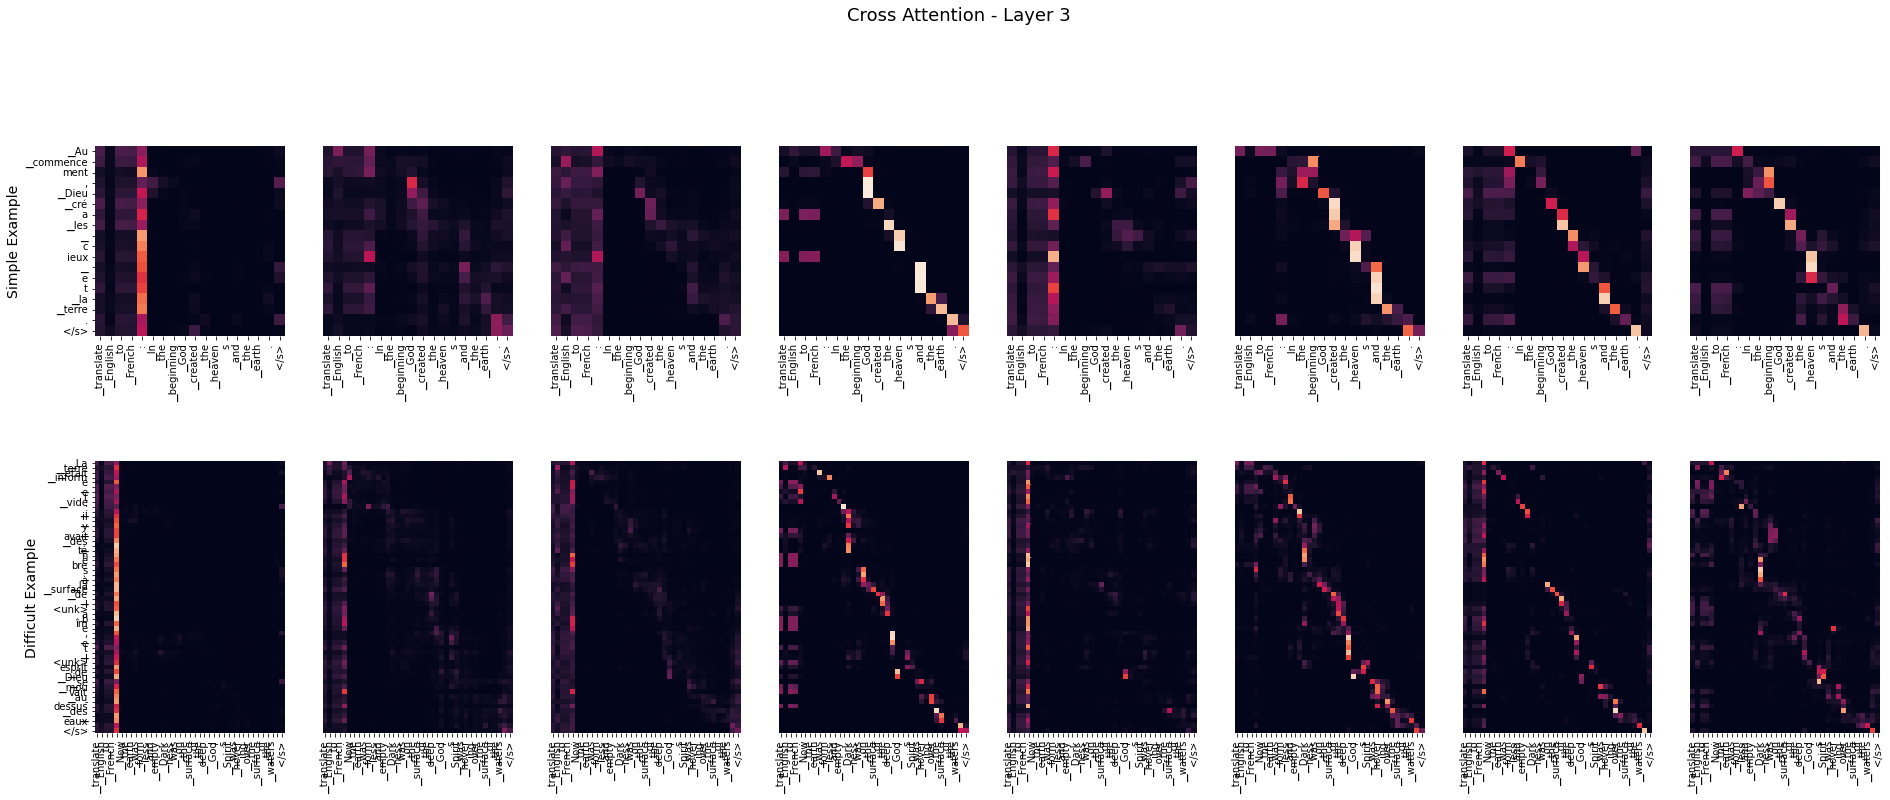

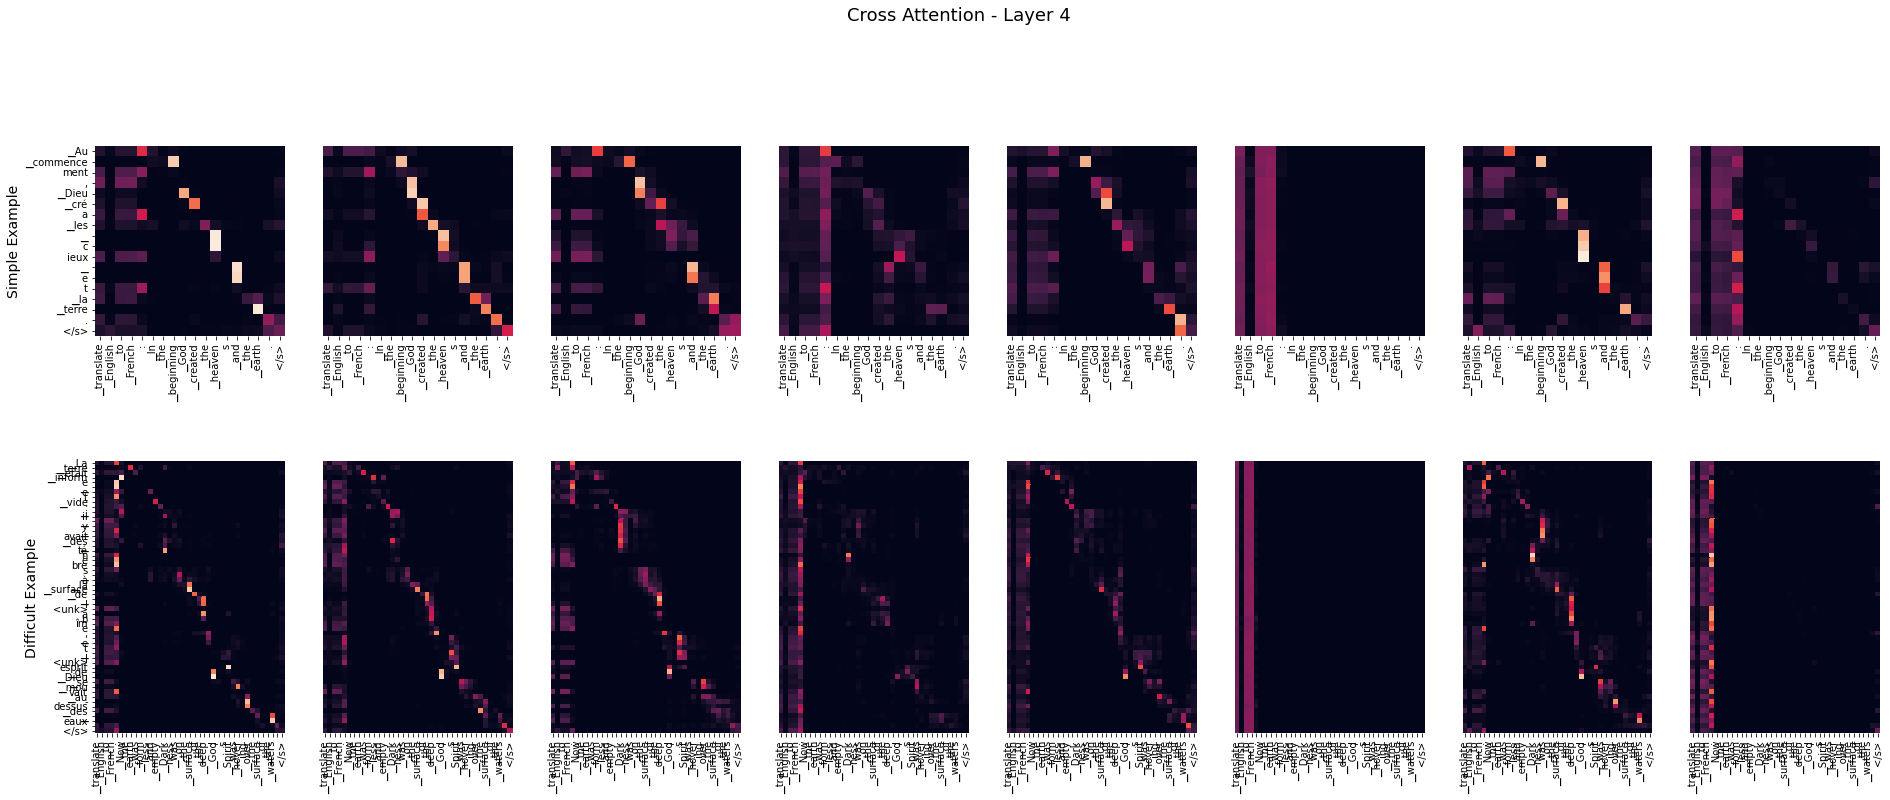

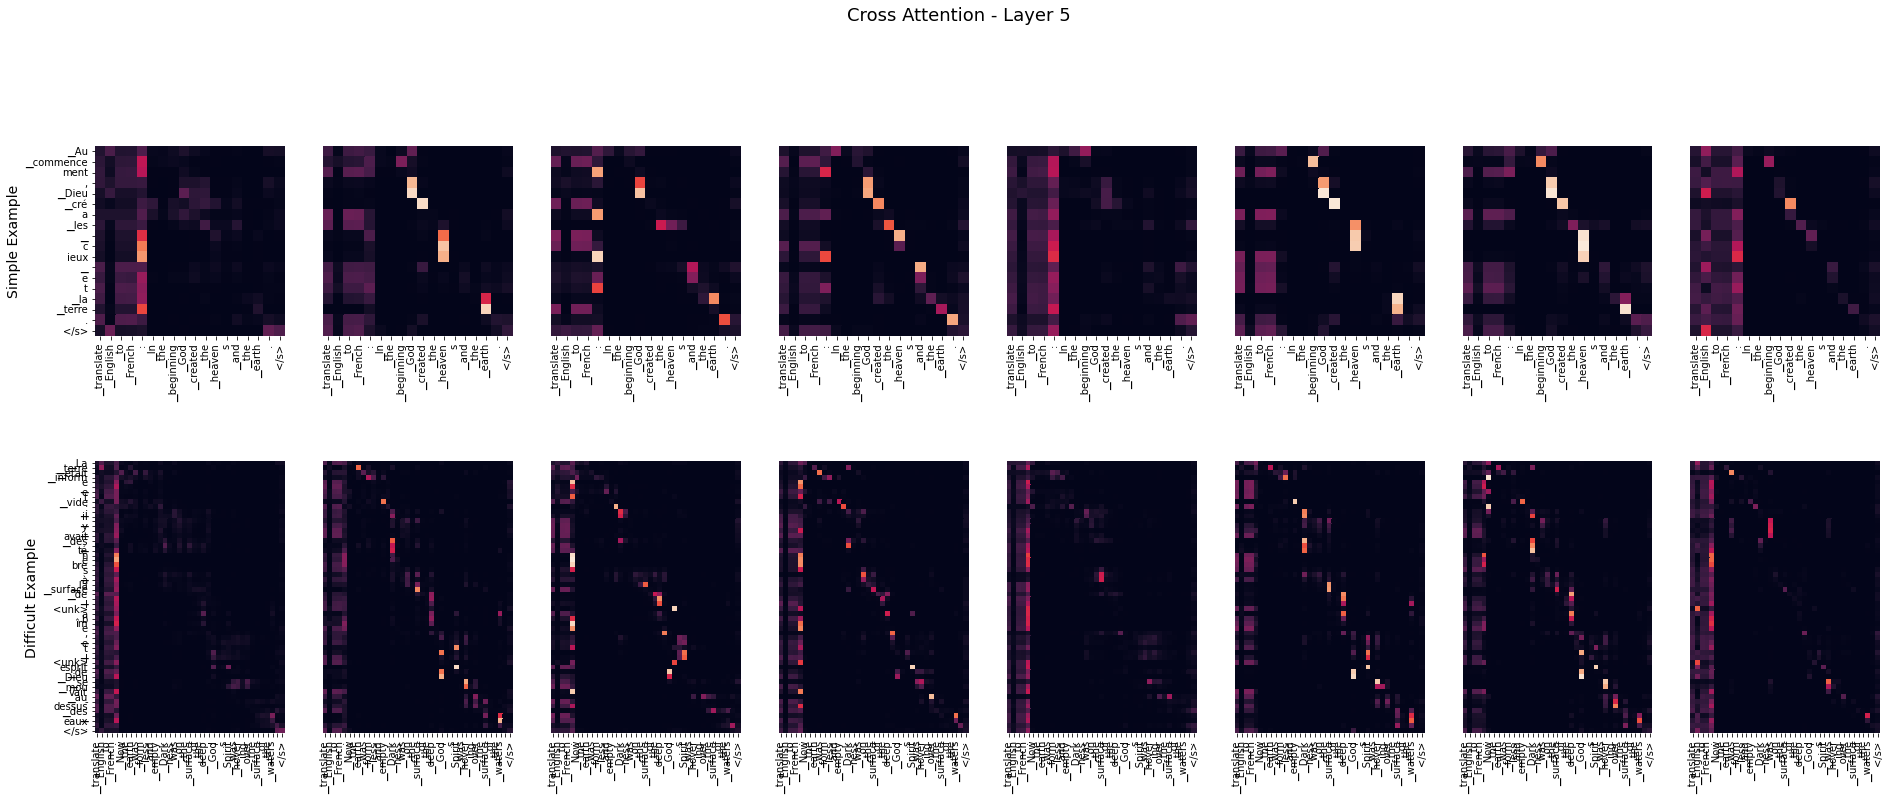

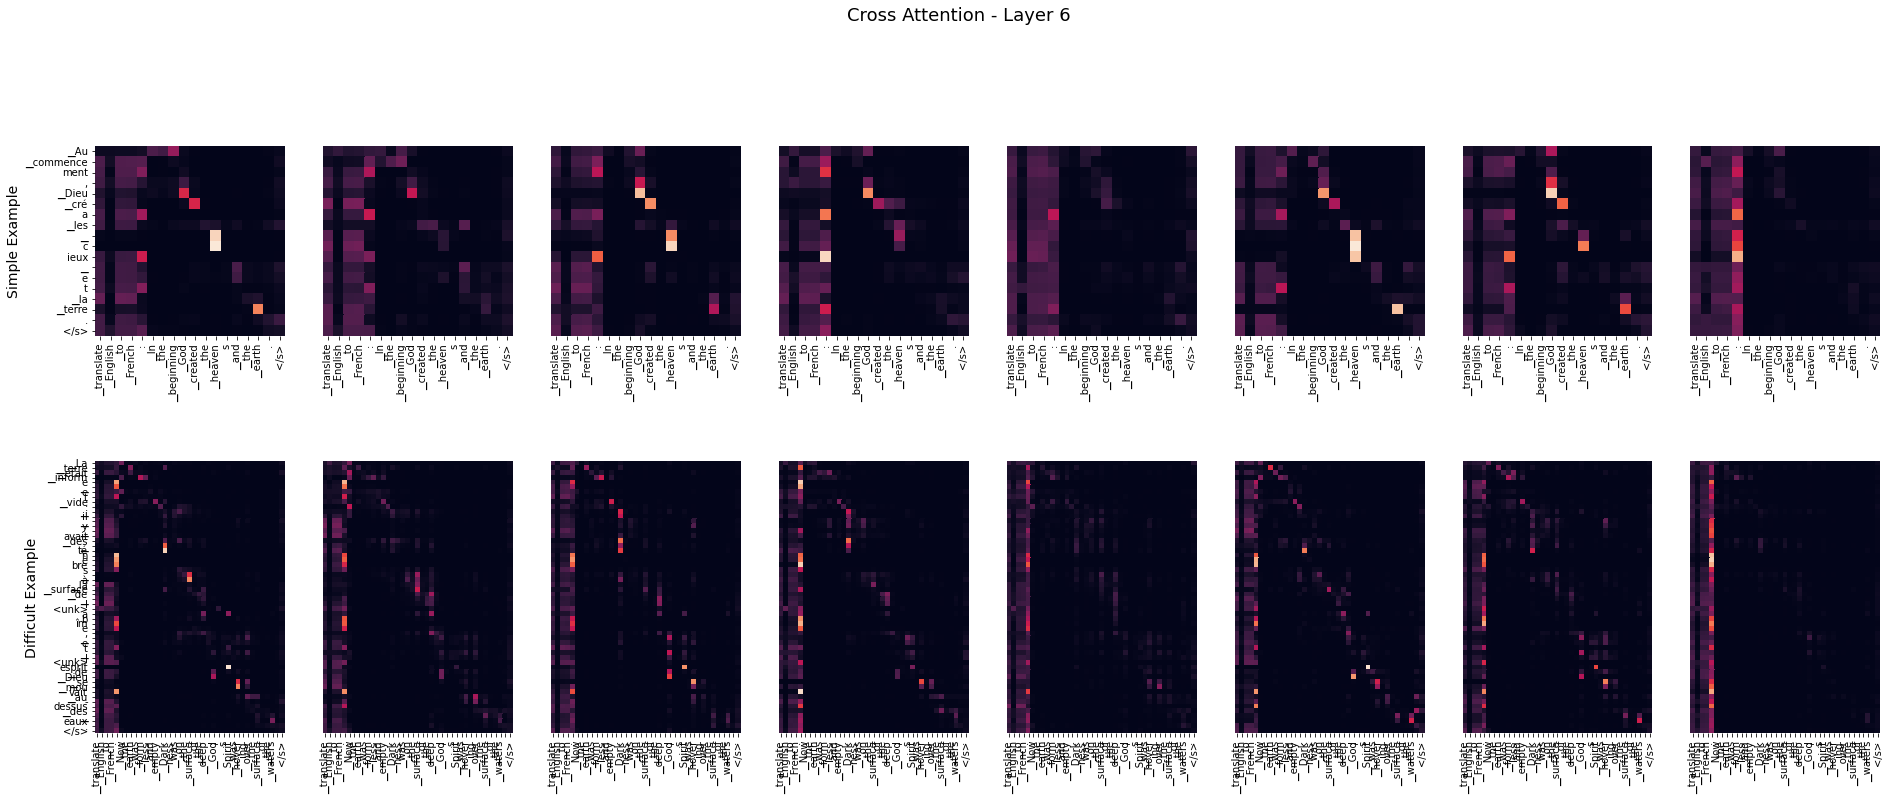

In [ ]:
# Plot cross attention heads
for i in range(len(cross_att_s)):
    layer_s = cross_att_s[i]
    layer_d = cross_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Cross Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), input_tokens_s, output_tokens_s if j==0 else [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), input_tokens_d, output_tokens_d if j==0 else [], axs[1,j])

    
    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

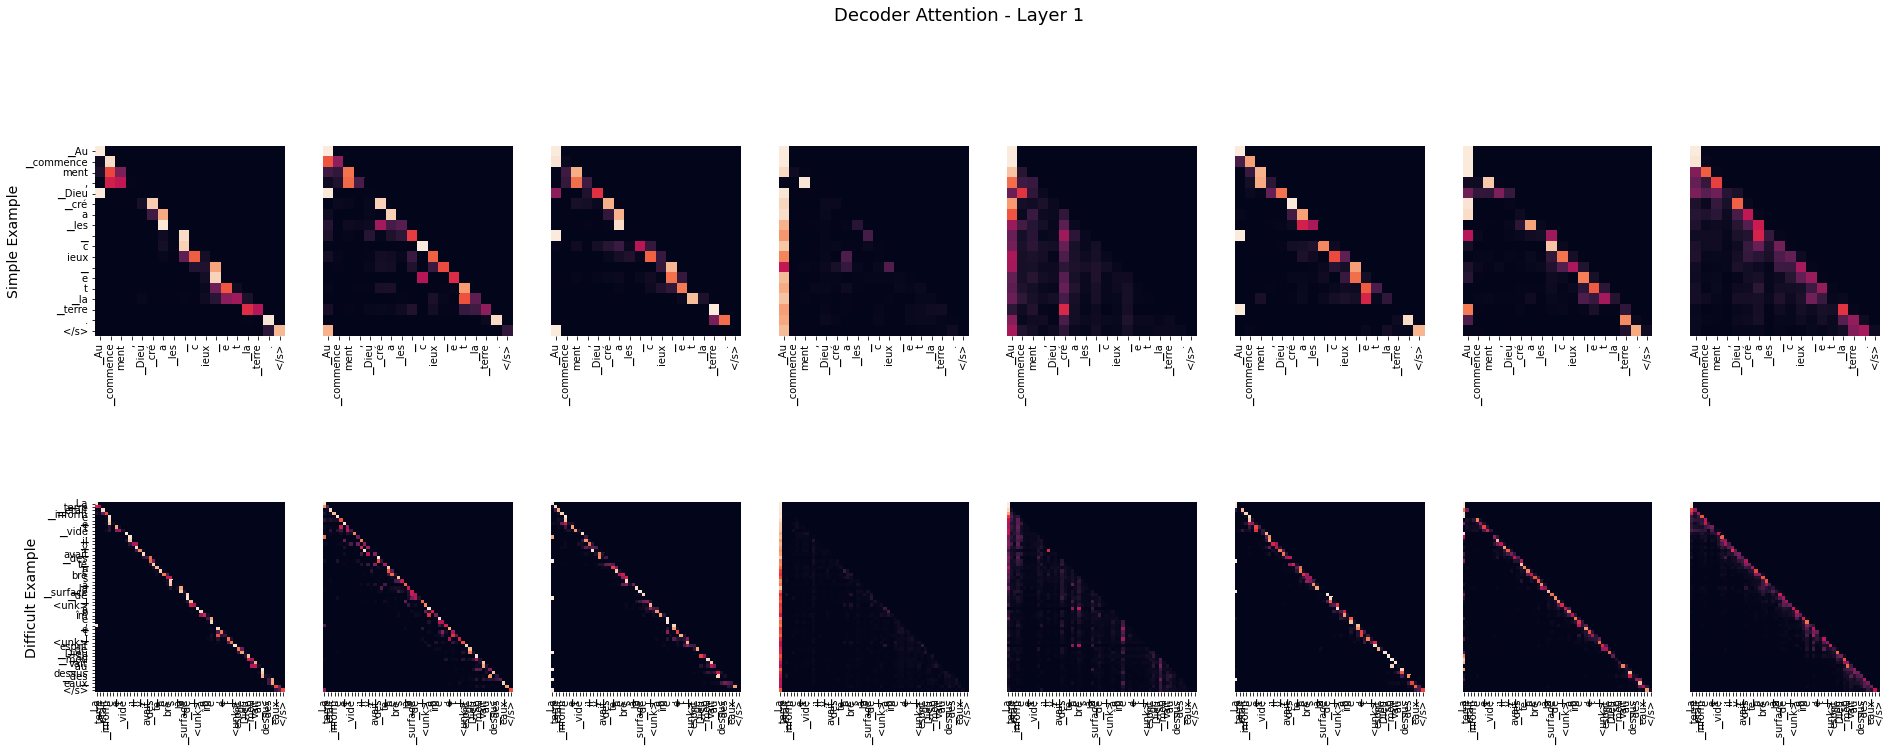

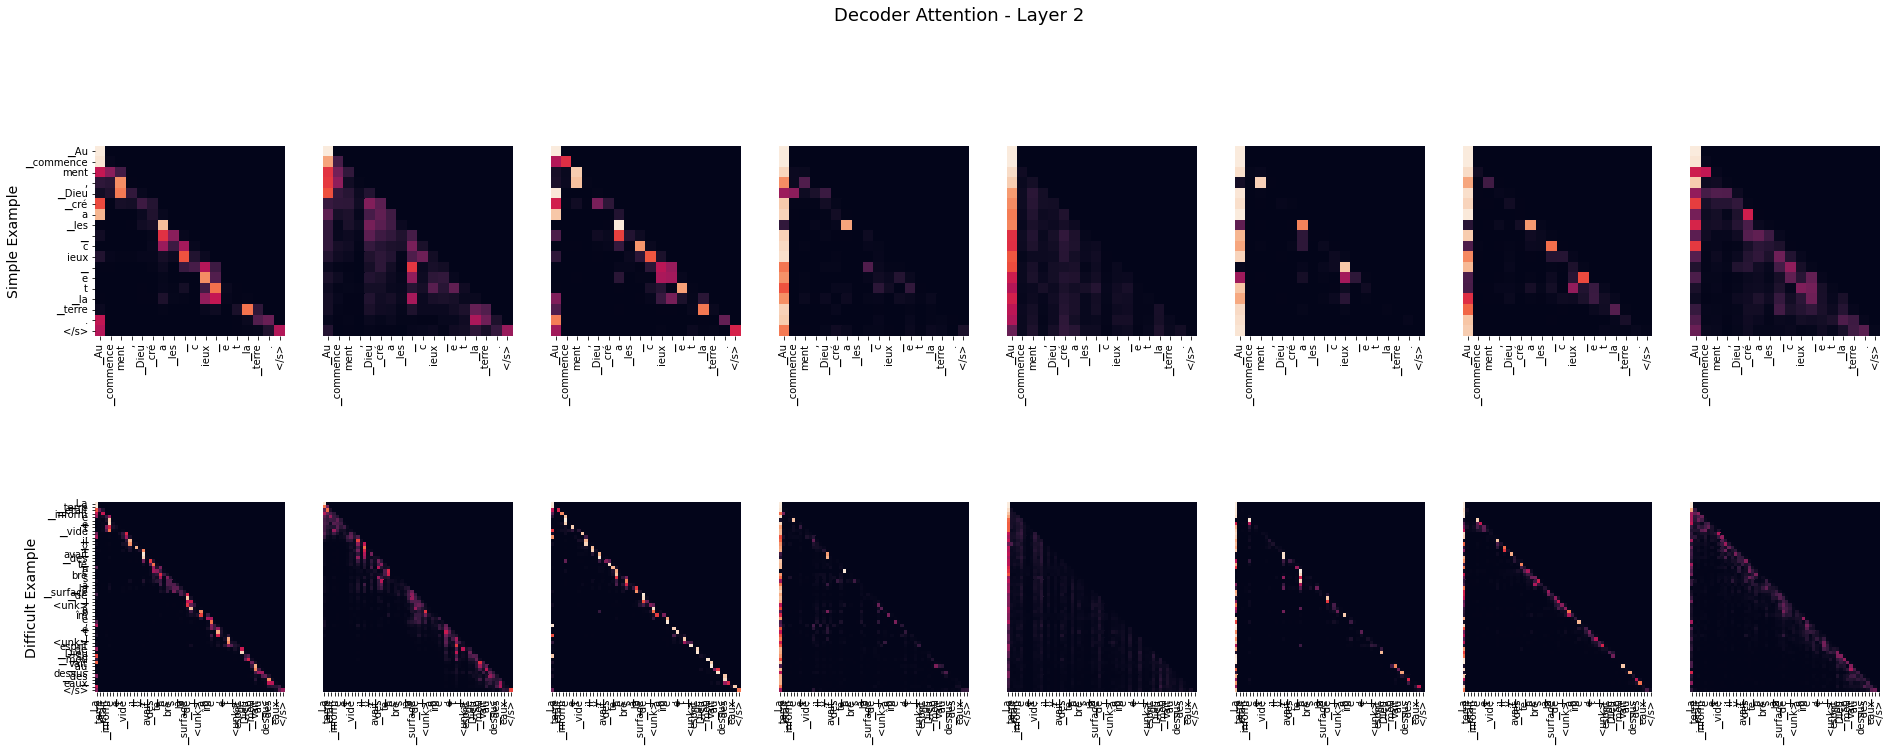

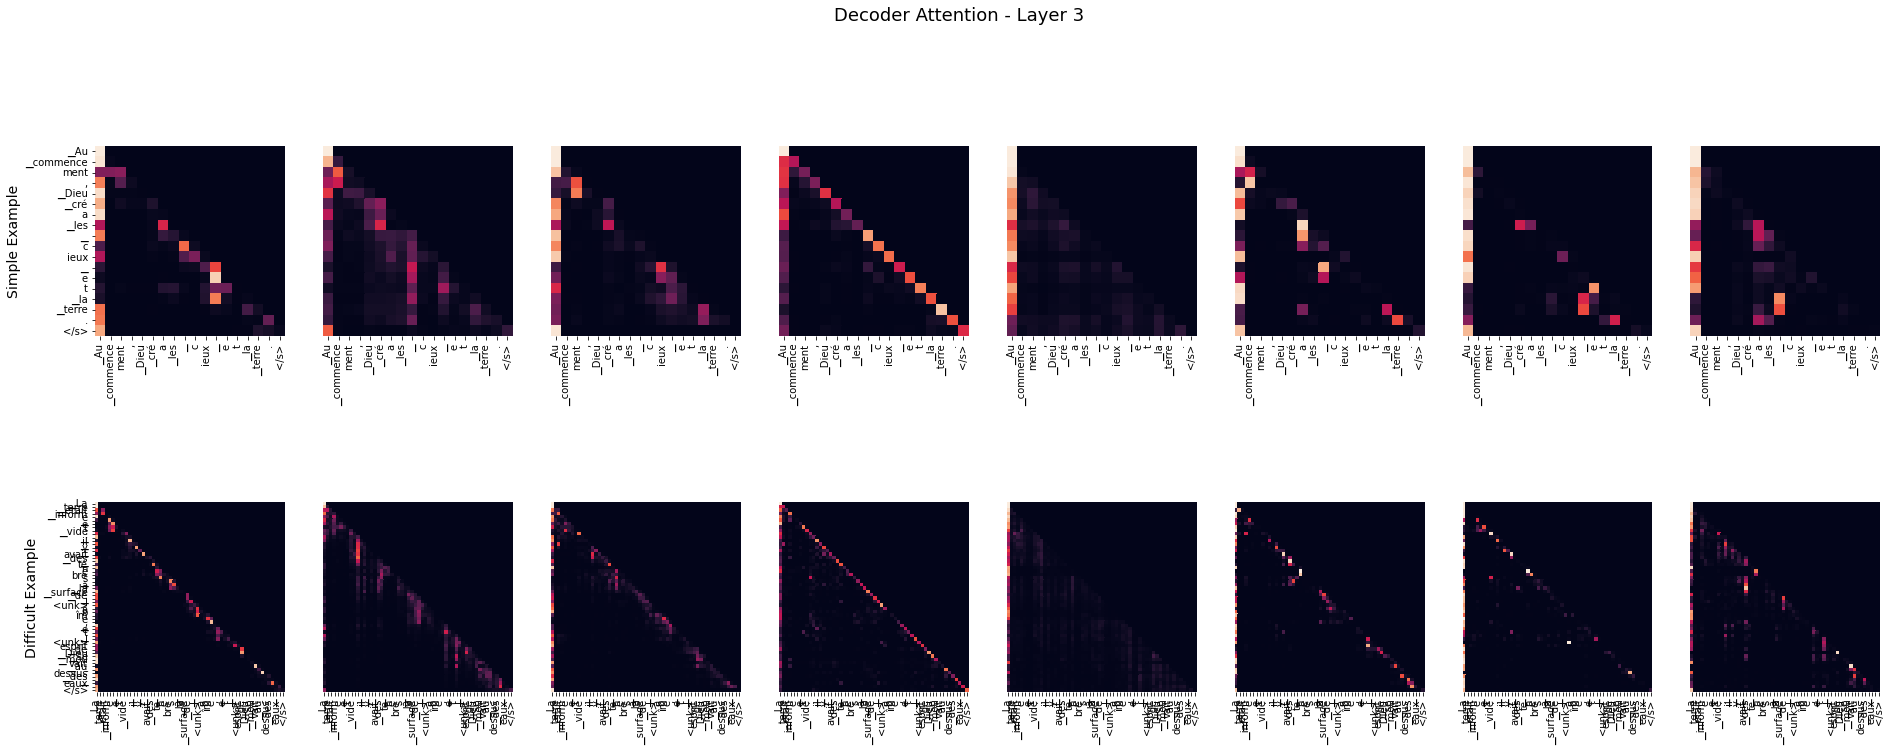

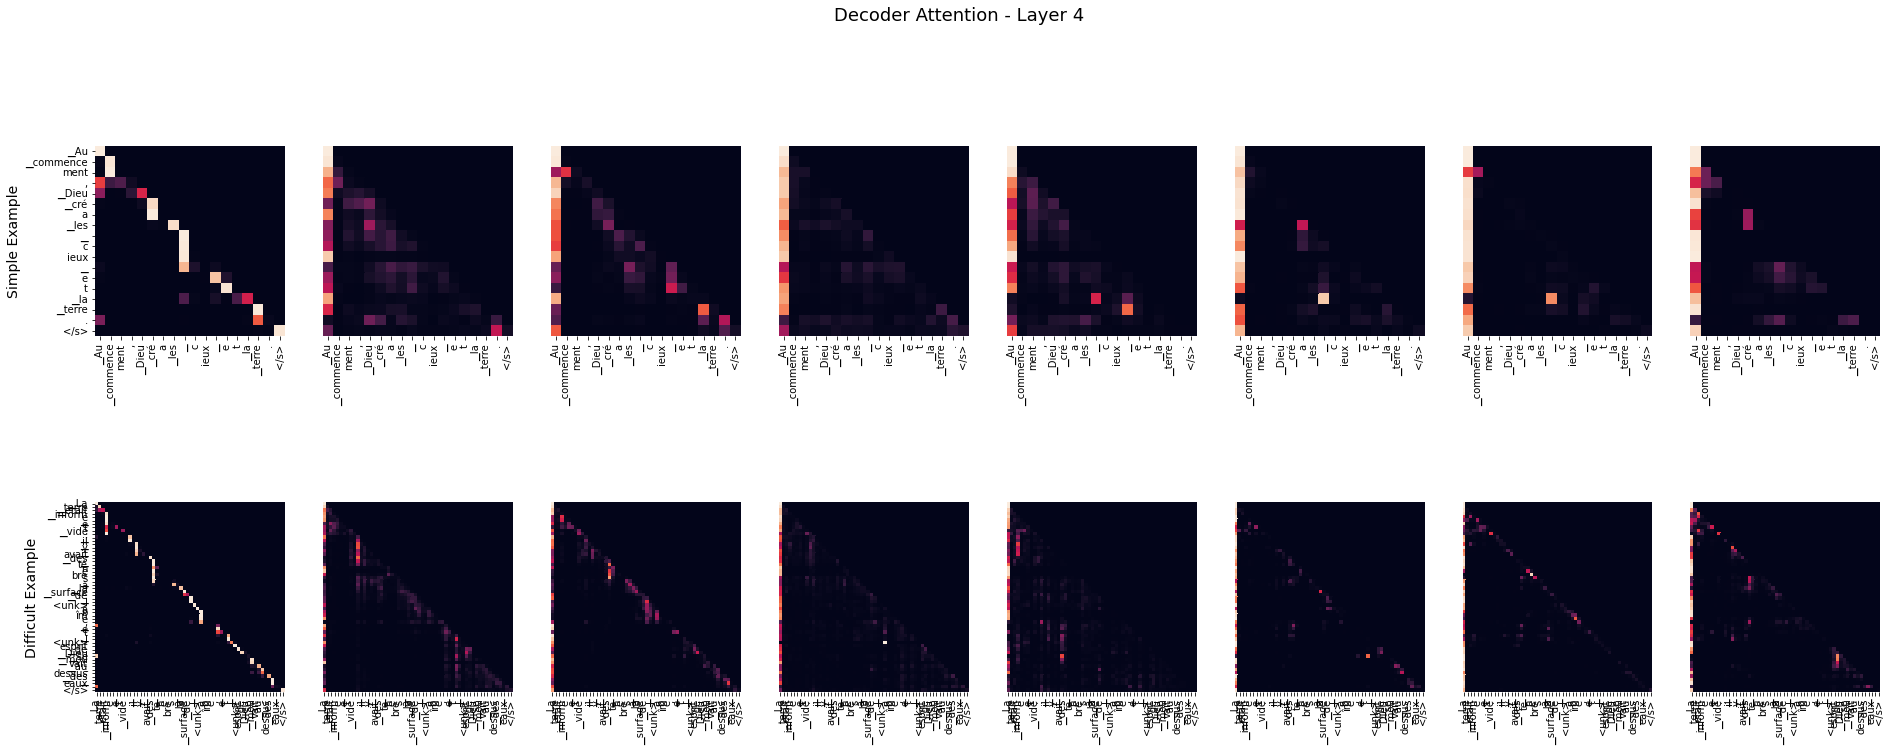

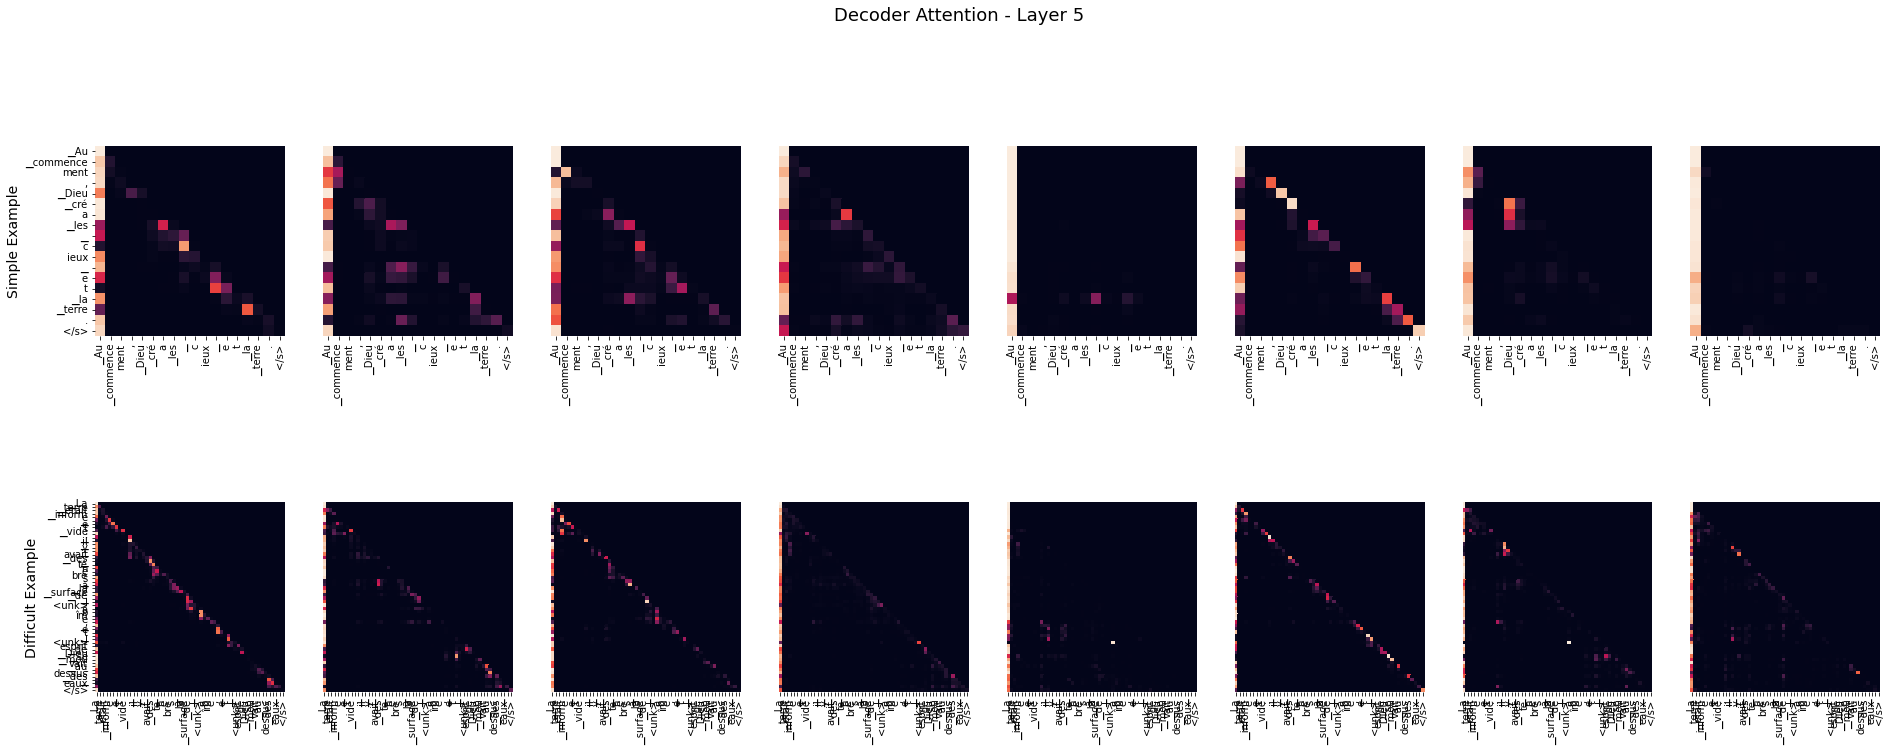

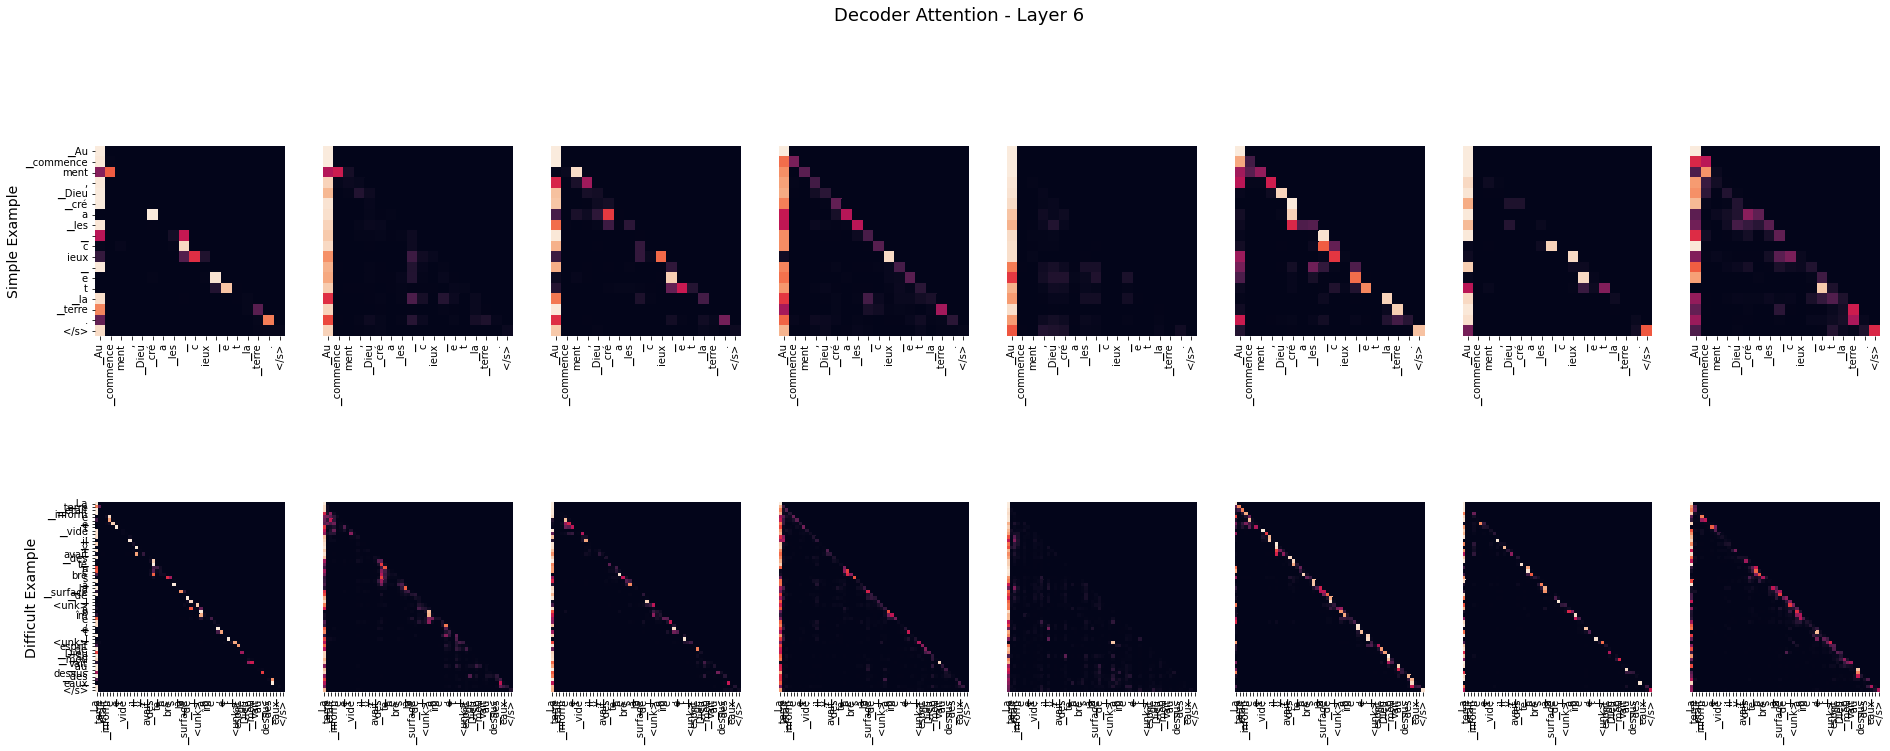

In [ ]:
# Plot decoder attention heads
for i in range(len(cross_att_s)):
    layer_s = decoder_att_s[i]
    layer_d = decoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Decoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), output_tokens_s, output_tokens_s if j==0 else [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), output_tokens_d, output_tokens_d if j==0 else [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)

    plt.show()

We then aggregate all attention heads per layer.

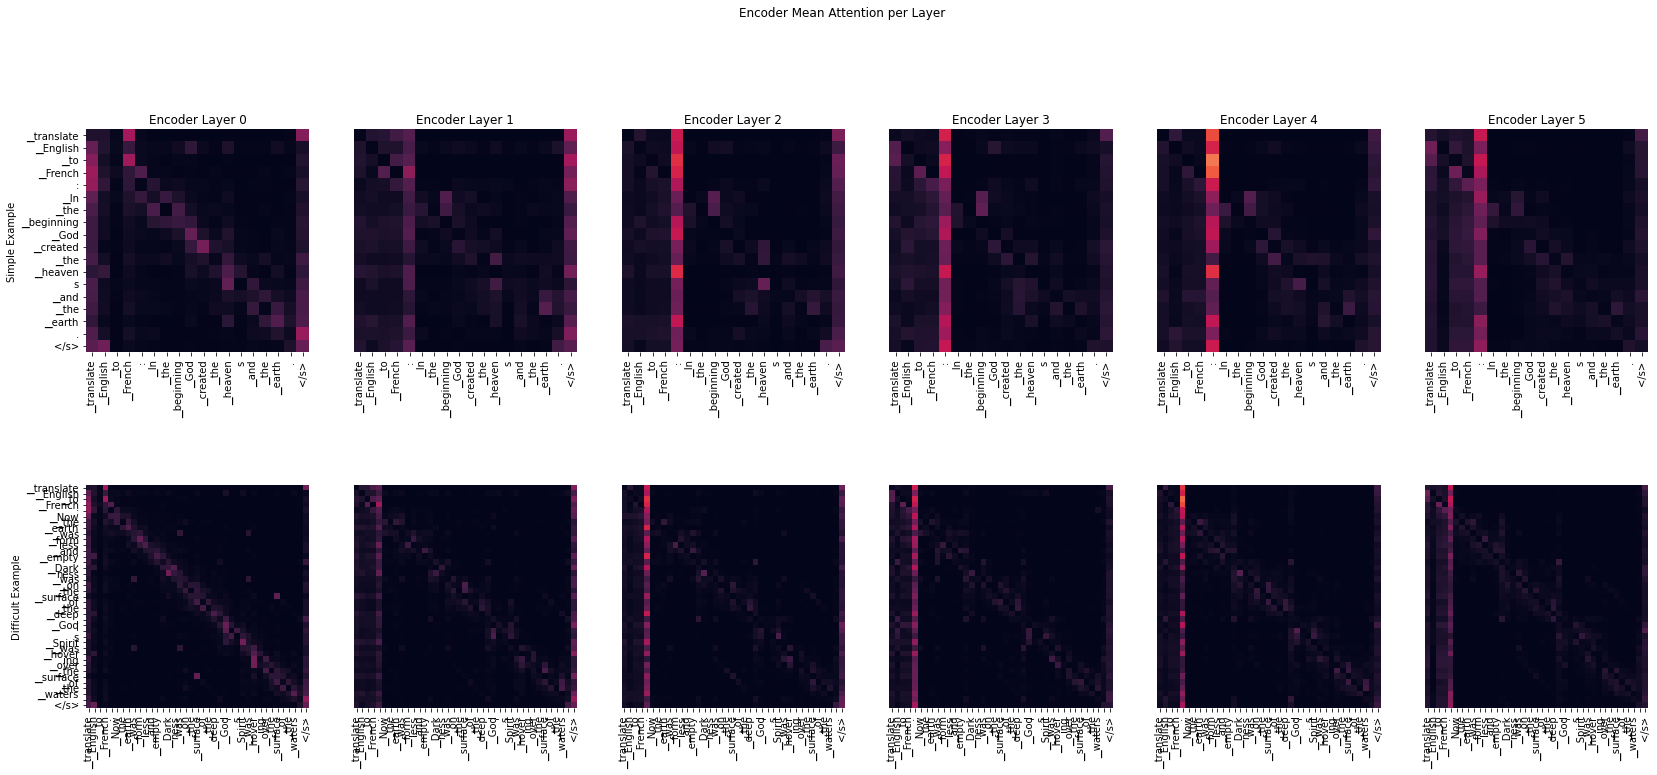

In [ ]:
# Plot encoder attention heads
fig, axs = plt.subplots(2,len(encoder_att_s),figsize=(28,12))
fig.suptitle("Encoder Mean Attention per Layer")

for i in range(len(encoder_att_s)):
    axs[0,i].set_title("Encoder Layer {}".format(i))

    draw(torch.mean(encoder_att_s[i][0,:,:,:], dim=0).cpu().detach(), input_tokens_s, input_tokens_s if i==0 else [], axs[0,i])
    draw(torch.mean(encoder_att_d[i][0,:,:,:], dim=0).cpu().detach(), input_tokens_d, input_tokens_d if i==0 else [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

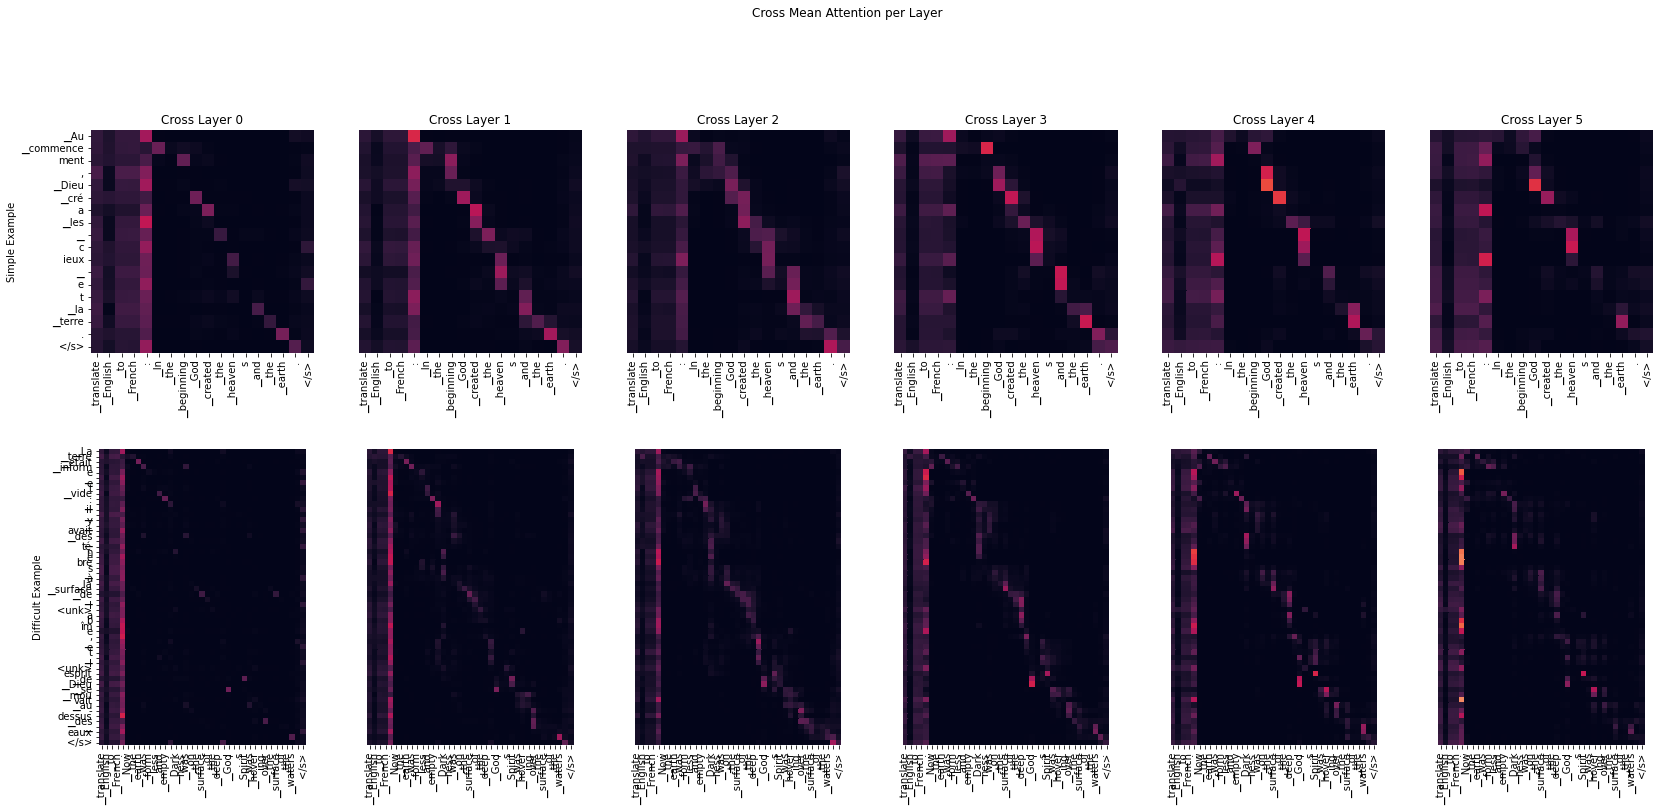

In [ ]:
# Plot cross attention heads
fig, axs = plt.subplots(2,len(cross_att_s),figsize=(28,12))
fig.suptitle("Cross Mean Attention per Layer")

for i in range(len(cross_att_s)):
    axs[0,i].set_title("Cross Layer {}".format(i))

    draw(torch.mean(cross_att_s[i][0,:,:,:], dim=0).cpu().detach(), input_tokens_s, output_tokens_s if i==0 else [], axs[0,i])
    draw(torch.mean(cross_att_d[i][0,:,:,:], dim=0).cpu().detach(), input_tokens_d, output_tokens_d if i==0 else [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

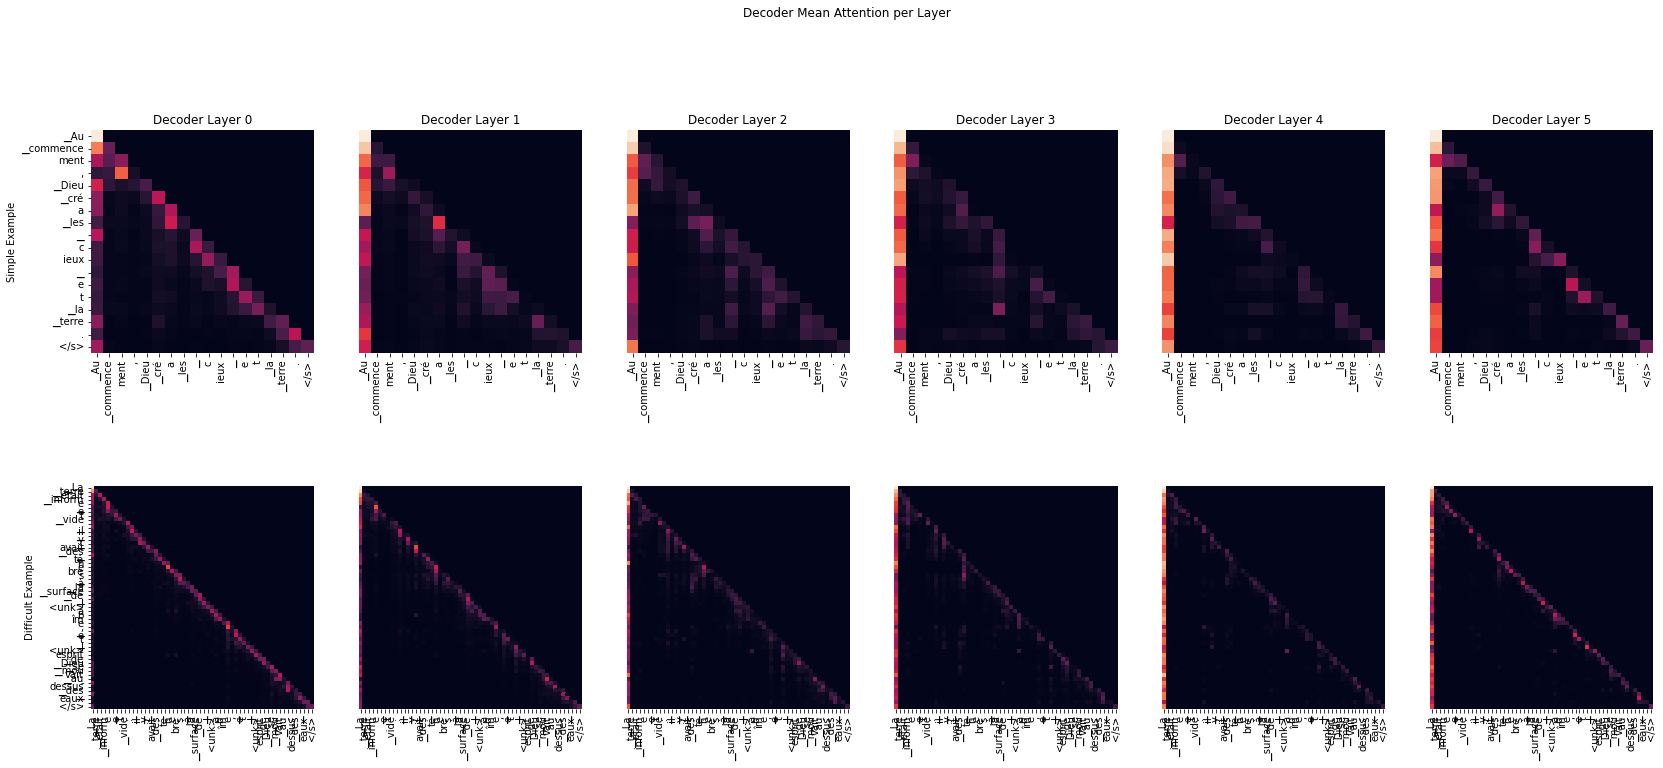

In [ ]:
# Plot decoder attention heads
fig, axs = plt.subplots(2,len(decoder_att_s),figsize=(28,12))
fig.suptitle("Decoder Mean Attention per Layer")

for i in range(len(decoder_att_s)):
    axs[0,i].set_title("Decoder Layer {}".format(i))

    draw(torch.mean(decoder_att_s[i][0,:,:,:], dim=0).cpu().detach(), output_tokens_s, output_tokens_s if i==0 else [], axs[0,i])
    draw(torch.mean(decoder_att_d[i][0,:,:,:], dim=0).cpu().detach(), output_tokens_d, output_tokens_d if i==0 else [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

We finally aggregate all attention heads over each layer of the encoder, decoder and cross heads. 

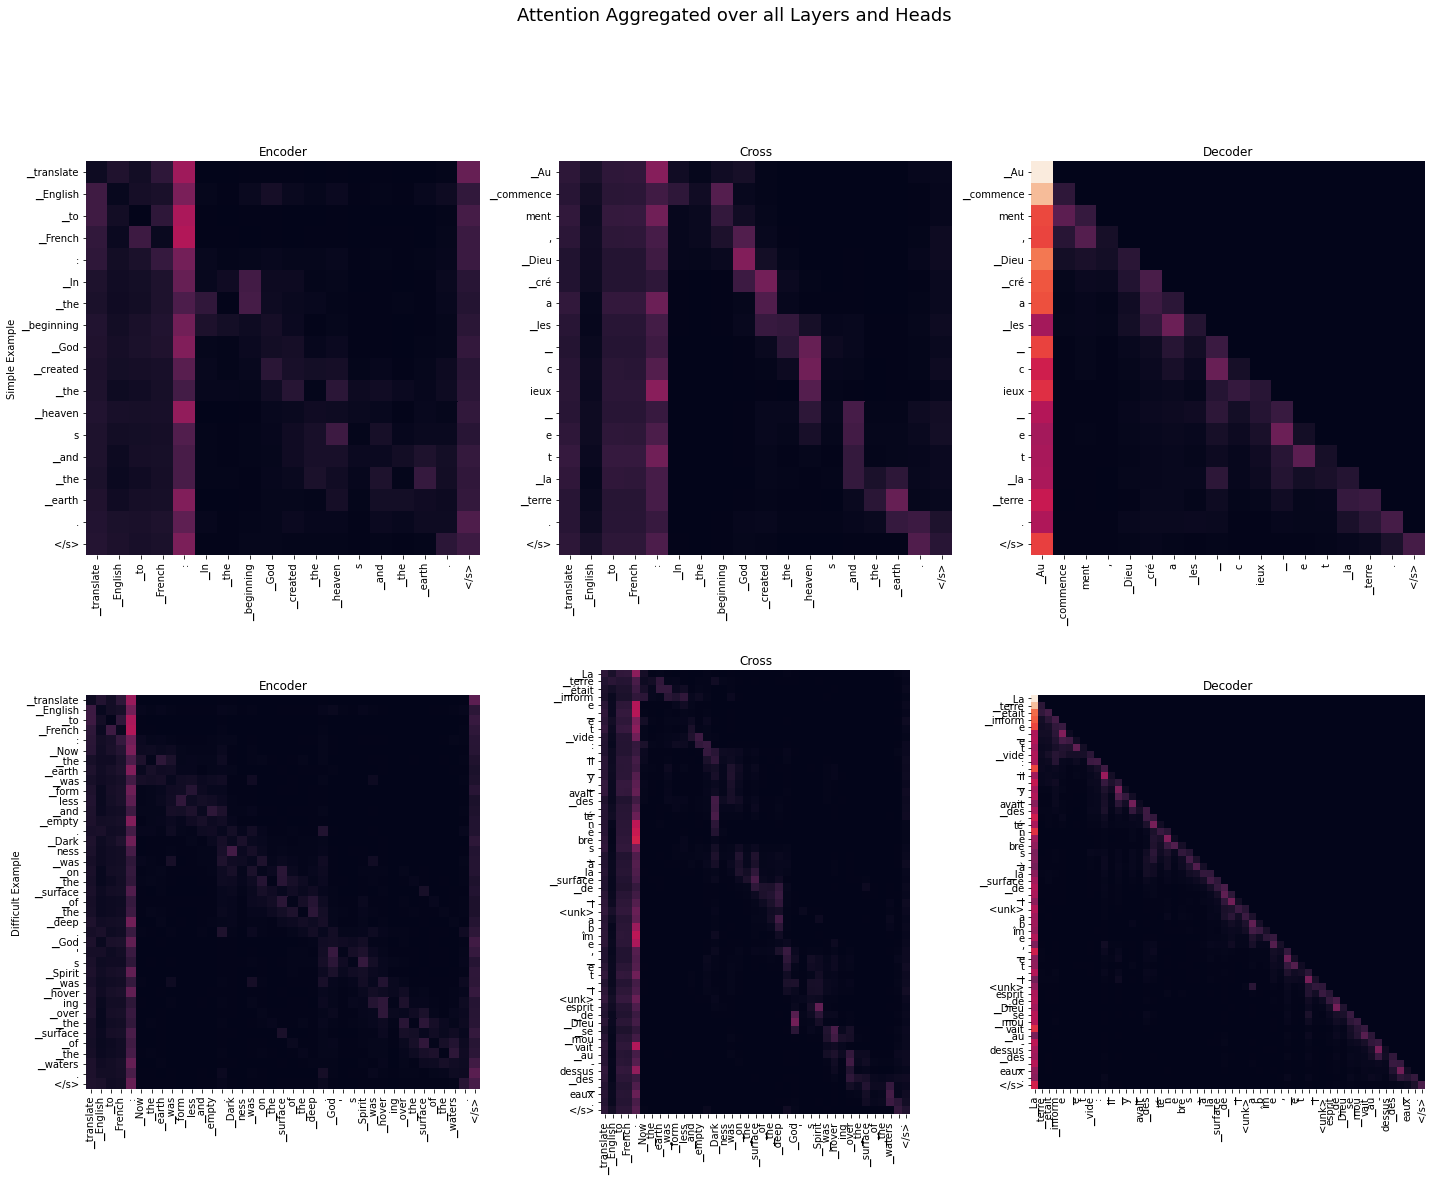

In [ ]:
# Aggregate attention heads over all layers and plot for encoder, cross and decoder
fig,axs = plt.subplots(2,3,figsize=(24,18))
fig.suptitle("Attention Aggregated over all Layers and Heads", fontsize=18)

# Simple Example
axs[0,0].set_title("Encoder")
draw(torch.mean(torch.cat([torch.squeeze(encoder_att_s[i]) for i in range(len(encoder_att_s))],dim=0), dim=0).cpu().detach(), input_tokens_s, input_tokens_s, axs[0,0])

axs[0,1].set_title("Cross")
draw(torch.mean(torch.cat([torch.squeeze(cross_att_s[i]) for i in range(len(cross_att_s))],dim=0), dim=0).cpu().detach(), input_tokens_s, output_tokens_s, axs[0,1])

axs[0,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_s[i]) for i in range(len(decoder_att_s))],dim=0), dim=0).cpu().detach(), output_tokens_s, output_tokens_s, axs[0,2])

axs[0,0].set_ylabel("Simple Example")

# Difficult Example
axs[1,0].set_title("Encoder")
draw(torch.mean(torch.cat([torch.squeeze(encoder_att_d[i]) for i in range(len(encoder_att_d))],dim=0), dim=0).cpu().detach(), input_tokens_d, input_tokens_d, axs[1,0])

axs[1,1].set_title("Cross")
draw(torch.mean(torch.cat([torch.squeeze(cross_att_d[i]) for i in range(len(cross_att_d))],dim=0), dim=0).cpu().detach(), input_tokens_d, output_tokens_d, axs[1,1])

axs[1,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_d[i]) for i in range(len(decoder_att_d))],dim=0), dim=0).cpu().detach(), output_tokens_d, output_tokens_d, axs[1,2])

axs[1,0].set_ylabel("Difficult Example")

plt.show()

### Summarization Task

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')


#splitting the dataset.
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']


#task to be done.
task_prefix = 'summarize: '

# in this example we will use only one batch containing 5 examples.
batch_input = [task_prefix + sequence for sequence in test_dataset['article'][:5]]
batch_output = test_dataset['highlights'][:5]

Downloading:   0%|          | 0.00/9.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/661k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f. Subsequent calls will reuse this data.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Simple and difficult examples are selected according to the length of the text.

In [ ]:
# Select simple sample
i = 3

# Tokenize input sample and compute tokens from ids
input_s = tokenizer(batch_input[i], return_tensors="pt").to(device)
label_s = tokenizer(batch_output[i], return_tensors="pt").to(device)
input_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(input_s['input_ids']))
output_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(label_s['input_ids']))

# Pass through model and return attention heads
output_s = model(input_ids=input_s['input_ids'], labels=label_s['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_s = output_s['encoder_attentions']
cross_att_s = output_s['cross_attentions']
decoder_att_s = output_s['decoder_attentions']

In [ ]:
# Select difficult sample
i = 2

# Tokenize input sample and compute tokens from ids
input_d = tokenizer(batch_input[i], return_tensors="pt").to(device)
label_d = tokenizer(batch_output[i], return_tensors="pt").to(device)
input_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(input_d['input_ids']))
output_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(label_d['input_ids']))

# Pass through model and return attention heads
output_d = model(input_ids=input_d['input_ids'], labels=label_d['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_d = output_d['encoder_attentions']
cross_att_d = output_d['cross_attentions']
decoder_att_d = output_d['decoder_attentions']

Plot all attention heads.

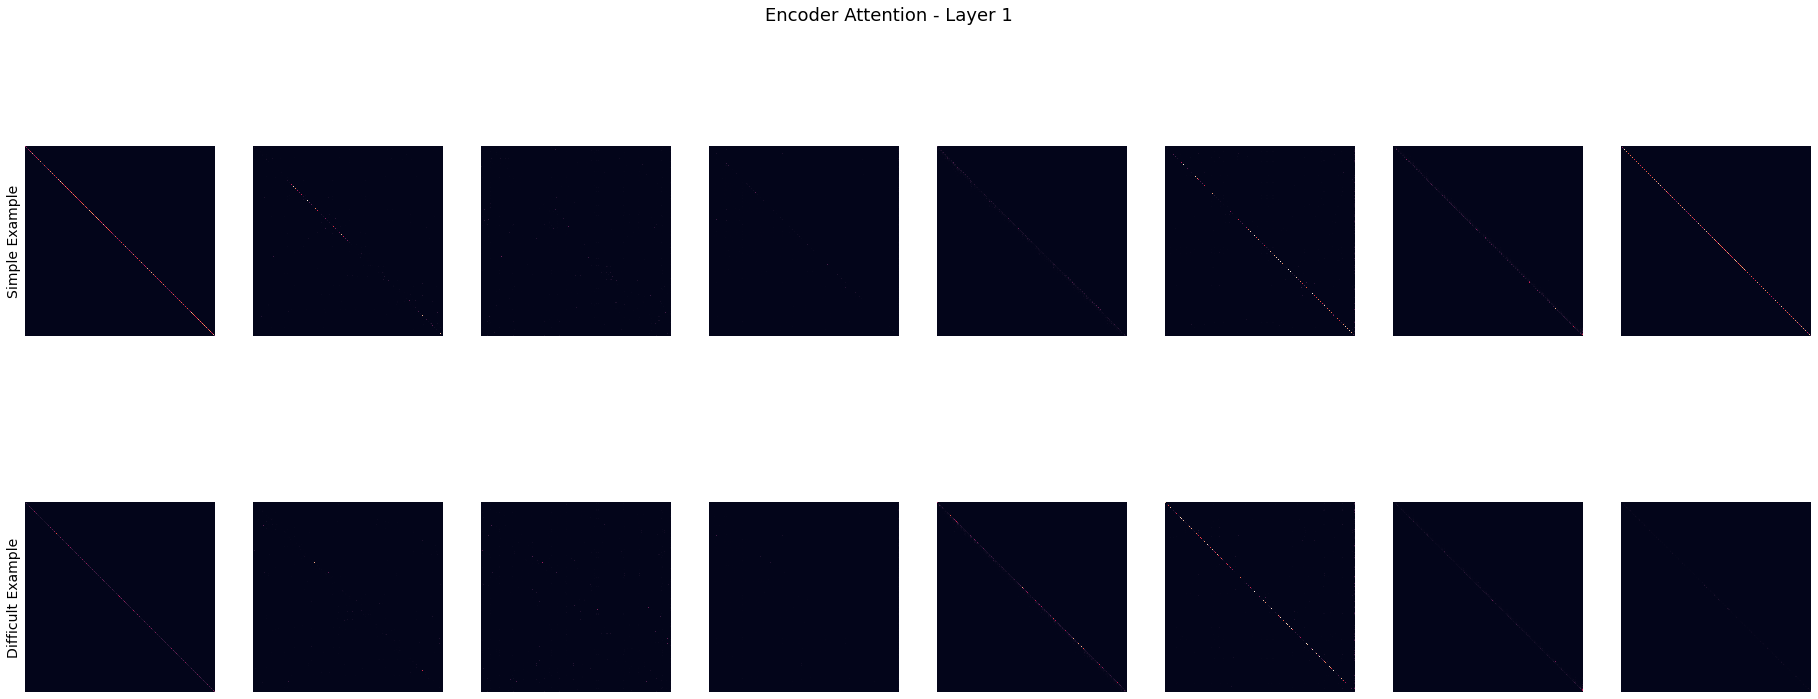

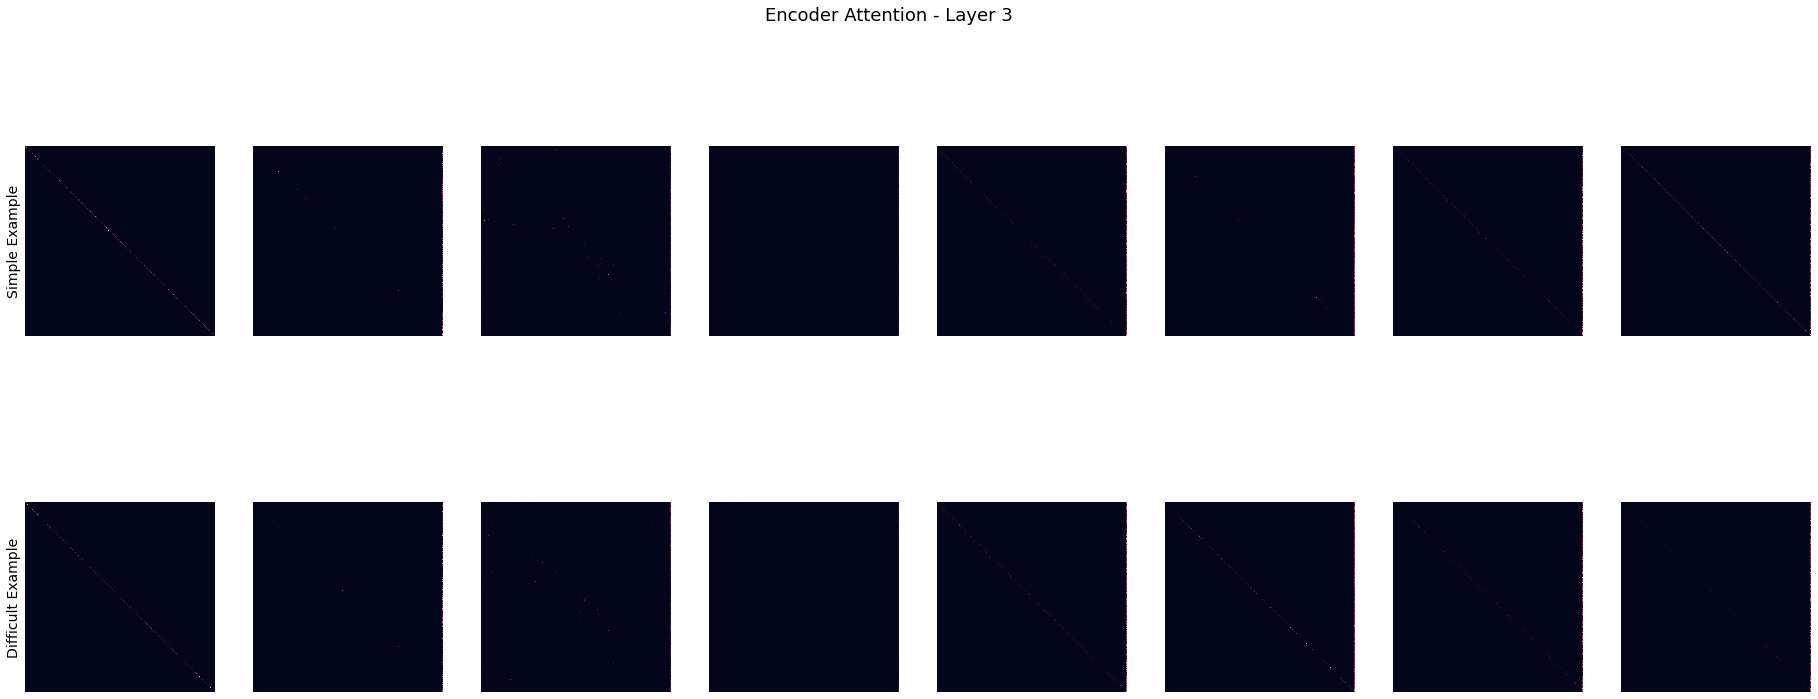

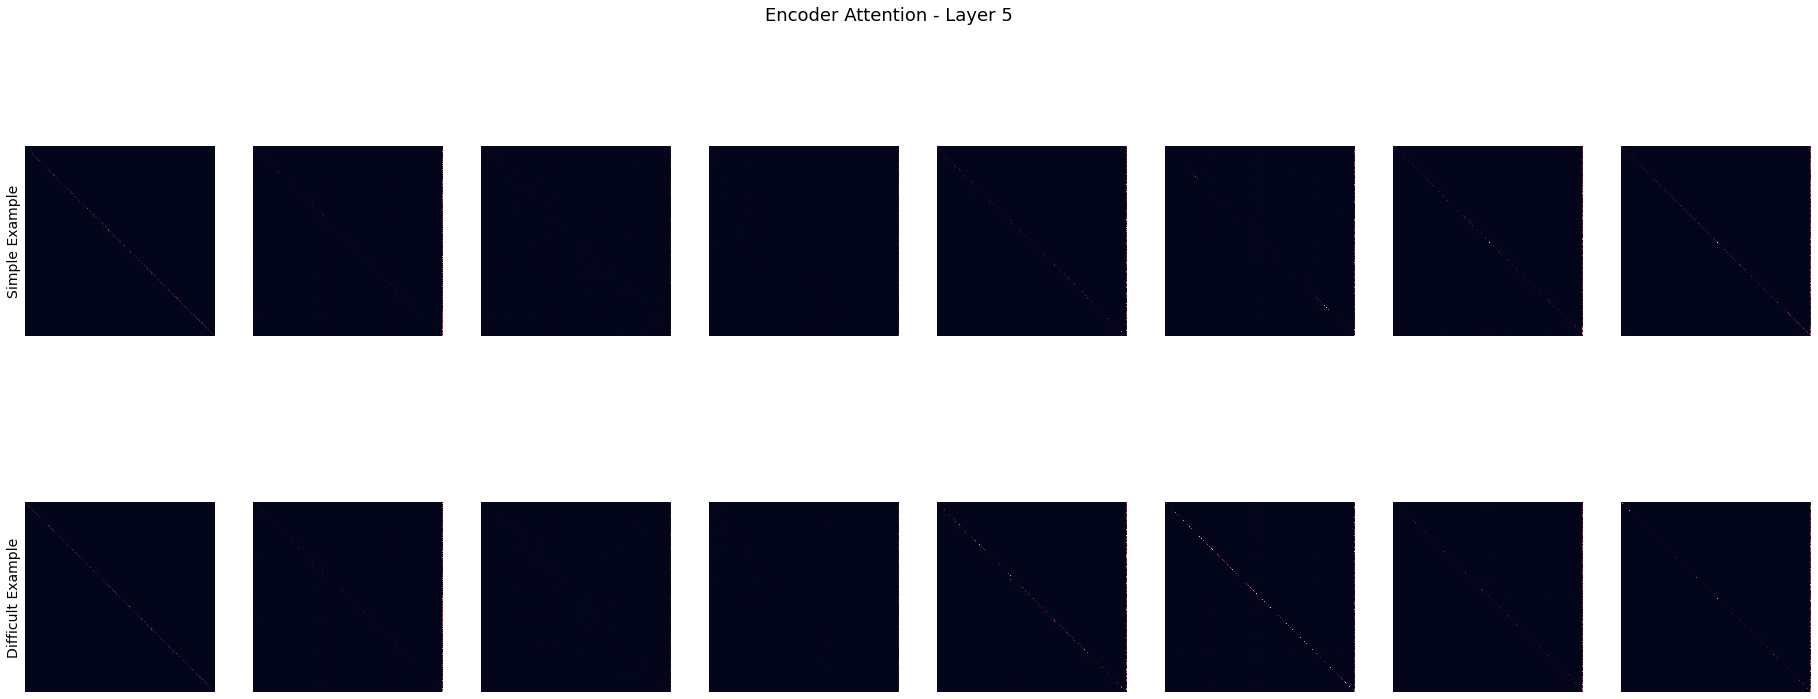

In [ ]:
# Plot encoder attention heads
for i in range(0,len(encoder_att_s),2):
    layer_s = encoder_att_s[i]
    layer_d = encoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Encoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

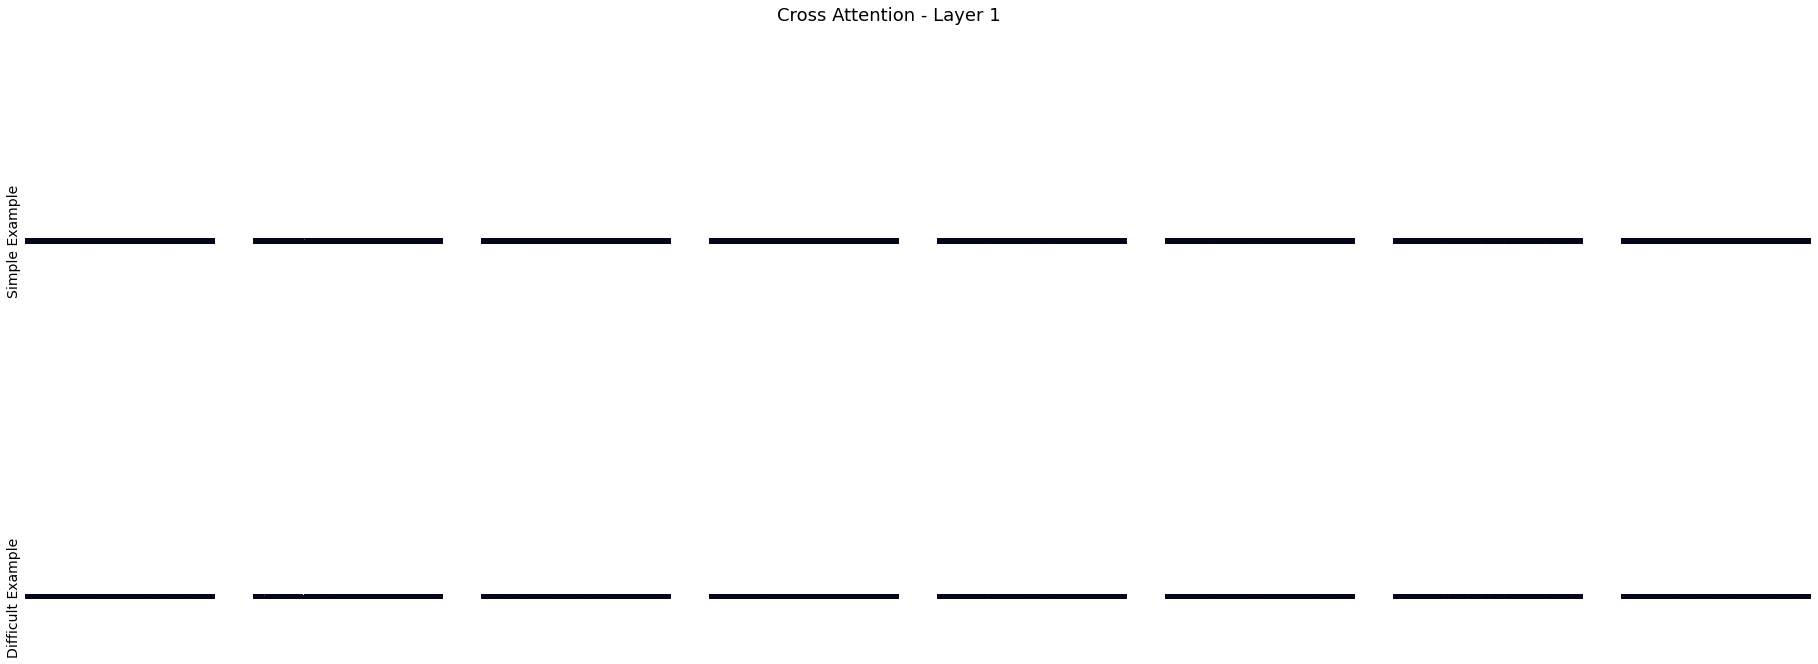

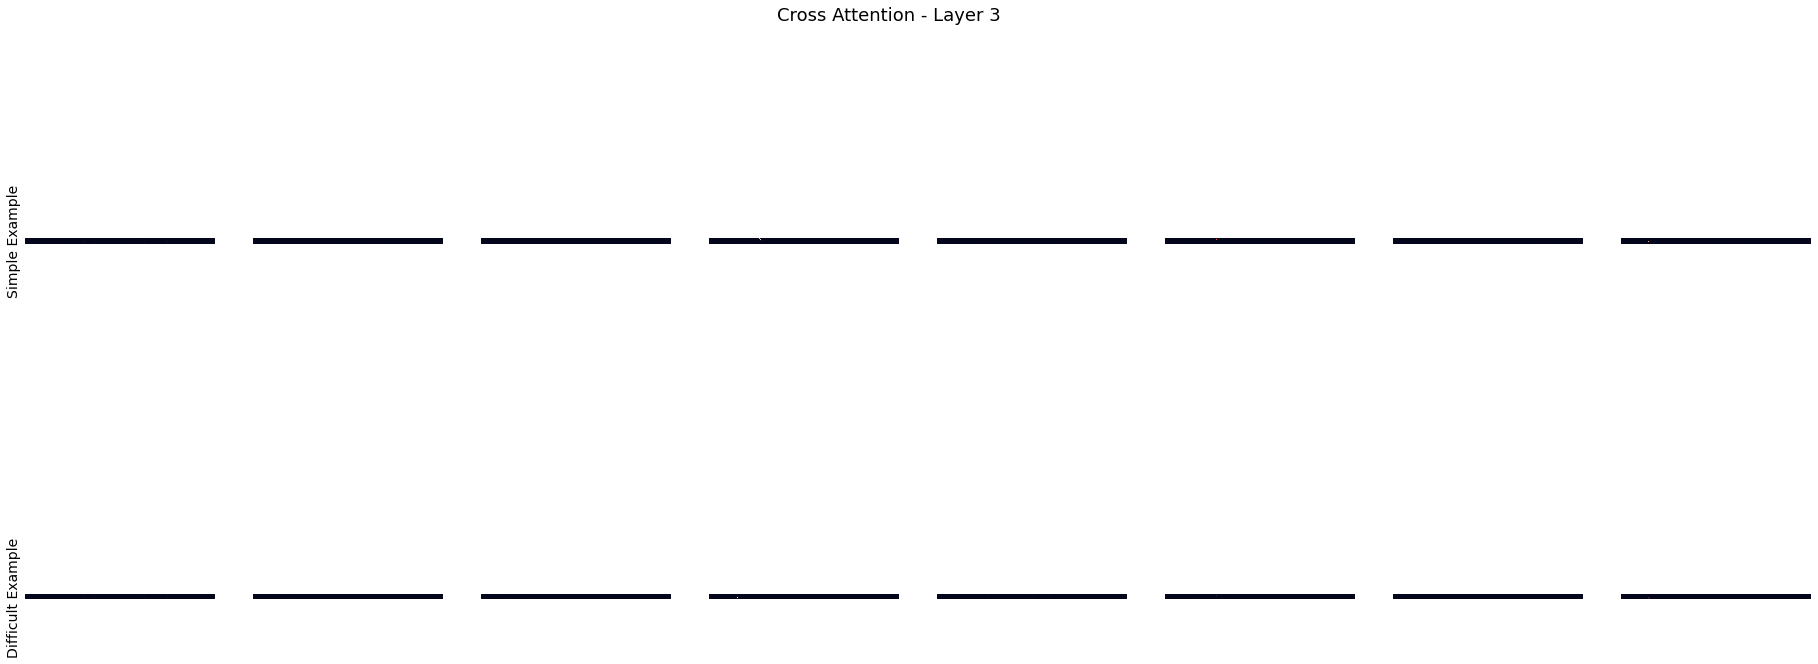

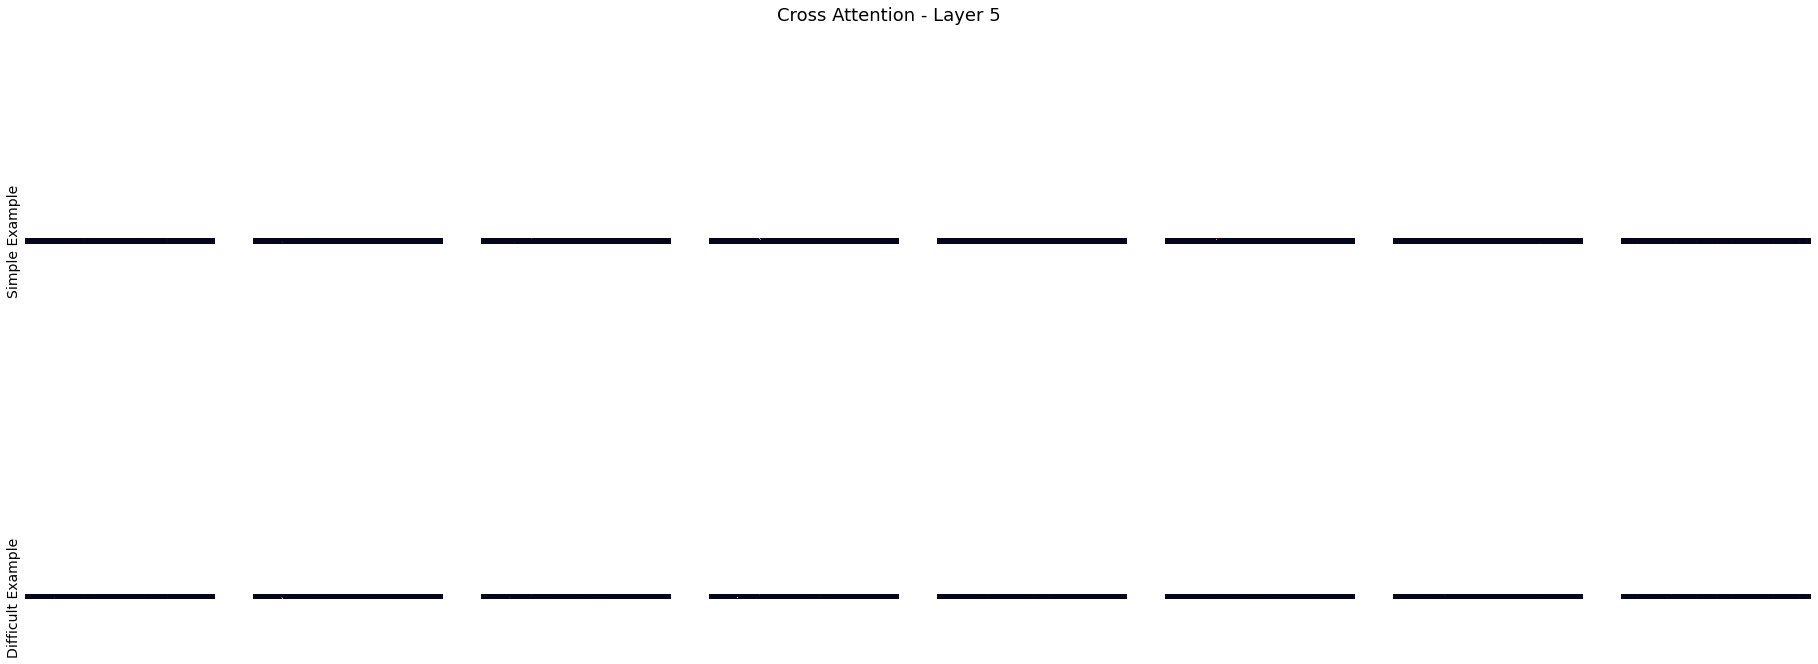

In [ ]:
# Plot cross attention heads
for i in range(0,len(cross_att_s),2):
    layer_s = cross_att_s[i]
    layer_d = cross_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Cross Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

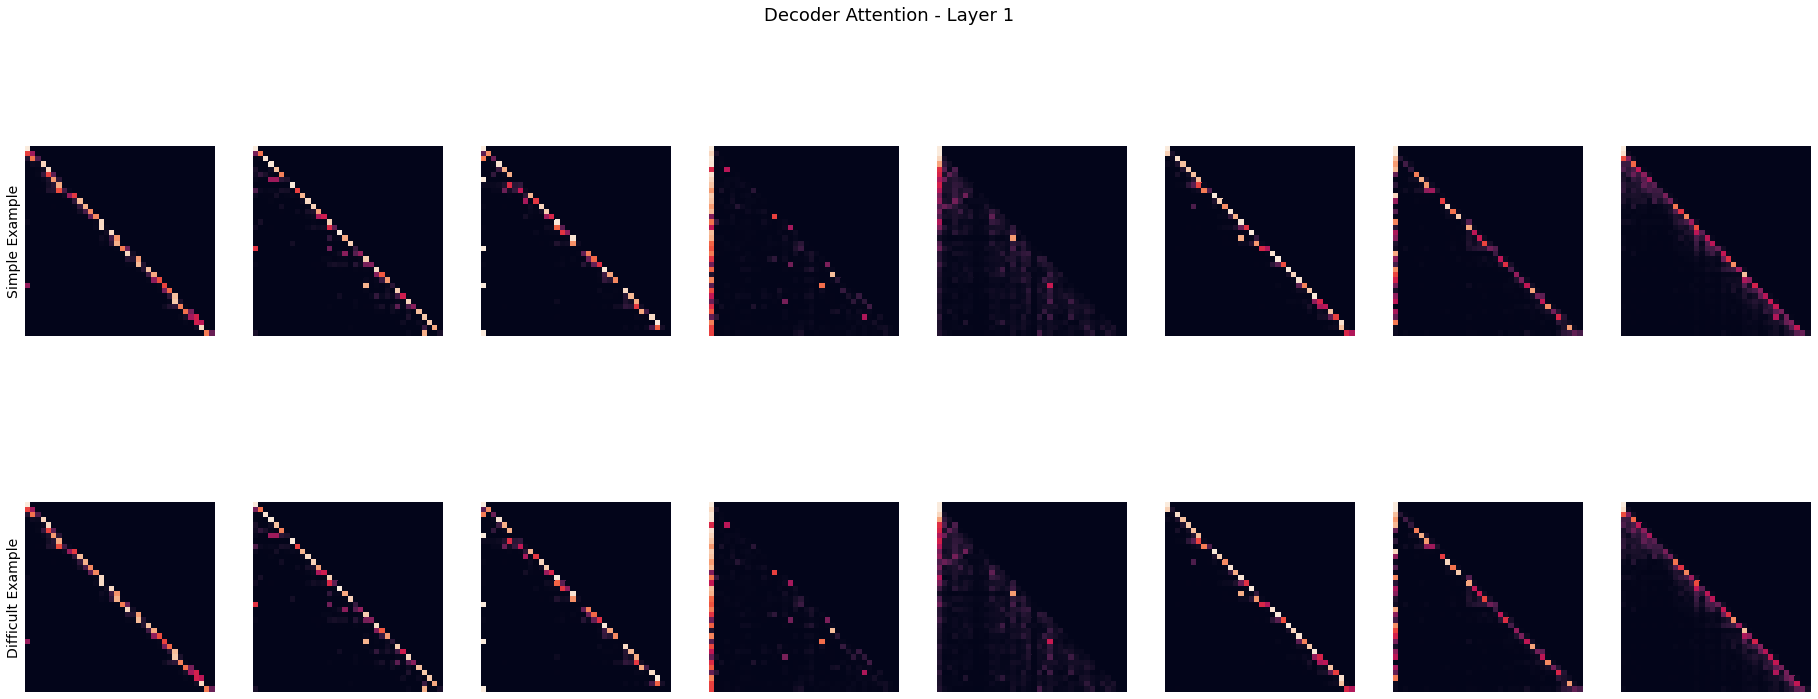

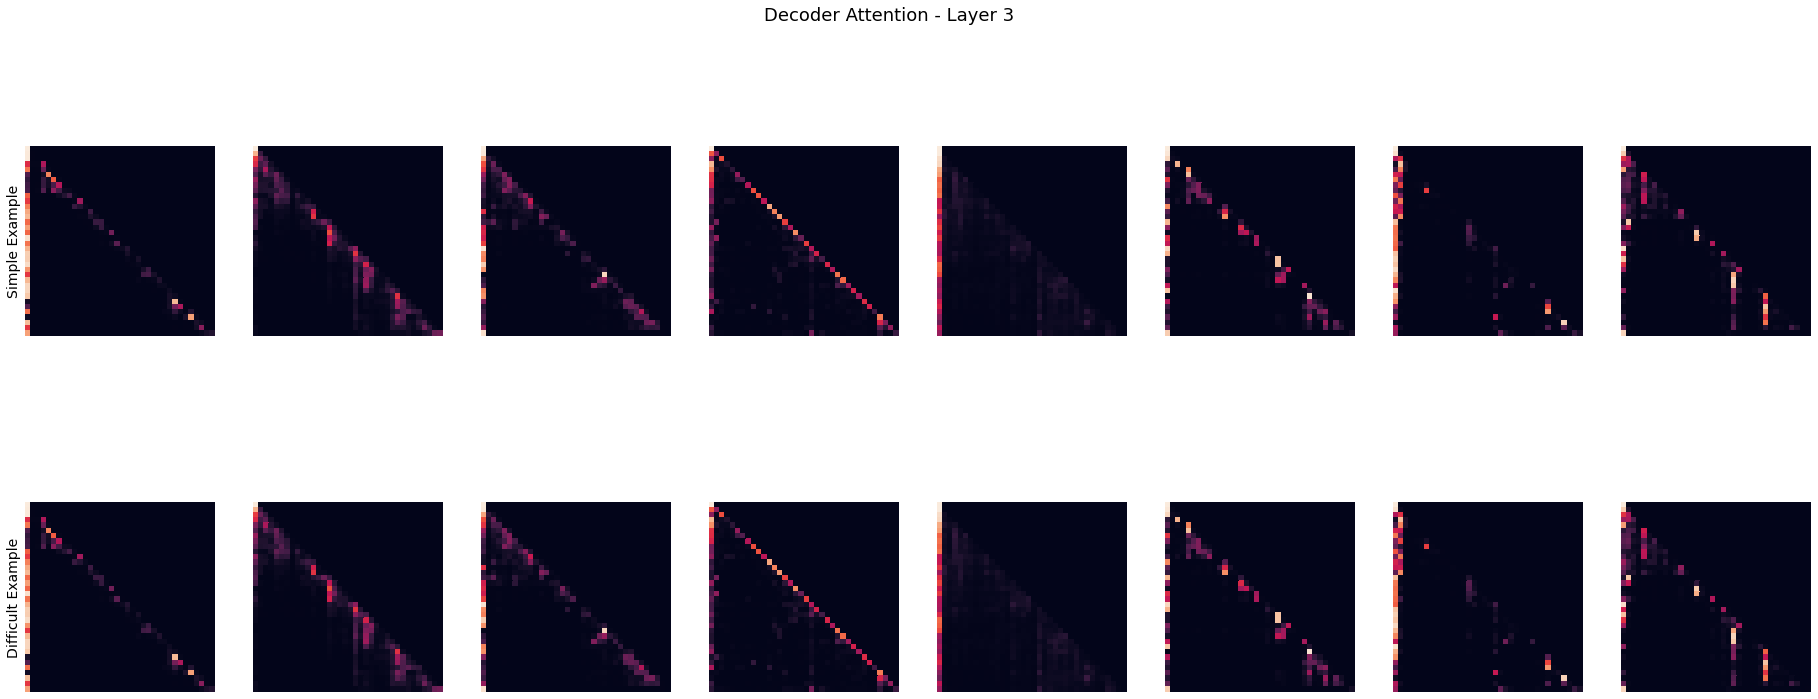

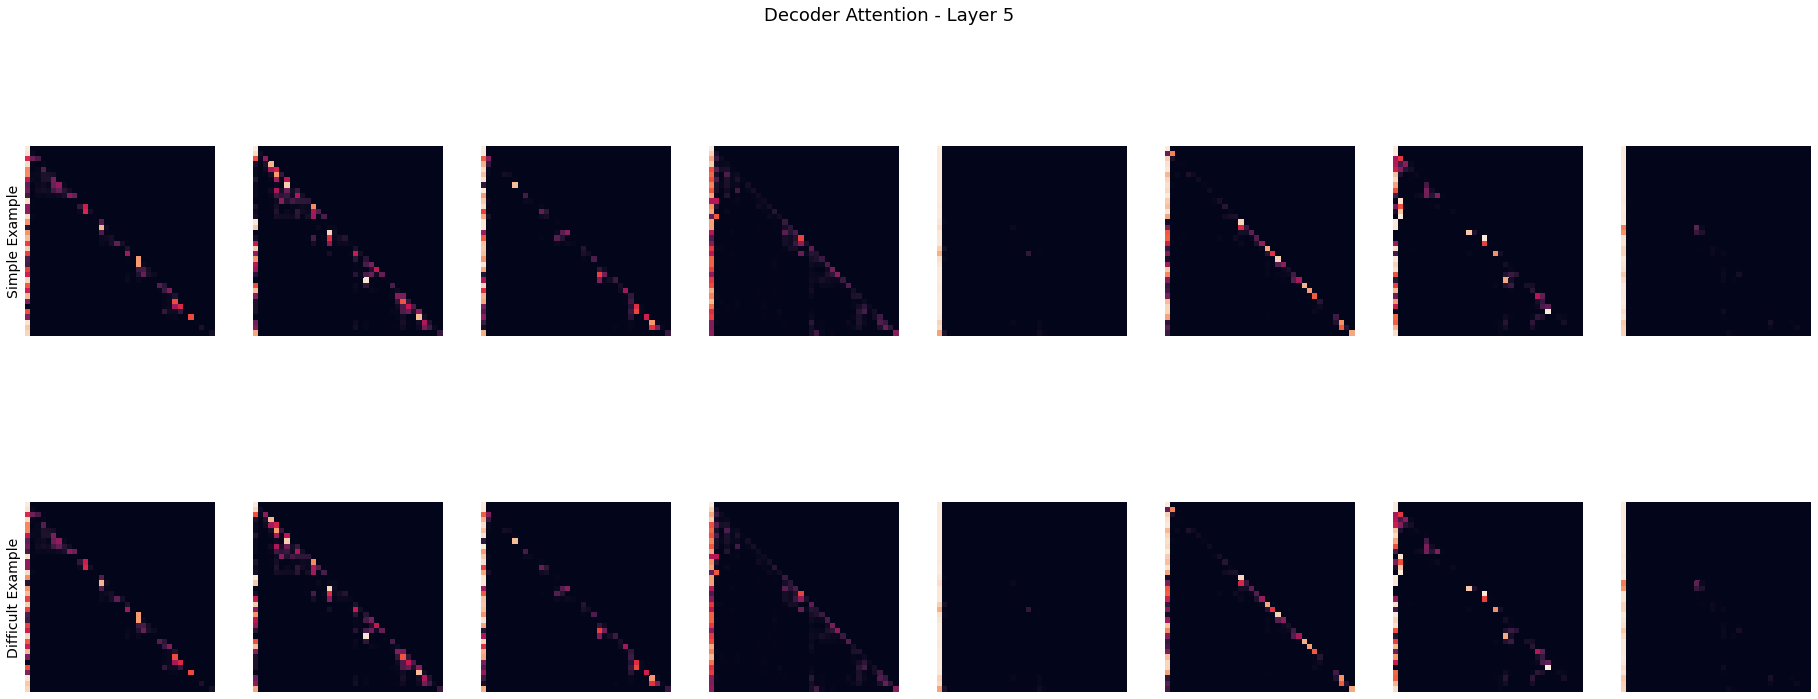

In [ ]:
# Plot decoder attention heads
for i in range(0,len(decoder_att_s),2):
    layer_s = decoder_att_s[i]
    layer_d = decoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Decoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

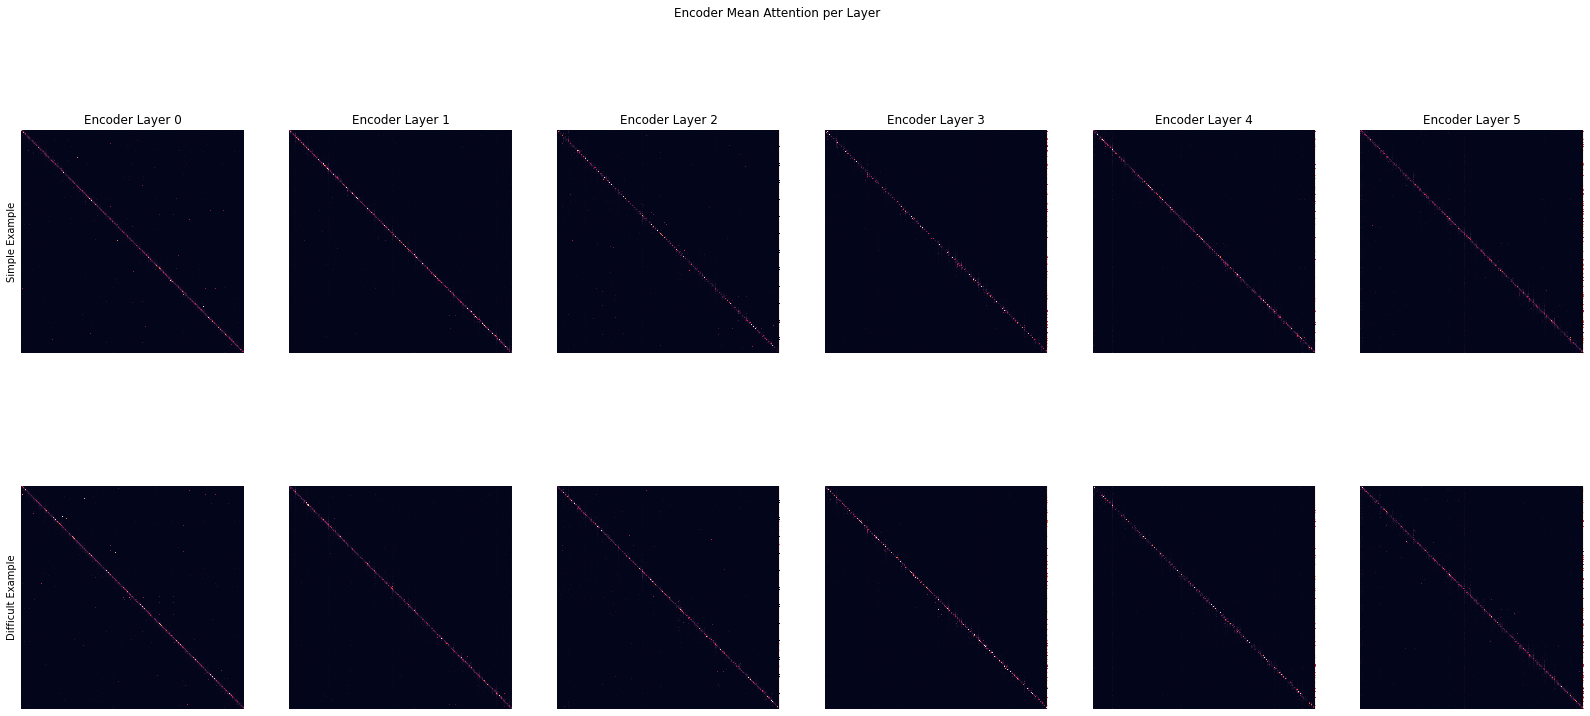

In [ ]:
# Plot encoder attention heads
fig, axs = plt.subplots(2,len(encoder_att_s),figsize=(28,12))
fig.suptitle("Encoder Mean Attention per Layer")

for i in range(len(encoder_att_s)):
    axs[0,i].set_title("Encoder Layer {}".format(i))

    draw(torch.sum(encoder_att_s[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[0,i])
    draw(torch.sum(encoder_att_d[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

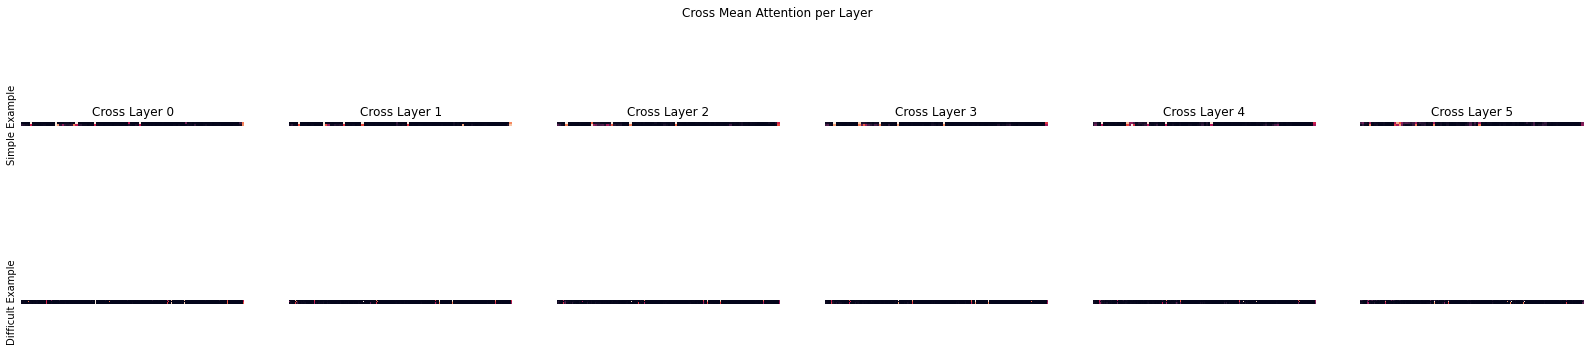

In [ ]:
# Plot cross attention heads
fig, axs = plt.subplots(2,len(cross_att_s),figsize=(28,6))
fig.suptitle("Cross Mean Attention per Layer")

for i in range(len(cross_att_s)):
    axs[0,i].set_title("Cross Layer {}".format(i))

    draw(torch.sum(cross_att_s[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[0,i])
    draw(torch.sum(cross_att_d[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

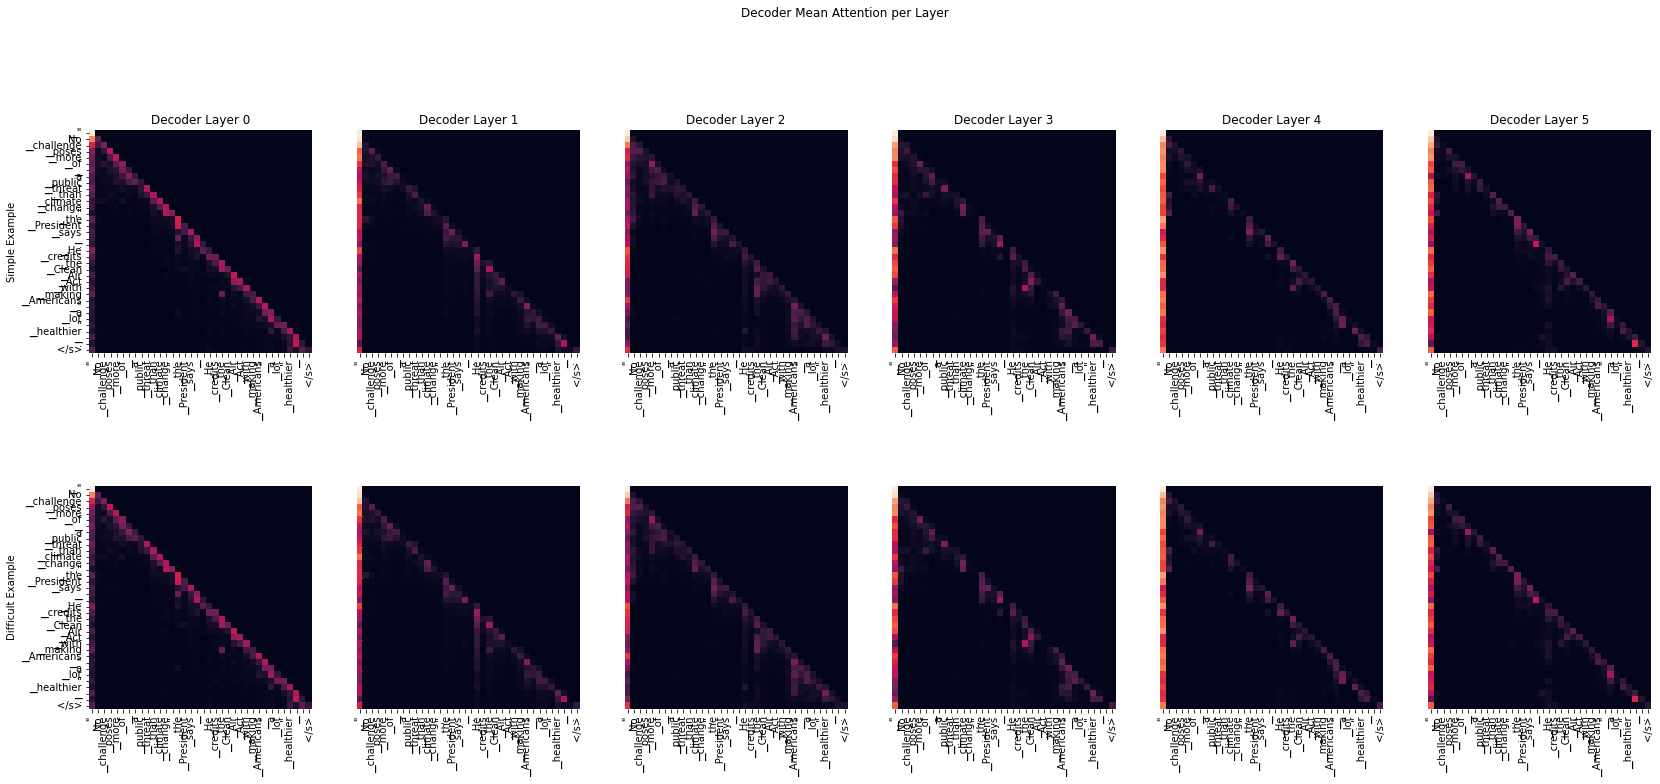

In [ ]:
# Plot decoder attention heads
fig, axs = plt.subplots(2,len(decoder_att_s),figsize=(28,12))
fig.suptitle("Decoder Mean Attention per Layer")

for i in range(len(decoder_att_s)):
    axs[0,i].set_title("Decoder Layer {}".format(i))

    draw(torch.mean(decoder_att_s[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[0,i])
    draw(torch.mean(decoder_att_d[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

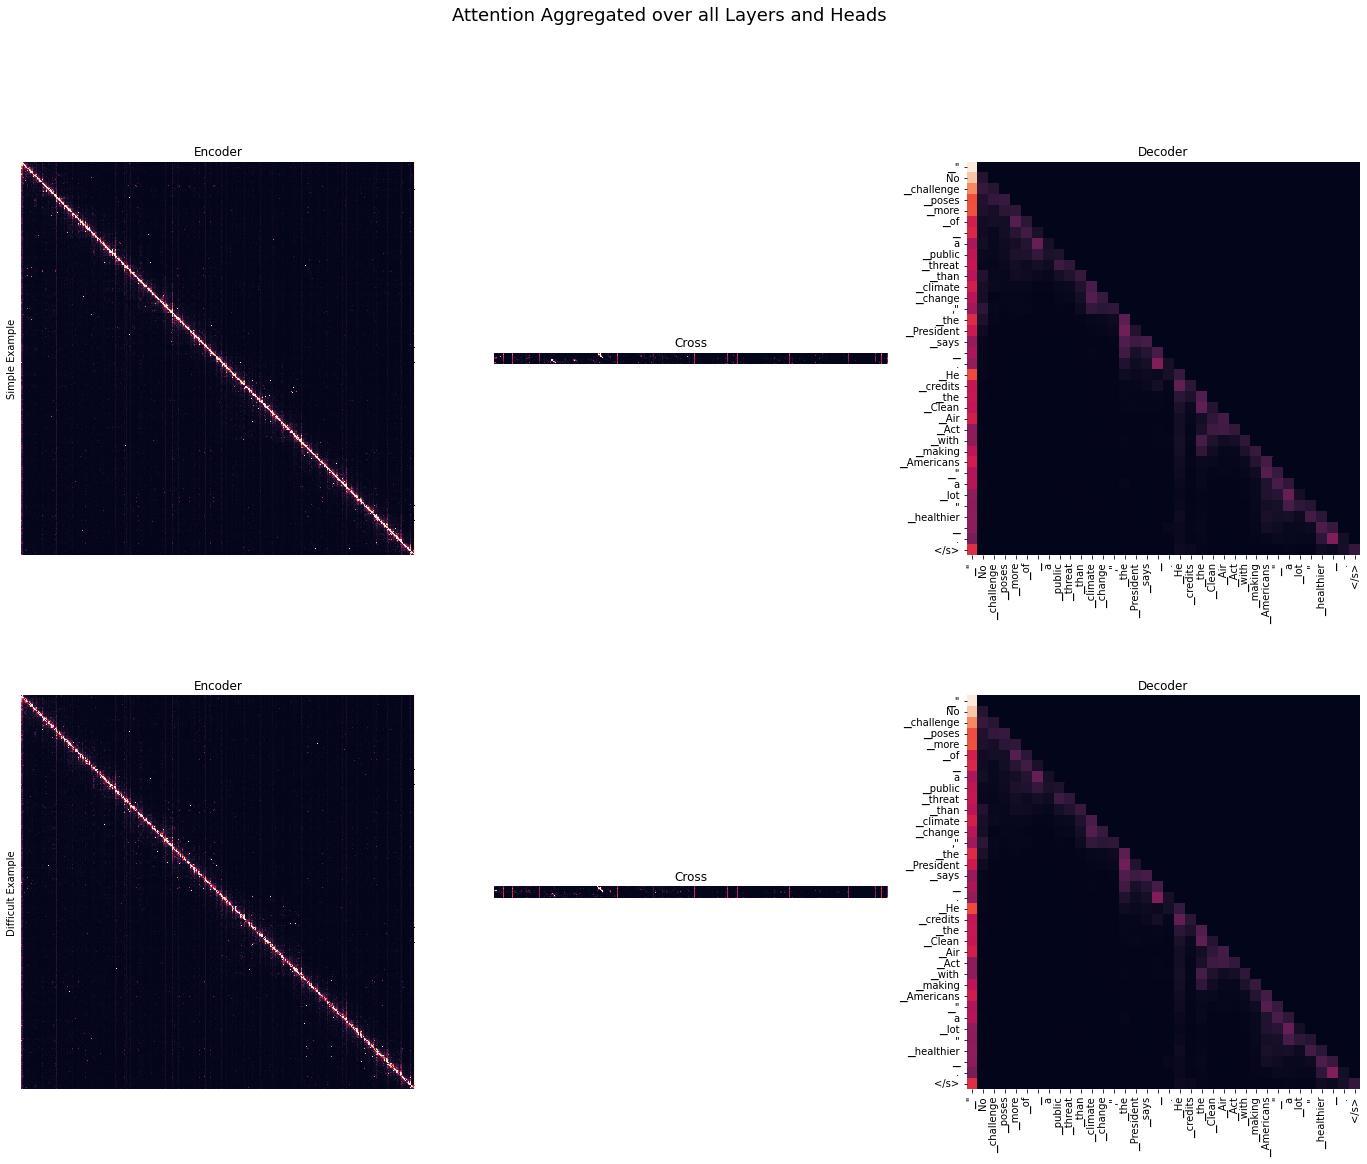

In [ ]:
# Aggregate attention heads over all layers and plot for encoder, cross and decoder
fig,axs = plt.subplots(2,3,figsize=(24,18))
fig.suptitle("Attention Aggregated over all Layers and Heads", fontsize=18)

# Simple Example
axs[0,0].set_title("Encoder")
draw(torch.sum(torch.cat([torch.squeeze(encoder_att_s[i]) for i in range(len(encoder_att_s))],dim=0), dim=0).cpu().detach(), [], [], axs[0,0])

axs[0,1].set_title("Cross")
draw(torch.sum(torch.cat([torch.squeeze(cross_att_s[i]) for i in range(len(cross_att_s))],dim=0), dim=0).cpu().detach(),  [], [], axs[0,1])

axs[0,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_s[i]) for i in range(len(decoder_att_s))],dim=0), dim=0).cpu().detach(),  output_tokens_d, output_tokens_d, axs[0,2])

axs[0,0].set_ylabel("Simple Example")

# Difficult Example
axs[1,0].set_title("Encoder")
draw(torch.sum(torch.cat([torch.squeeze(encoder_att_d[i]) for i in range(len(encoder_att_d))],dim=0), dim=0).cpu().detach(),  [], [], axs[1,0])

axs[1,1].set_title("Cross")
draw(torch.sum(torch.cat([torch.squeeze(cross_att_d[i]) for i in range(len(cross_att_d))],dim=0), dim=0).cpu().detach(),  [], [], axs[1,1])

axs[1,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_d[i]) for i in range(len(decoder_att_d))],dim=0), dim=0).cpu().detach(),  output_tokens_d, output_tokens_d, axs[1,2])

axs[1,0].set_ylabel("Difficult Example")

plt.show()

### Question Answering Task

In [ ]:
from datasets import load_dataset

# loading dataset
train_dataset = load_dataset('boolq', split='train')
valid_dataset = load_dataset('boolq', split='validation')

# #task to be done.
task_prefix = 'summarize: '

# # in this example we will use only one batch containing 5 examples.
batch_input_question = valid_dataset['question'][0:5]
batch_input_passage = valid_dataset['passage'][:5]
batch_output = [str(sequence) for sequence in valid_dataset['answer'][0:5]]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset boolq (/root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Once again, we choose the simple and difficult examples by selecting the shortest and longest passage in the batch.

In [ ]:
# Select simple sample
i = 2

# Tokenize input sample and compute tokens from ids
input_s = tokenizer(batch_input_question[i], batch_input_passage[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to(device)
label_s = tokenizer(batch_output[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to(device)
input_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(input_s['input_ids']))
output_tokens_s = tokenizer.convert_ids_to_tokens(torch.squeeze(label_s['input_ids']))

# Pass through model and return attention heads
output_s = model(input_ids=input_s['input_ids'], labels=label_s['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_s = output_s['encoder_attentions']
cross_att_s = output_s['cross_attentions']
decoder_att_s = output_s['decoder_attentions']

In [ ]:
# Select difficult sample
i = 0

# Tokenize input sample and compute tokens from ids
input_d = tokenizer(batch_input_question[i], batch_input_passage[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to(device)
label_d = tokenizer(batch_output[i], padding=True, max_length=512, truncation=True, return_tensors="pt").to(device)
input_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(input_d['input_ids']))
output_tokens_d = tokenizer.convert_ids_to_tokens(torch.squeeze(label_d['input_ids']))

# Pass through model and return attention heads
output_d = model(input_ids=input_d['input_ids'], labels=label_d['input_ids'], output_attentions=True)

# Get attention heads
encoder_att_d = output_d['encoder_attentions']
cross_att_d = output_d['cross_attentions']
decoder_att_d = output_d['decoder_attentions']

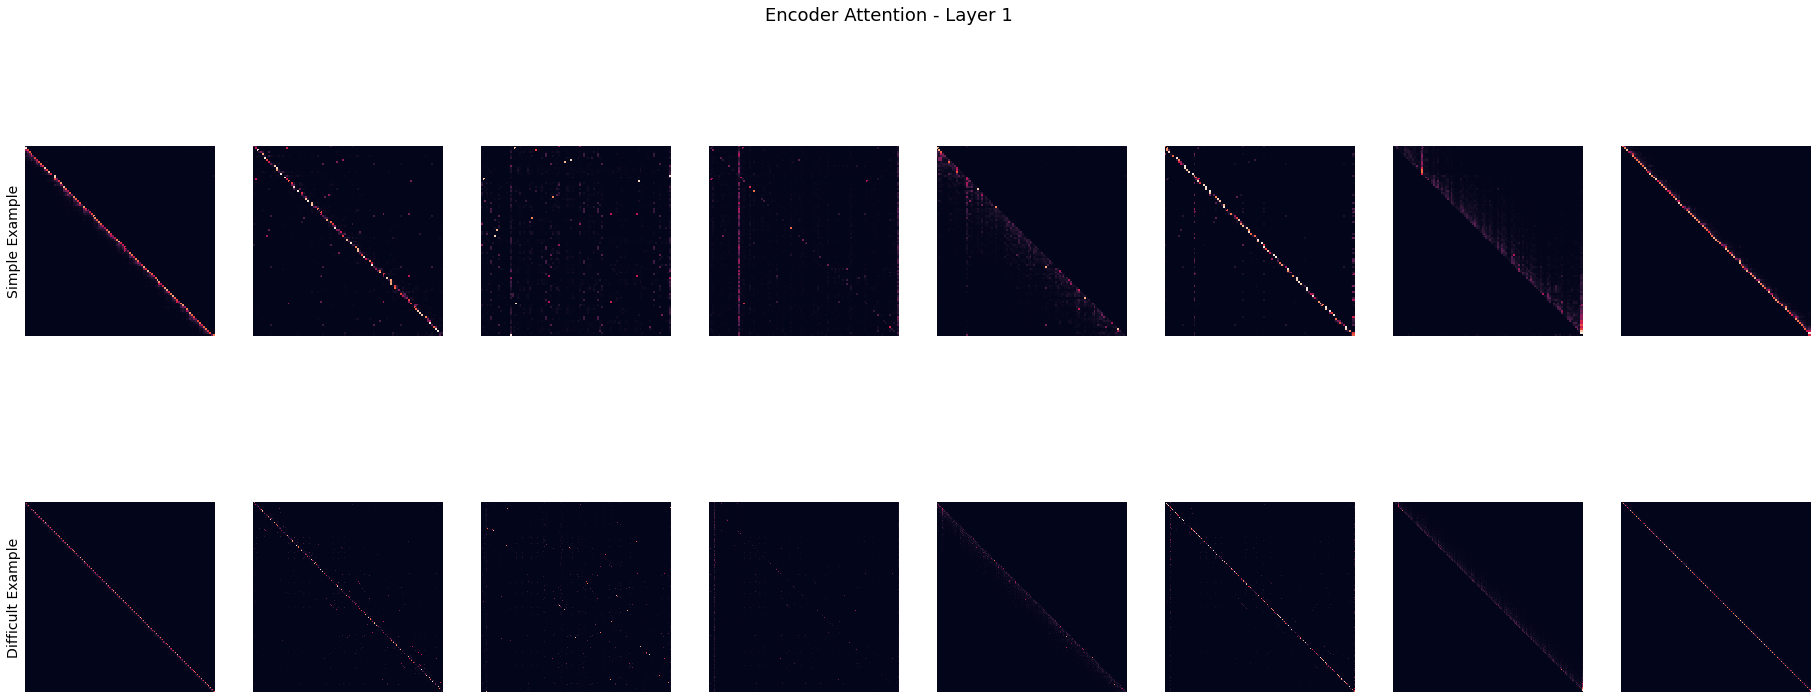

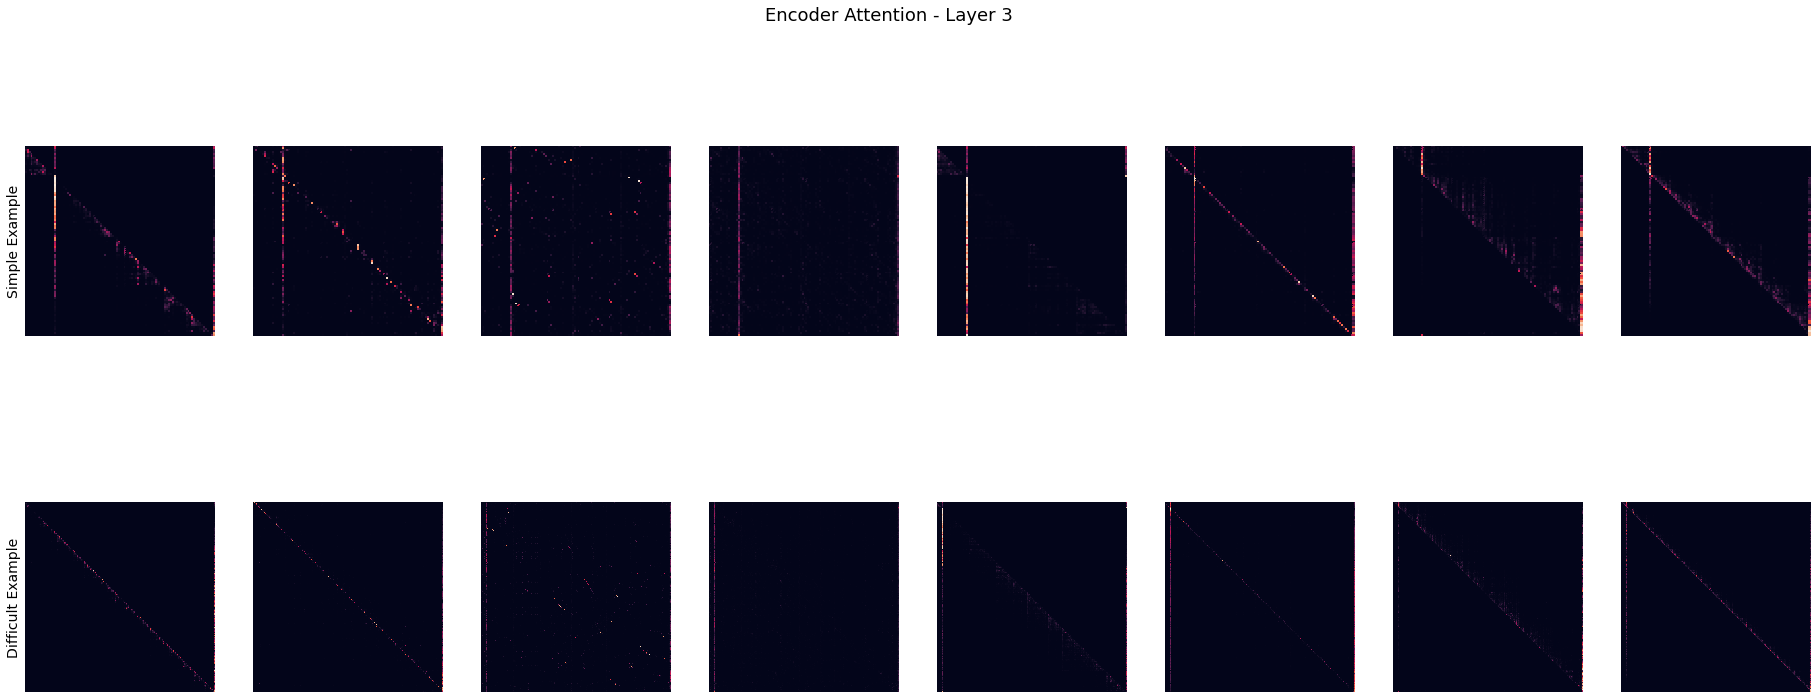

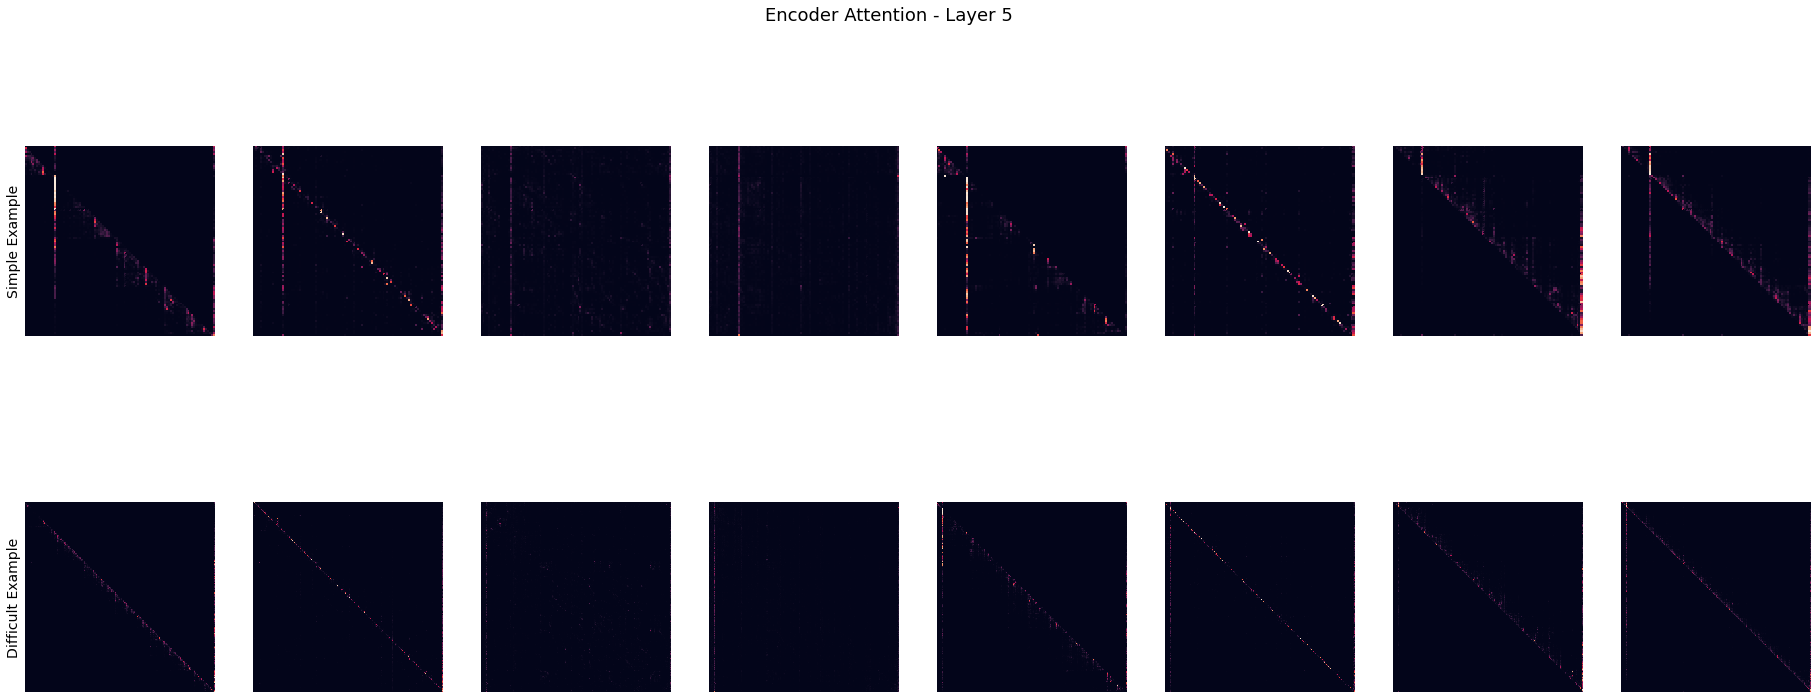

In [ ]:
# Plot encoder attention heads
for i in range(0,len(encoder_att_s),2):
    layer_s = encoder_att_s[i]
    layer_d = encoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Encoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

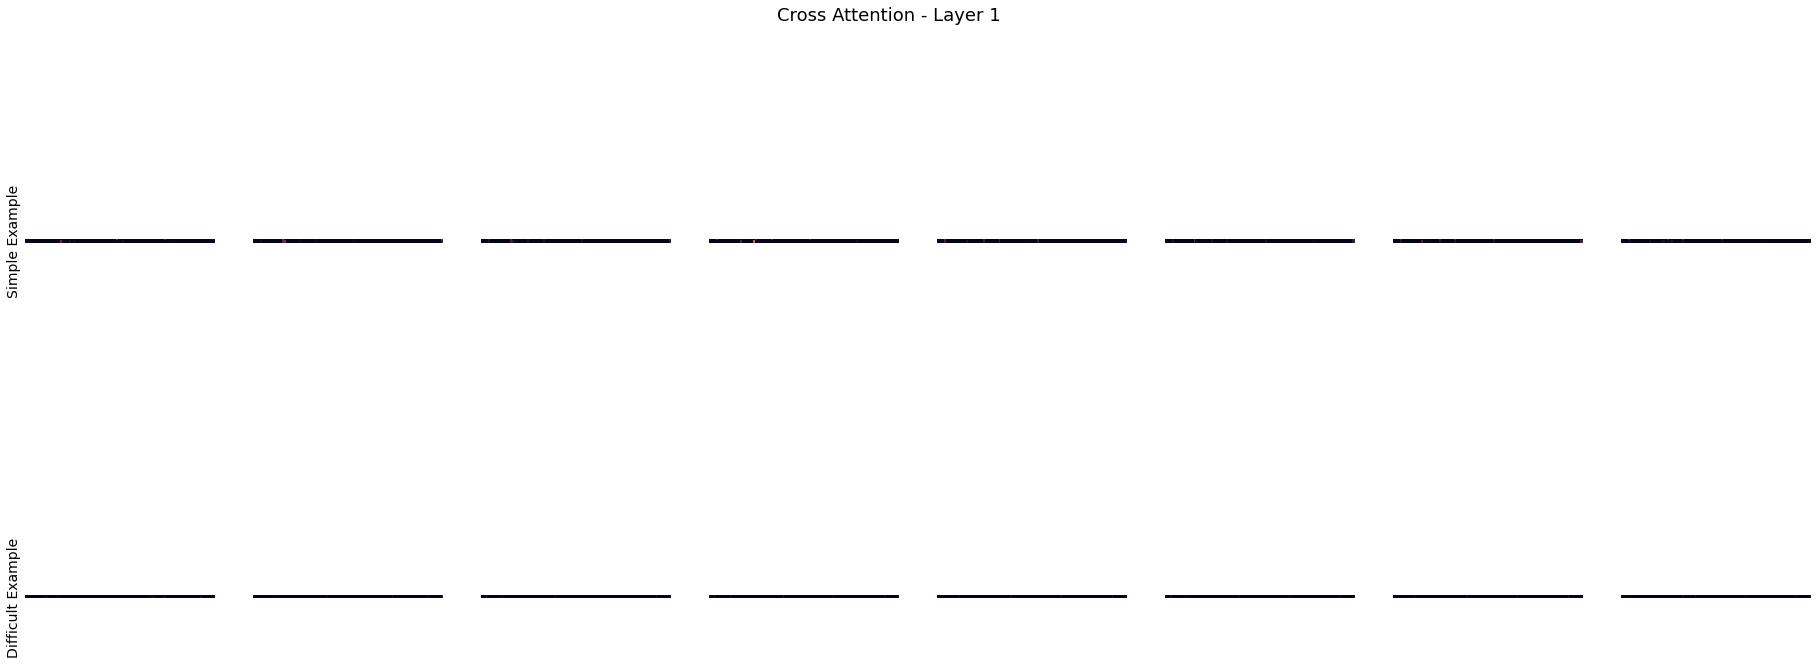

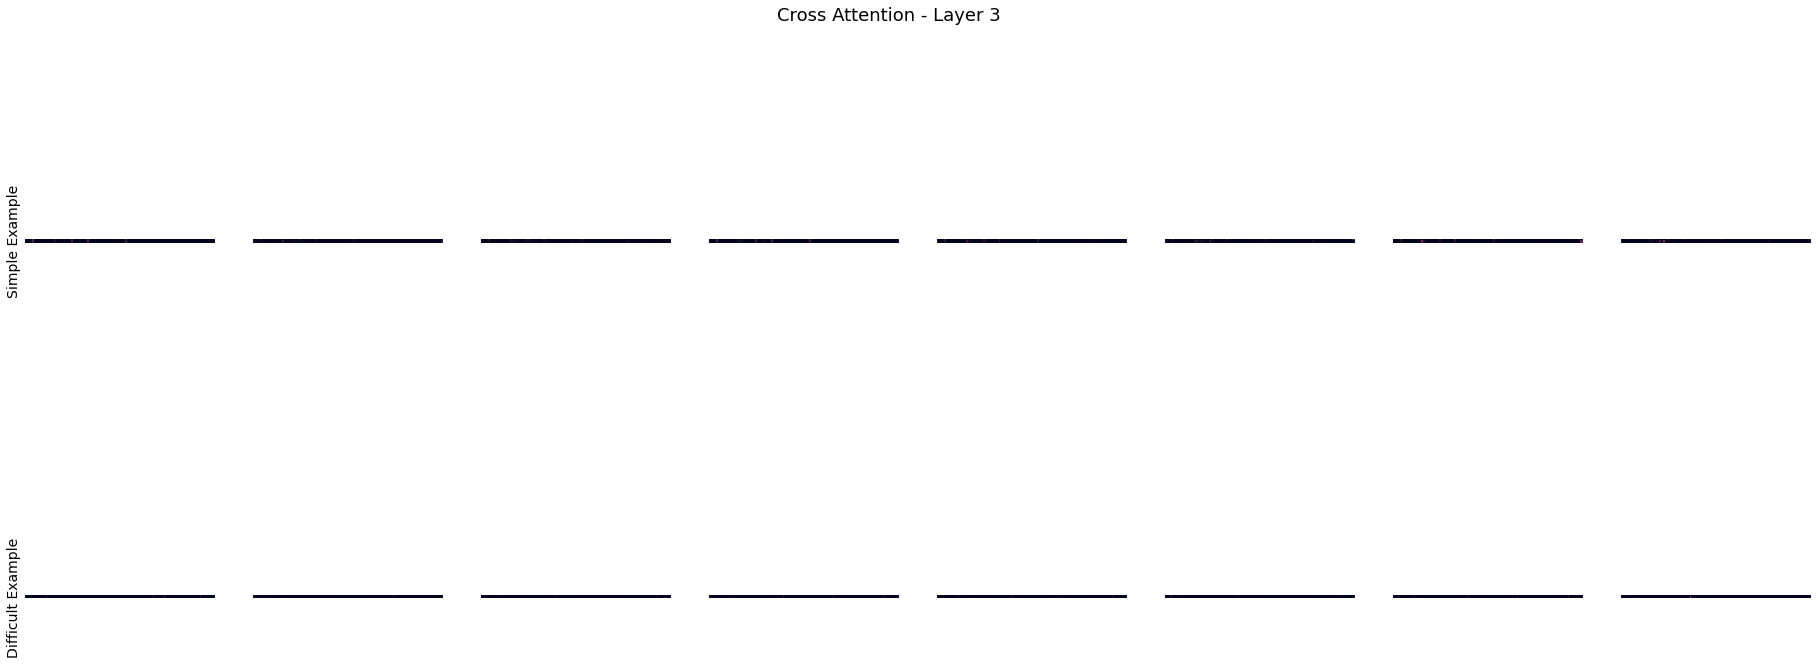

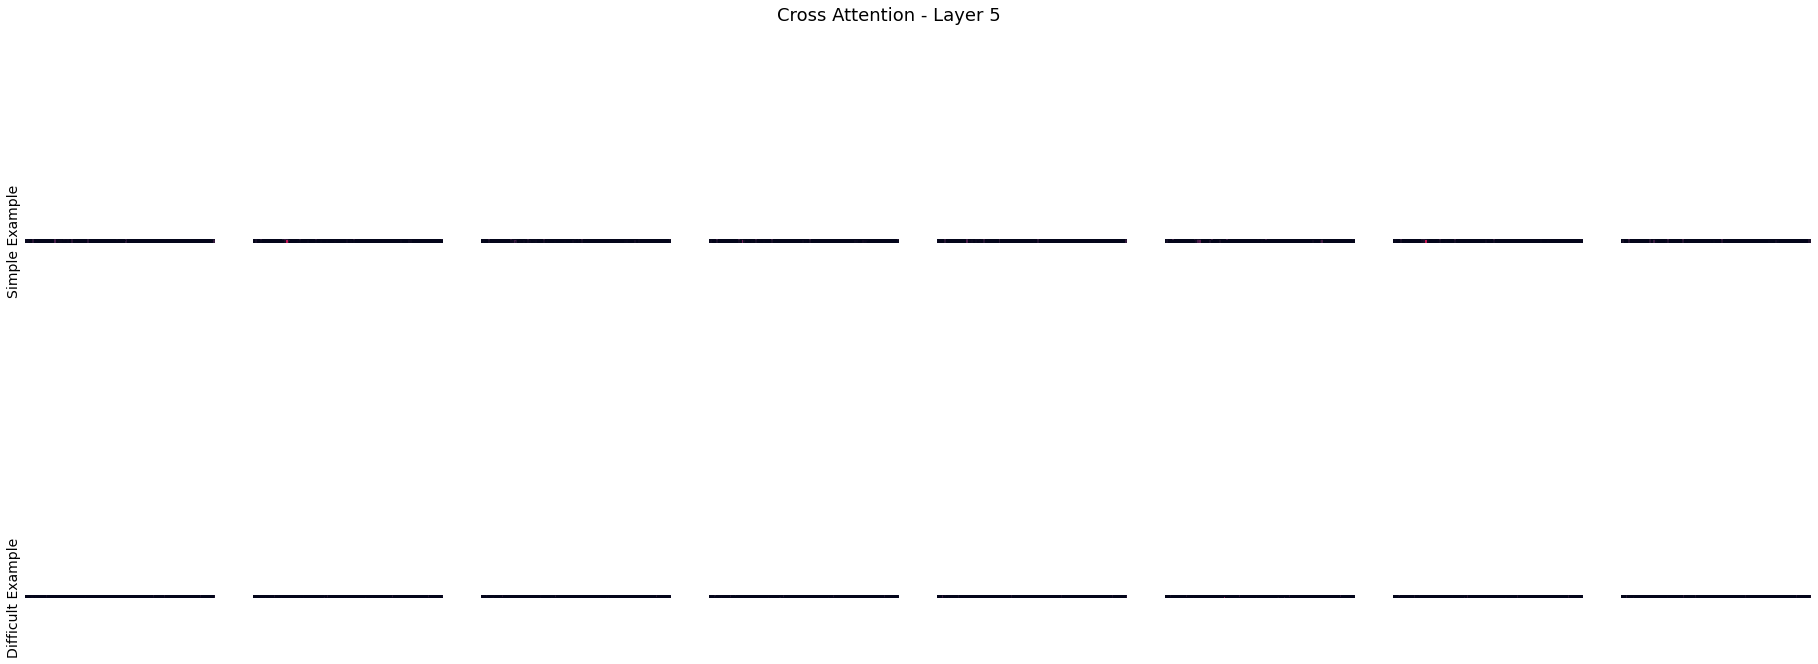

In [ ]:
# Plot cross attention heads
for i in range(0,len(cross_att_s),2):
    layer_s = cross_att_s[i]
    layer_d = cross_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Cross Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

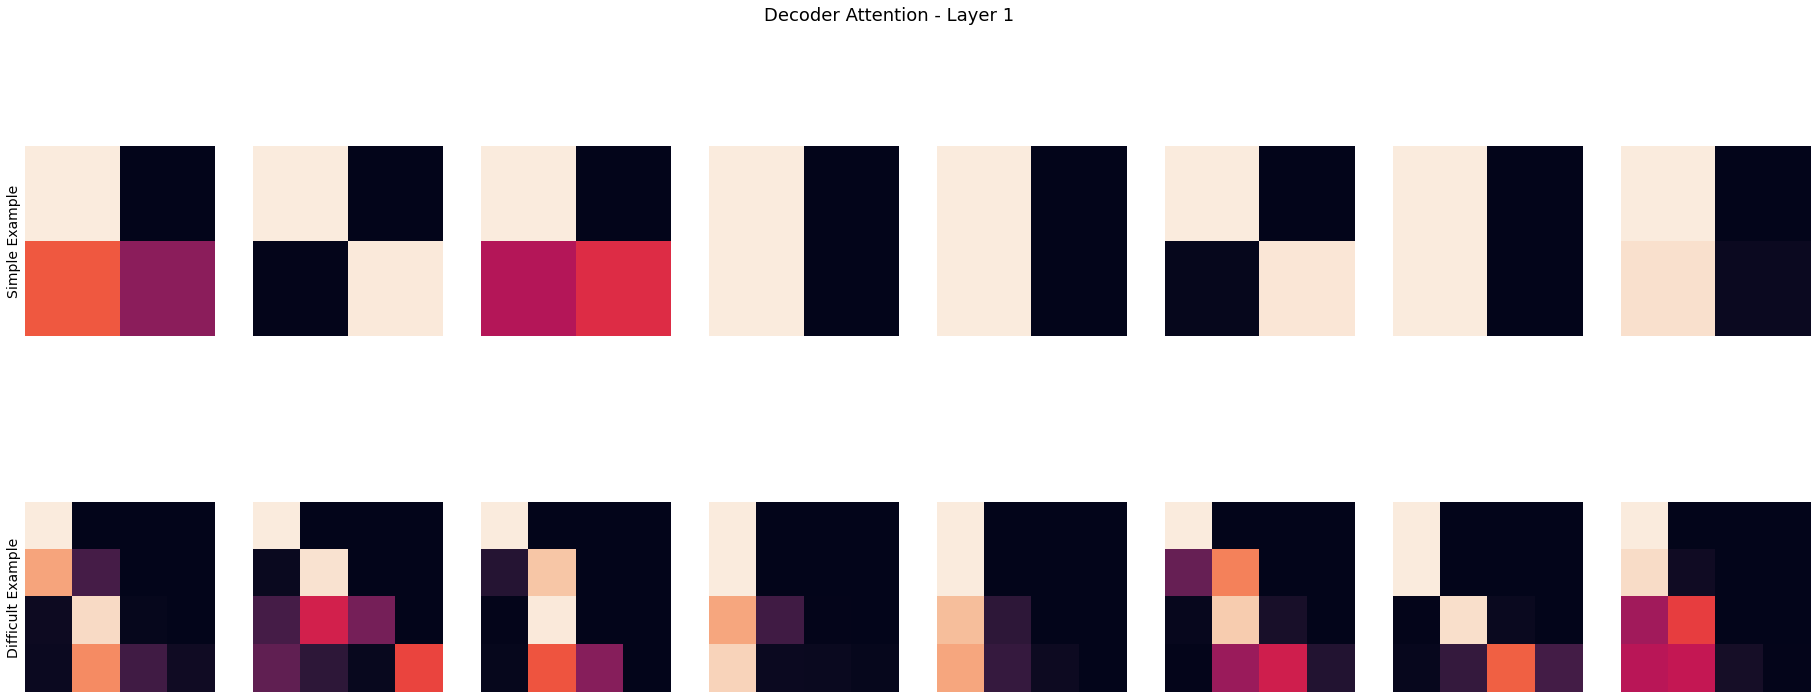

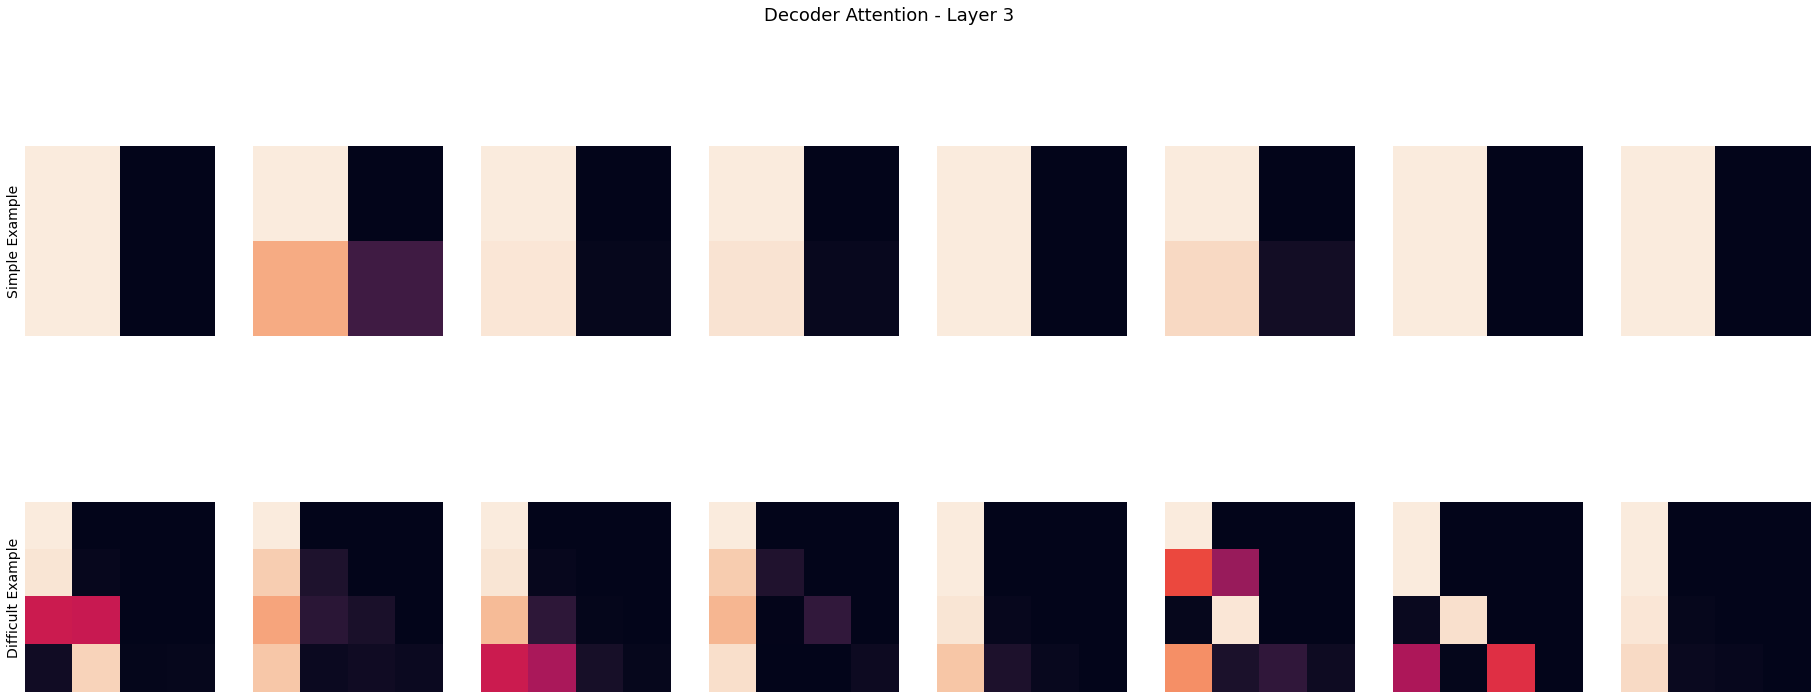

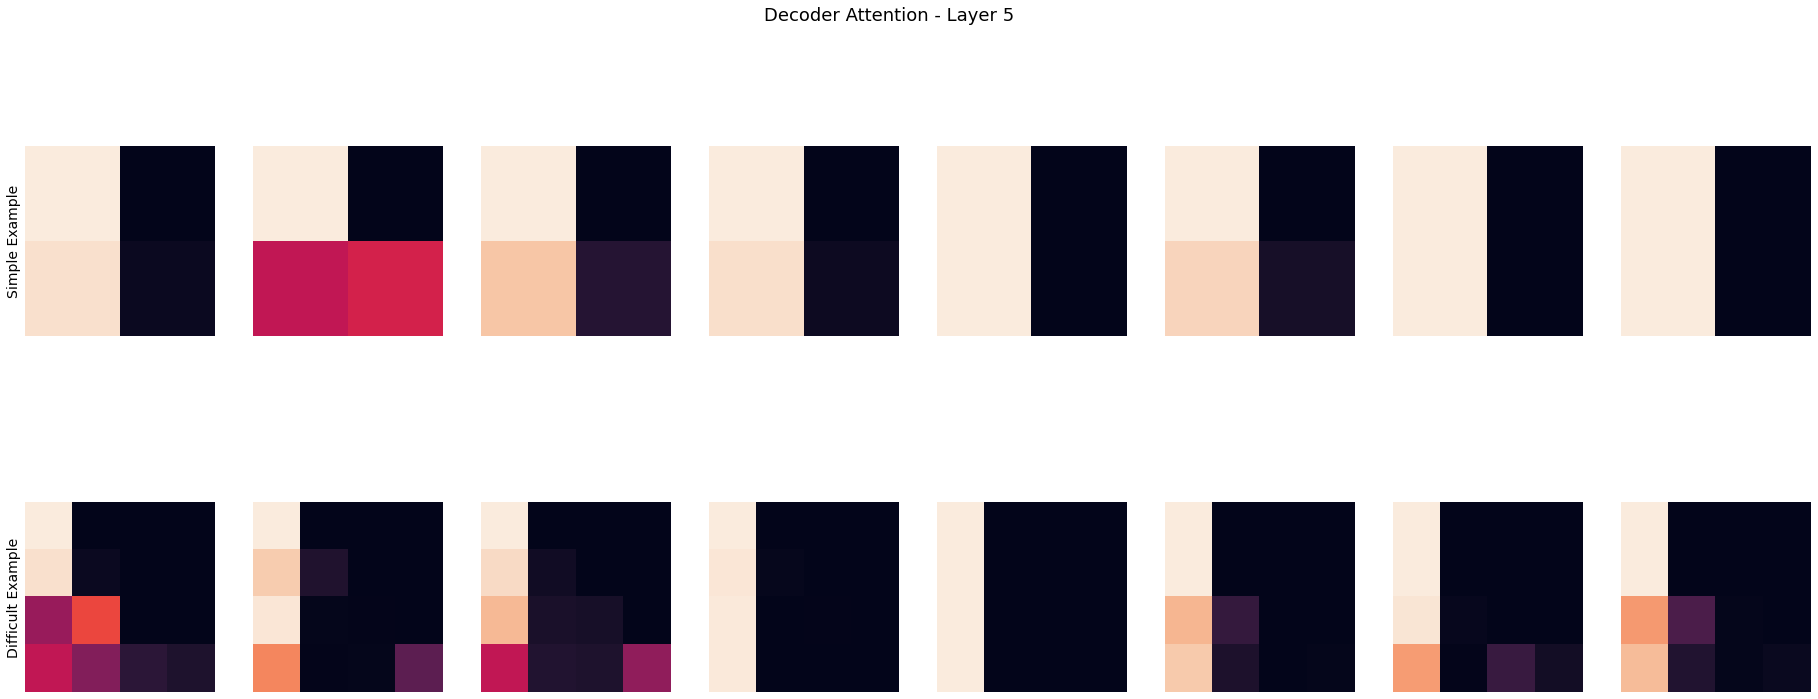

In [ ]:
# Plot decoder attention heads
for i in range(0,len(decoder_att_s),2):
    layer_s = decoder_att_s[i]
    layer_d = decoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Decoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

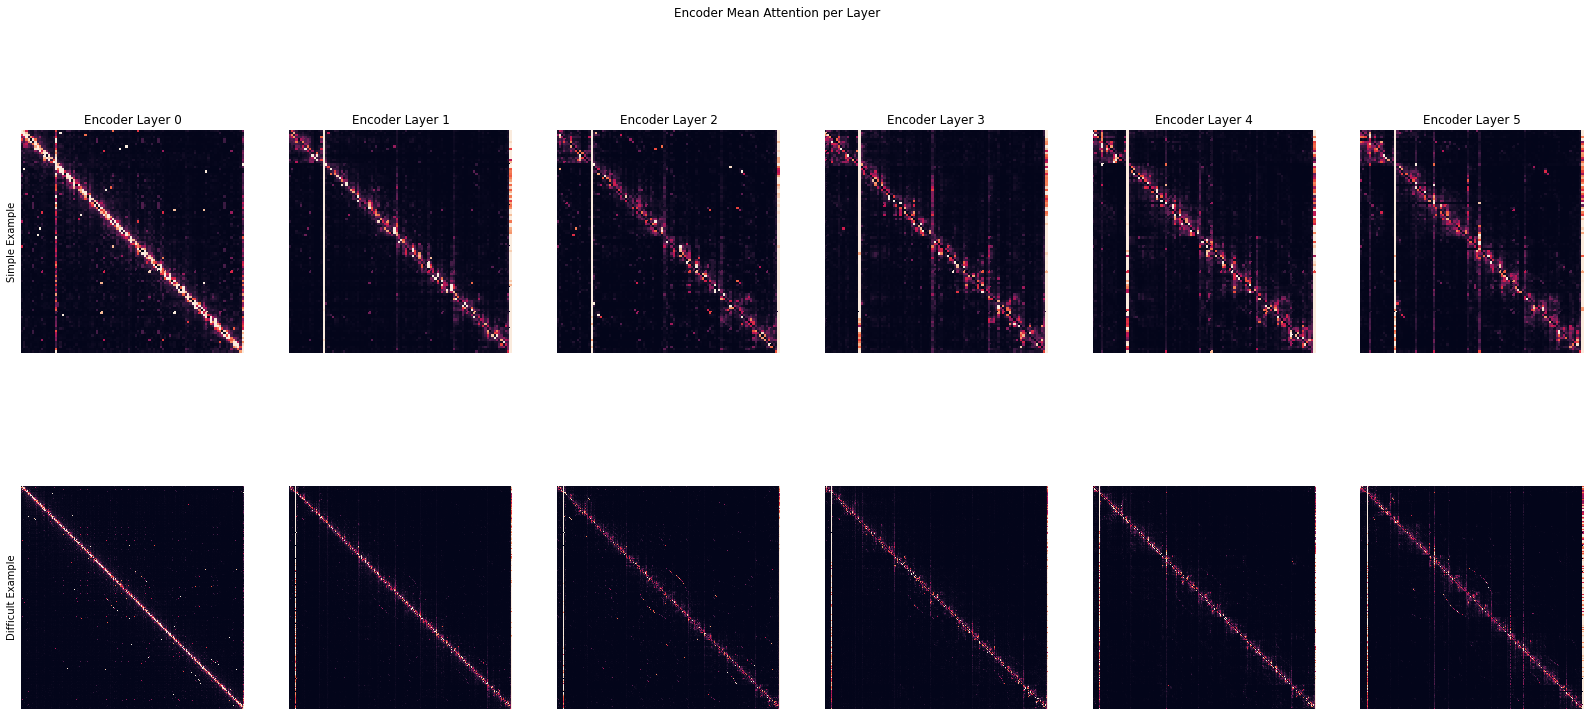

In [ ]:
# Plot encoder attention heads
fig, axs = plt.subplots(2,len(encoder_att_s),figsize=(28,12))
fig.suptitle("Encoder Mean Attention per Layer")

for i in range(len(encoder_att_s)):
    axs[0,i].set_title("Encoder Layer {}".format(i))

    draw(torch.sum(encoder_att_s[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[0,i])
    draw(torch.sum(encoder_att_d[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

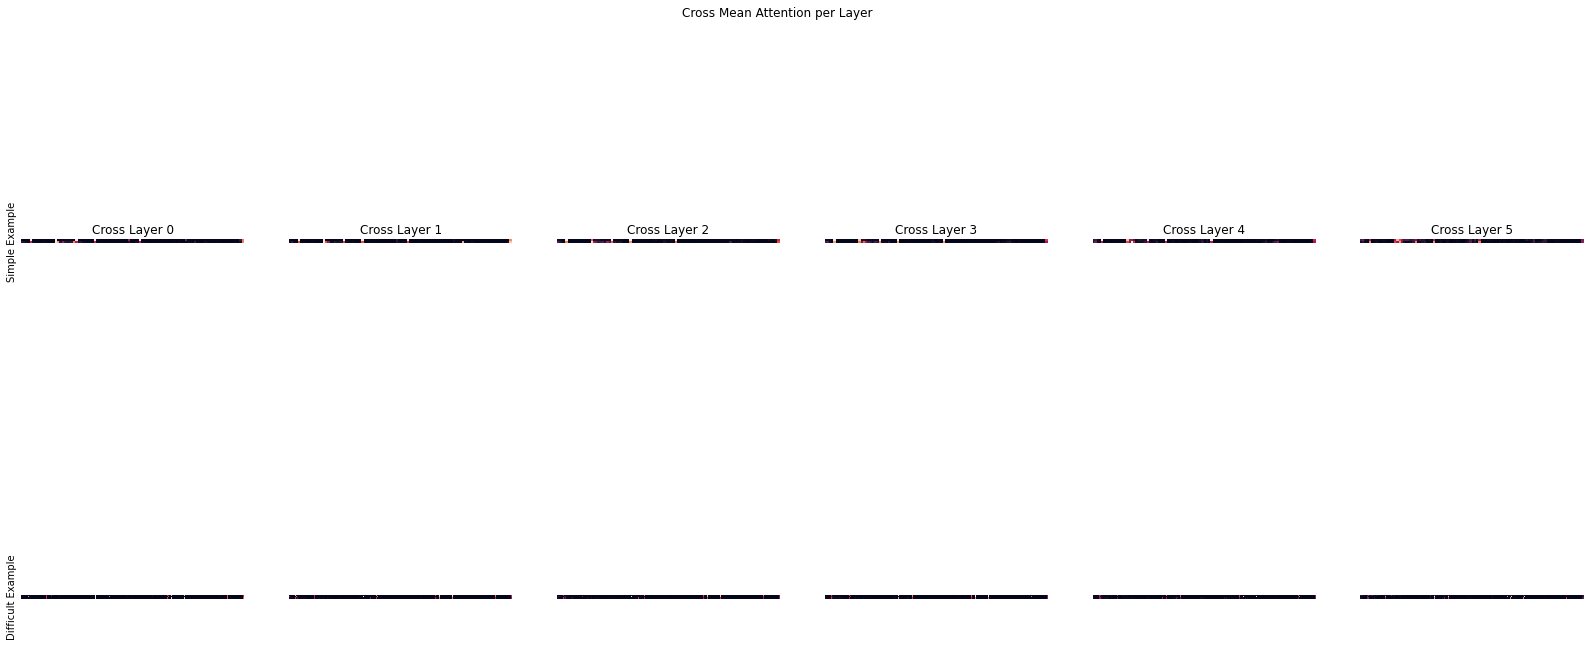

In [ ]:
# Plot cross attention heads
fig, axs = plt.subplots(2,len(cross_att_s),figsize=(28,12))
fig.suptitle("Cross Mean Attention per Layer")

for i in range(len(cross_att_s)):
    axs[0,i].set_title("Cross Layer {}".format(i))

    draw(torch.sum(cross_att_s[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[0,i])
    draw(torch.sum(cross_att_d[i][0,:,:,:], dim=0).cpu().detach(), [], [], axs[1,i])

    axs[0,0].set_ylabel("Simple Example")
    axs[1,0].set_ylabel("Difficult Example")
plt.show()

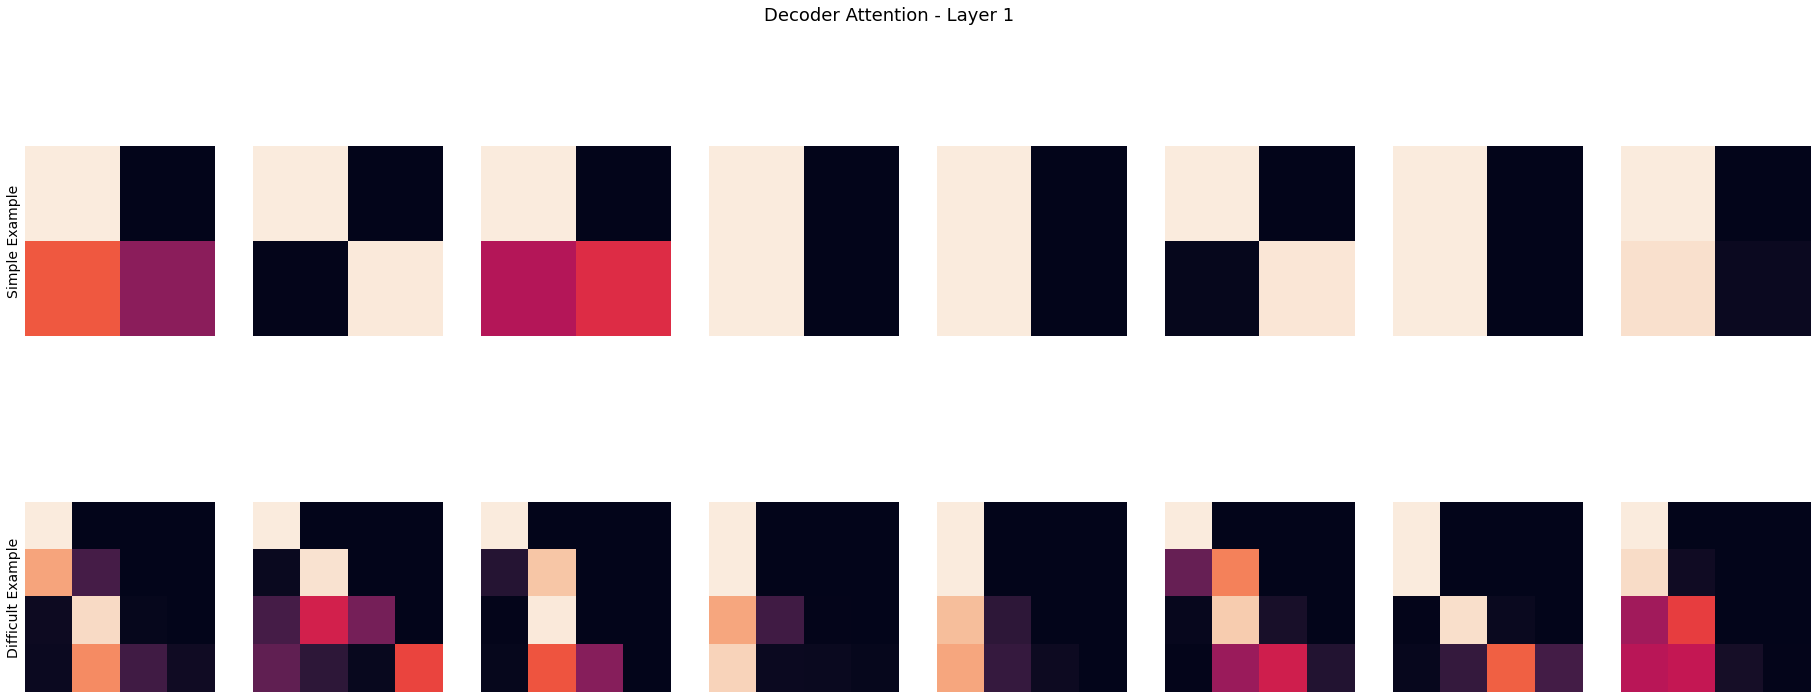

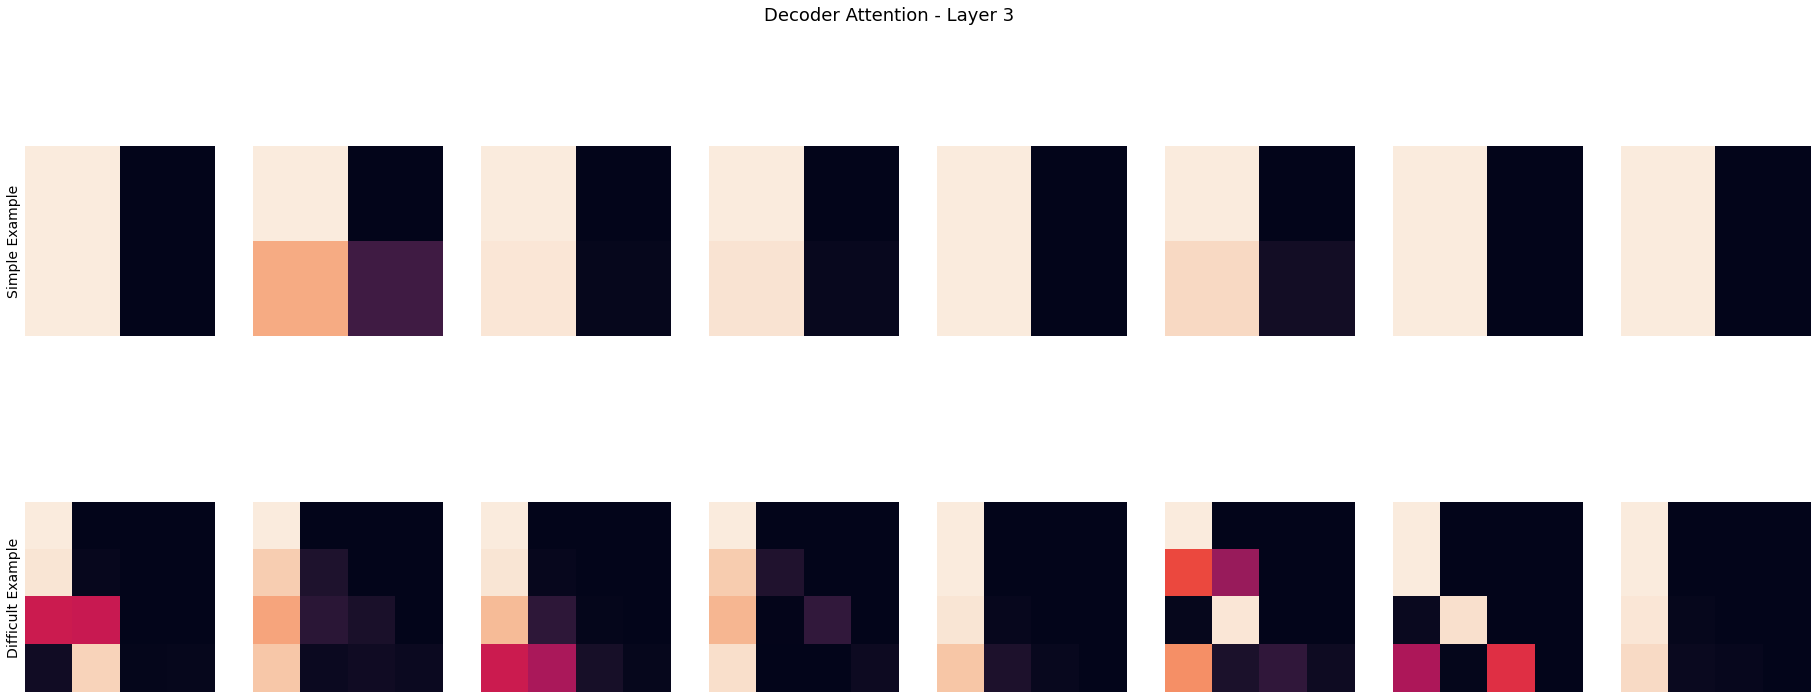

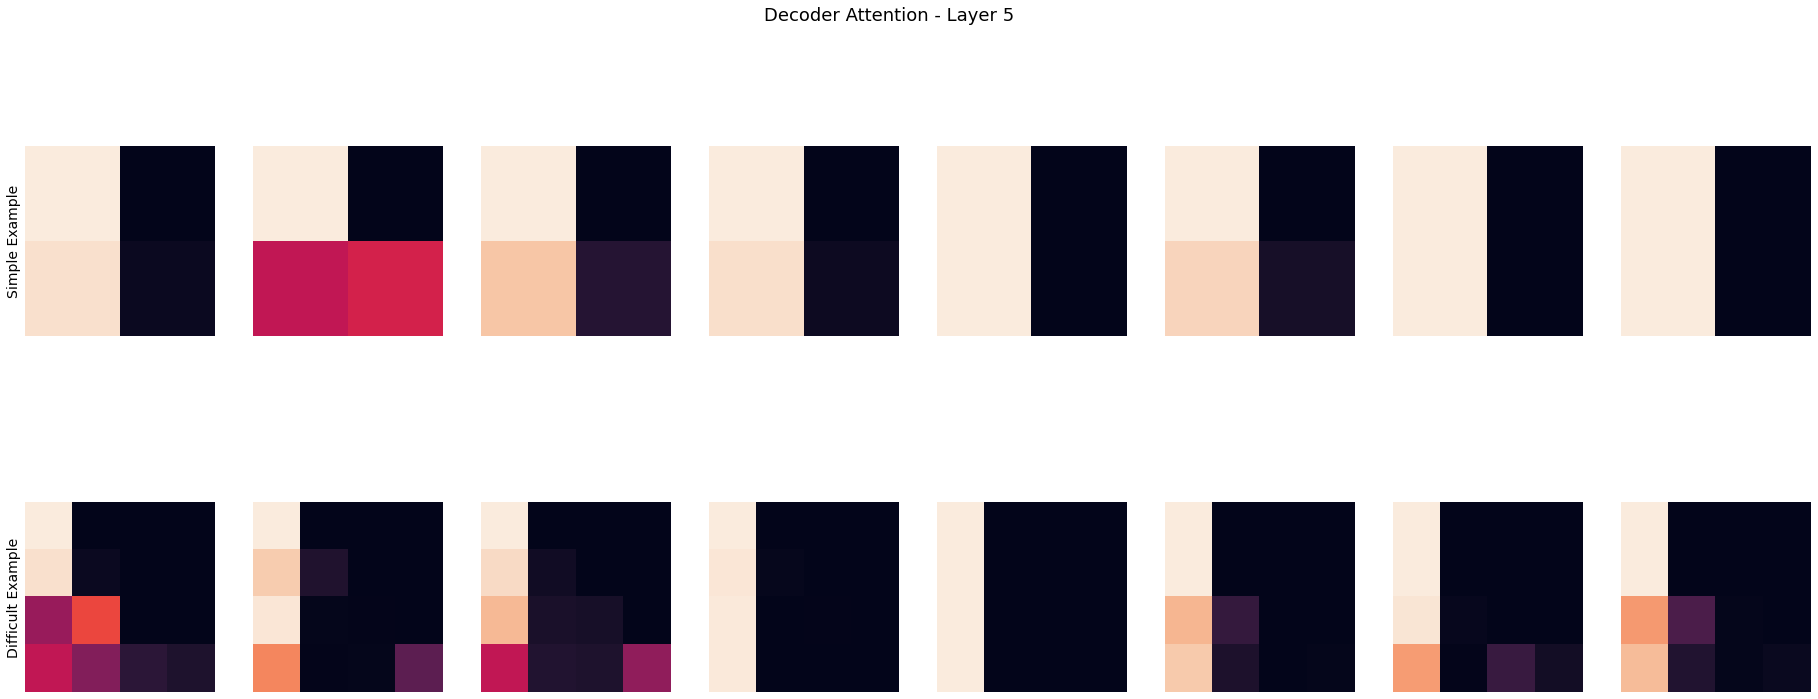

In [ ]:
# Plot decoder attention heads
for i in range(0,len(decoder_att_s),2):
    layer_s = decoder_att_s[i]
    layer_d = decoder_att_d[i]

    fig, axs = plt.subplots(2,layer_s.shape[1],figsize=(32,12))
    fig.suptitle("Decoder Attention - Layer {}".format(i+1), fontsize=18)

    for j in range(layer_s.shape[1]):
        draw(layer_s[0,j,:,:].cpu().detach(), [], [], axs[0,j])
        draw(layer_d[0,j,:,:].cpu().detach(), [], [], axs[1,j])

    axs[0,0].set_ylabel("Simple Example", fontsize=14)
    axs[1,0].set_ylabel("Difficult Example", fontsize=14)
    
    plt.show()

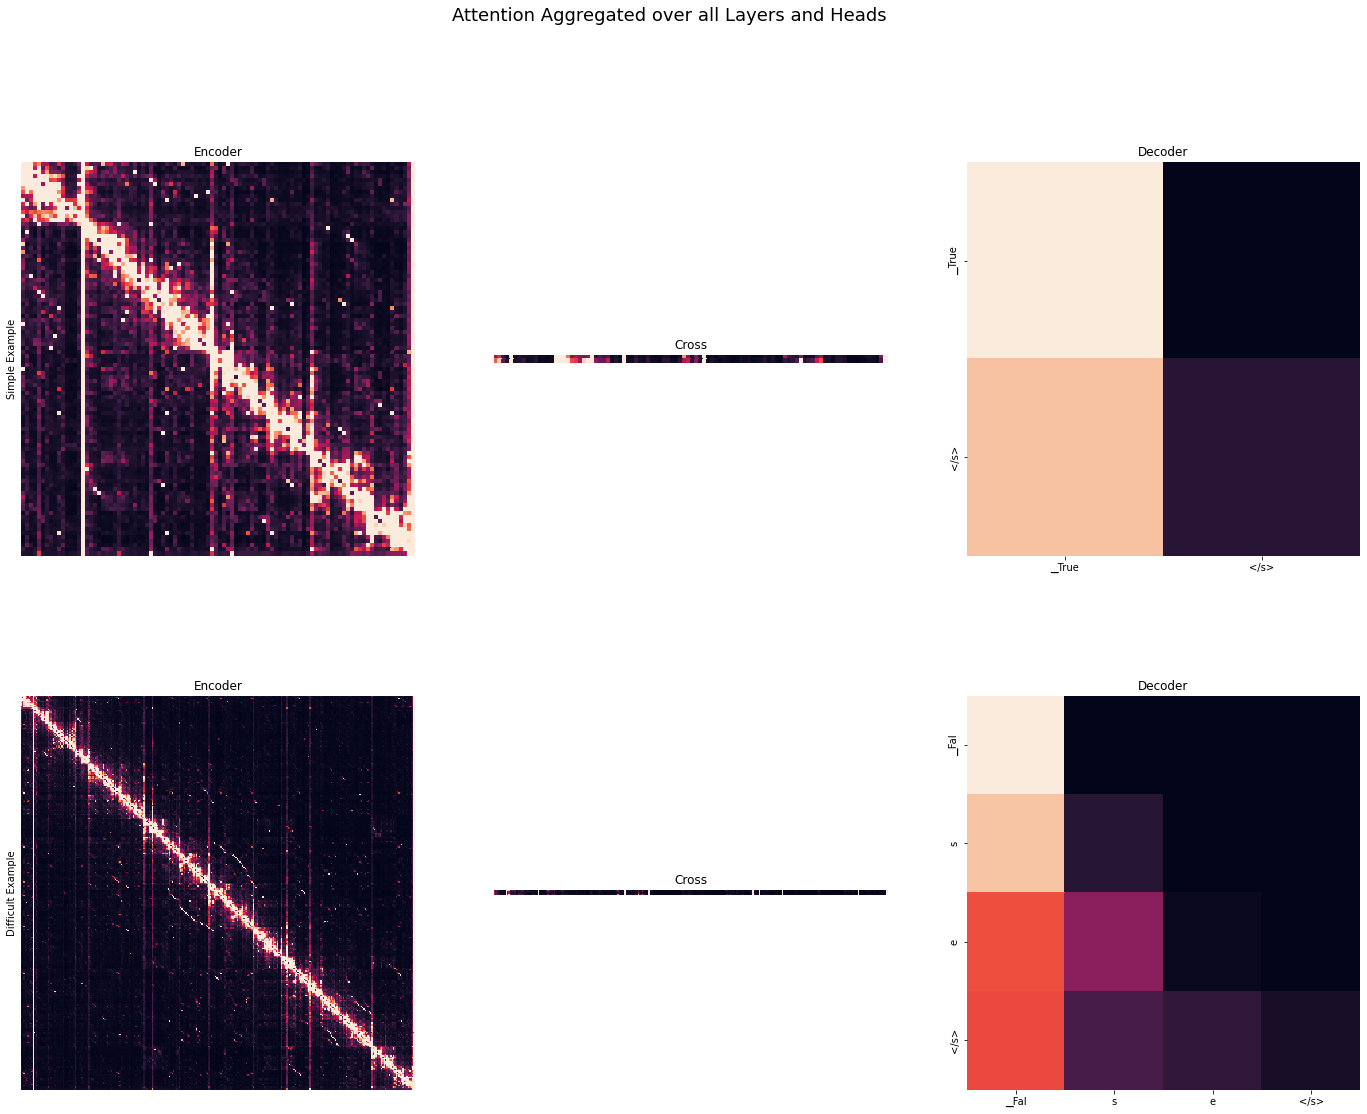

In [ ]:
# Aggregate attention heads over all layers and plot for encoder, cross and decoder
fig,axs = plt.subplots(2,3,figsize=(24,18))
fig.suptitle("Attention Aggregated over all Layers and Heads", fontsize=18)

# Simple Example
axs[0,0].set_title("Encoder")
draw(torch.sum(torch.cat([torch.squeeze(encoder_att_s[i]) for i in range(len(encoder_att_s))],dim=0), dim=0).cpu().detach(), [], [], axs[0,0])

axs[0,1].set_title("Cross")
draw(torch.sum(torch.cat([torch.squeeze(cross_att_s[i]) for i in range(len(cross_att_s))],dim=0), dim=0).cpu().detach(),  [], [], axs[0,1])

axs[0,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_s[i]) for i in range(len(decoder_att_s))],dim=0), dim=0).cpu().detach(),  output_tokens_s, output_tokens_s, axs[0,2])

axs[0,0].set_ylabel("Simple Example")

# Difficult Example
axs[1,0].set_title("Encoder")
draw(torch.sum(torch.cat([torch.squeeze(encoder_att_d[i]) for i in range(len(encoder_att_d))],dim=0), dim=0).cpu().detach(),  [], [], axs[1,0])

axs[1,1].set_title("Cross")
draw(torch.sum(torch.cat([torch.squeeze(cross_att_d[i]) for i in range(len(cross_att_d))],dim=0), dim=0).cpu().detach(),  [], [], axs[1,1])

axs[1,2].set_title("Decoder")
draw(torch.mean(torch.cat([torch.squeeze(decoder_att_d[i]) for i in range(len(decoder_att_d))],dim=0), dim=0).cpu().detach(),  output_tokens_d, output_tokens_d, axs[1,2])

axs[1,0].set_ylabel("Difficult Example")

plt.show()

### Summary



We aim here to summarize and interpret our observations of the above visualization work. We attempt to understand the Attention Mechanism in the three tasks at hand and discuss the differences that appear between simple and complex examples.

*   **Translation -** Translation between French and English is, in theory, quite straight forward. The two language structures being quite similar, the task at hand is close to word by word translation. This is confirmed by the cross-attention heads which link the original to the translated language. They have a predominant diagonal in both simple and complex examples. Encoder and decoder attention heads are sparser and give more attention to context words. Diagonals for complex cases are more dominant than simple ones simply because the context of a word in these cases are relatively more compact.
*   **Summarization -** Surprisingly enough, encoder attention in summarization cases are strongly diagonal in both simple and complex cases. We would have expected that context learning would be the most important part of the summarization process. Instead, this process seems to be compacted in the cross-attention mechanism. Often, we observe strong vertical lines on the corresponding heads. This means specific parts of a text are targeted for the summary. Similarly to encoder attention heads, decoder attention heads also have a strong diagonal.
*   **Question Answering -** Compared to summarization, the encoding mechanism of question answering seems much more complex. The diagonals in both simple and complex cases are much less predominant. This seems reasonable as information from across the text is trying to be linked to make a general understanding of it. In the complex case, we observe that vertical lines appear, translating that most relevant information propagates across the entire text. This information is then captured by cross-attention heads where vertical lines appear similarly to the summarization process. Decoder attention is less relevant to study in this case as our output is a binary word "True" or "False".



## Deliverable 2.2

In this section, we implement the confidence metric defined in [Analyzing Multi-Head Self-Attention: Specialized Heads Do the Heavy Lifting, the Rest Can Be Pruned](https://aclanthology.org/P19-1580.pdf). Confidence of an attention head is the average of its maximum attention weight over examples of a validation set. If an attention head has high confidence, it will tend to assign a high attention weight to a specific token and have high influence in the final prediction. 

We compute confidence of the attention heads accross the three tasks and make our final conclusions.

### Translation Task

Note that the bible-para dataset we are using was not used to train the T5 model. We can thus use it to compute the confidence of attention heads.

In [ ]:
# loading dataset.
from datasets import load_dataset
dataset = load_dataset('bible_para', 'en-fr')

#task to be done.
task_prefix = 'translate English to French: '

#function to separate the dataset.
def isolate(list_, language):
  
  container = []

  for dic in list_:
    if language == 'en':
      container.append(task_prefix + dic[language])
    if language == 'fr': 
      container.append(dic[language])
  return container

# in this example we will use only one batch containing 10 examples 
batched_dataset = dataset['train']['translation'][:20]

batch_input = isolate(batched_dataset, 'en')
batch_output = isolate(batched_dataset, 'fr')

Downloading:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset bible_para downloaded and prepared to /root/.cache/huggingface/datasets/bible_para/en-fr/1.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1. Subsequent calls will reuse this data.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
# Tokenize input sample and compute tokens from ids
input = tokenizer(batch_input, padding=True, truncation=True, return_tensors="pt").to(device)
label = tokenizer(batch_output, padding=True, truncation=True, return_tensors="pt").to(device)

# Pass through model and return attention heads
output = model(input_ids=input['input_ids'], labels=label['input_ids'], output_attentions=True)

# Get attention heads
encoder_att = output['encoder_attentions']
cross_att = output['cross_attentions']
decoder_att = output['decoder_attentions']

In [ ]:
# Compute confidence attention head, for each layer
encoder_confidences, cross_confidences, decoder_confidences = [],[],[]

for layer in encoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    encoder_confidences.append(layer_confidence)

for layer in cross_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    cross_confidences.append(layer_confidence)

for layer in decoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    decoder_confidences.append(layer_confidence)

In [ ]:
# Stack results into unique tensor
encoder_confidences = torch.stack(encoder_confidences).cpu().detach().numpy()
cross_confidences = torch.stack(cross_confidences).cpu().detach().numpy()
decoder_confidences = torch.stack(decoder_confidences).cpu().detach().numpy()

### Translation Task - Final Plot

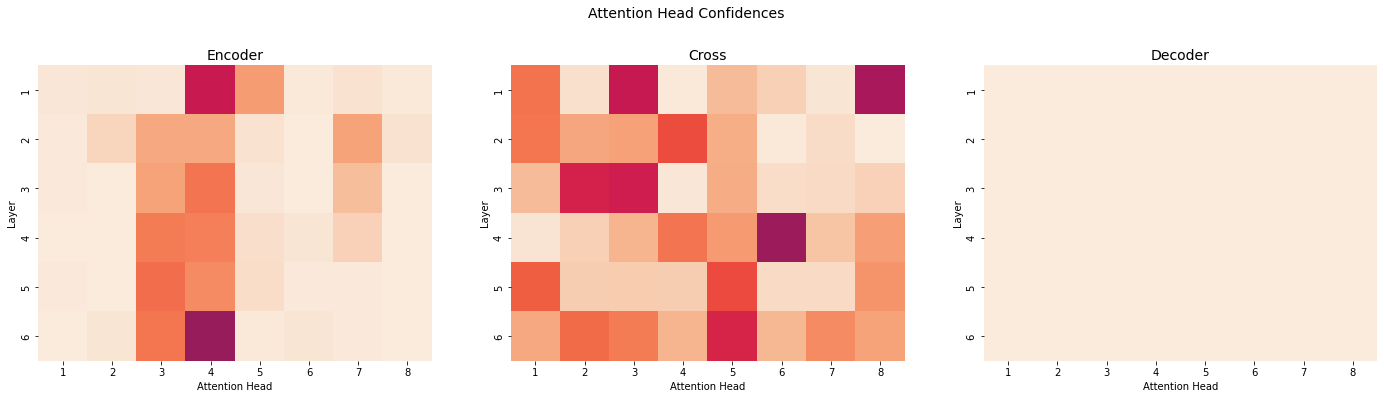

In [ ]:
# Plot results
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Attention Head Confidences", fontsize=14)

draw(encoder_confidences,np.arange(1,9),np.arange(1,7),axs[0])
draw(cross_confidences,np.arange(1,9),np.arange(1,7),axs[1])
draw(decoder_confidences,np.arange(1,9),np.arange(1,7),axs[2])

axs[0].set_title("Encoder", fontsize=14)
axs[0].set_xlabel("Attention Head")
axs[0].set_ylabel("Layer")

axs[1].set_title("Cross", fontsize=14)
axs[1].set_xlabel("Attention Head")
axs[1].set_ylabel("Layer")

axs[2].set_title("Decoder", fontsize=14)
axs[2].set_xlabel("Attention Head")
axs[2].set_ylabel("Layer")

plt.show()

### Summarization Task

In [ ]:
from datasets import load_dataset

# loading dataset.
dataset = load_dataset('ccdv/cnn_dailymail', '3.0.0')


#splitting the dataset.
test_dataset = dataset['test']


#task to be done.
task_prefix = 'summarize: '

# in this example we will use only one batch containing 50 examples.
batch_input = [task_prefix + sequence for sequence in test_dataset['article'][:50]]
batch_output = test_dataset['highlights'][:50]

Downloading:   0%|          | 0.00/9.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/661k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f. Subsequent calls will reuse this data.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
# Tokenize input sample and compute tokens from ids
input = tokenizer(batch_input, padding=True, truncation=True, return_tensors="pt").to(device)
label = tokenizer(batch_output, padding=True, truncation=True, return_tensors="pt").to(device)

# Pass through model and return attention heads
output = model(input_ids=input['input_ids'], labels=label['input_ids'], output_attentions=True)

# Get attention heads
encoder_att = output['encoder_attentions']
cross_att = output['cross_attentions']
decoder_att = output['decoder_attentions']

In [ ]:
# Compute confidence attention head, for each layer
encoder_confidences, cross_confidences, decoder_confidences = [],[],[]

for layer in encoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    encoder_confidences.append(layer_confidence)

for layer in cross_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    cross_confidences.append(layer_confidence)

for layer in decoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    decoder_confidences.append(layer_confidence)

In [ ]:
# Stack results into unique tensor
encoder_confidences = torch.stack(encoder_confidences).cpu().detach().numpy()
cross_confidences = torch.stack(cross_confidences).cpu().detach().numpy()
decoder_confidences = torch.stack(decoder_confidences).cpu().detach().numpy()

### Summarization Task - Final Plot

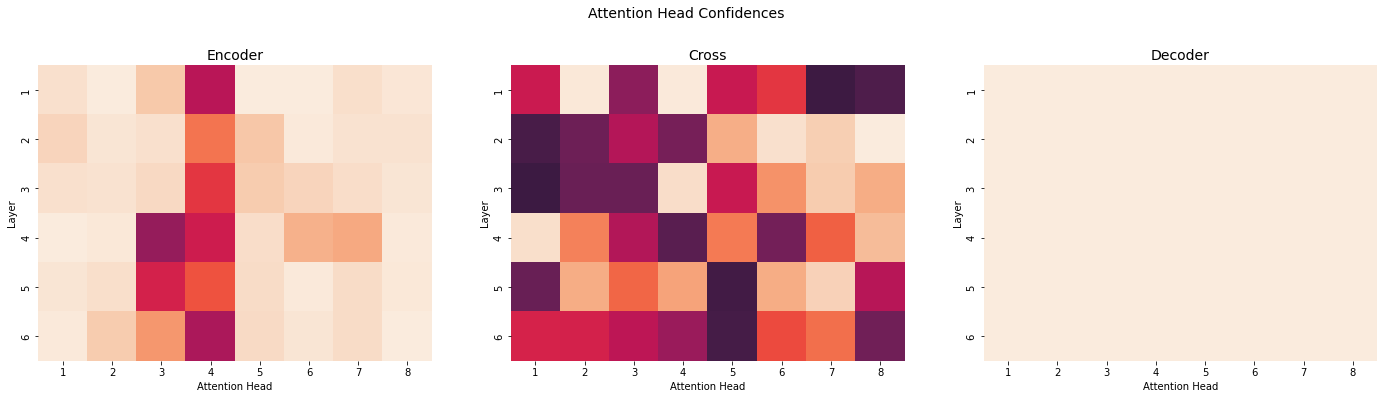

In [ ]:
# Plot results
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Attention Head Confidences", fontsize=14)

draw(encoder_confidences,np.arange(1,9),np.arange(1,7),axs[0])
draw(cross_confidences,np.arange(1,9),np.arange(1,7),axs[1])
draw(decoder_confidences,np.arange(1,9),np.arange(1,7),axs[2])

axs[0].set_title("Encoder", fontsize=14)
axs[0].set_xlabel("Attention Head")
axs[0].set_ylabel("Layer")

axs[1].set_title("Cross", fontsize=14)
axs[1].set_xlabel("Attention Head")
axs[1].set_ylabel("Layer")

axs[2].set_title("Decoder", fontsize=14)
axs[2].set_xlabel("Attention Head")
axs[2].set_ylabel("Layer")

plt.show()

### Question Answering Task

In [ ]:
from datasets import load_dataset

# loading dataset
valid_dataset = load_dataset('boolq', split='validation')

# #task to be done.
task_prefix = 'summarize: '

# # in this example we will use only one batch containing 5 examples.
batch_input_question = valid_dataset['question'][0:50]
batch_input_passage = valid_dataset['passage'][:50]
batch_output = [str(sequence) for sequence in valid_dataset['answer'][0:50]]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Instantiate model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Instantiate tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [ ]:
# Tokenize input sample and compute tokens from ids
input = tokenizer(batch_input_question, batch_input_passage, padding=True, truncation=True, return_tensors="pt").to(device)
label = tokenizer(batch_output, padding=True, truncation=True, return_tensors="pt").to(device)

# Pass through model and return attention heads
output = model(input_ids=input['input_ids'], labels=label['input_ids'], output_attentions=True)

# Get attention heads
encoder_att = output['encoder_attentions']
cross_att = output['cross_attentions']
decoder_att = output['decoder_attentions']

In [ ]:
# Compute confidence attention head, for each layer
encoder_confidences, cross_confidences, decoder_confidences = [],[],[]

for layer in encoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    encoder_confidences.append(layer_confidence)

for layer in cross_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    cross_confidences.append(layer_confidence)

for layer in decoder_att:
    layer_confidence = torch.mean(torch.amax(layer, dim=(2,3)), dim=0)
    decoder_confidences.append(layer_confidence)

In [ ]:
# Stack results into unique tensor
encoder_confidences = torch.stack(encoder_confidences).cpu().detach().numpy()
cross_confidences = torch.stack(cross_confidences).cpu().detach().numpy()
decoder_confidences = torch.stack(decoder_confidences).cpu().detach().numpy()

### Question Answering - Final Plot

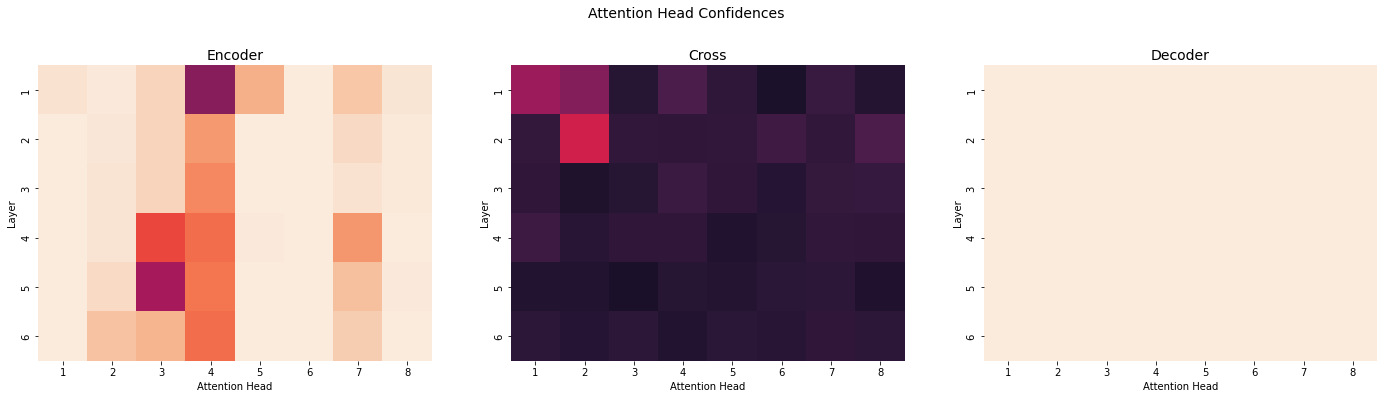

In [ ]:
# Plot results
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Attention Head Confidences", fontsize=14)

draw(encoder_confidences,np.arange(1,9),np.arange(1,7),axs[0])
draw(cross_confidences,np.arange(1,9),np.arange(1,7),axs[1])
draw(decoder_confidences,np.arange(1,9),np.arange(1,7),axs[2])

axs[0].set_title("Encoder", fontsize=14)
axs[0].set_xlabel("Attention Head")
axs[0].set_ylabel("Layer")

axs[1].set_title("Cross", fontsize=14)
axs[1].set_xlabel("Attention Head")
axs[1].set_ylabel("Layer")

axs[2].set_title("Decoder", fontsize=14)
axs[2].set_xlabel("Attention Head")
axs[2].set_ylabel("Layer")

plt.show()

### Summary

We aim here to summarize our observations made regarding the confidence of attention heads for different text processing tasks: Translation, Summarization and Question Answering. The notion of attention head confidence is defined in [Analyzing Multi-Head Self-Attention: Specialized Heads Do the Heavy Lifting, the Rest Can Be Pruned](https://aclanthology.org/P19-1580.pdf) and aims quantifies the capacity of an attention head to wheigh its attention on one specific token. A relatively confident attention head will have a high influence on the final prediction as it will have applied a firmer prediction than competing heads. 

We computed the confidence of attention heads using a sample of 50 test data for each task. Ideally, more data would have led to a more precise estimation of a head's confidence but we were limited in computational ressources.

First, an observation that generalizes to all tasks is that confidence is equally distributed across decoder heads. Indeed, all 3 decoder confidence maps are levelled across the grid. This suggests that all heads tend to assign equally distributed weights to its inputs and do not make any strong inferences. This could also be linked to our implementation of confidence, which does not omit the end of sentence token from its computation. We observed that transformers assign high attention to this token which could bias the computation of the corresponding confidence measure.

Second, it is quite clear that cross-attention heads play a different role in each text-processing task. Most of them have a high confidence in a translation setting while it is negligeable in question answering. In summarization, it seems like specific heads have a high confidence with others coming less into play. This can be explained by the nature of each task: In English to French translation, one input token will often correspond to one output token when translated (close to word to word translation). In question answering, a lot of different parts of a passage come into play to answer a question. Each head must thus pay attention to all parts of a text rather than focus on a single token. In summarization, it seems like some heads are able to focus on a precise part of a text while others attempt to use the information of the entire text. This offers a good compromise to generate a text summary as no parts are left out from the summary and the most important are extracted from heads with high confidence.